This will adapt structure window size

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [3]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [4]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [5]:
def prepare_structure_data(df):
    """Enhanced feature preparation with better normalization"""
    
    # Normalize angles to their circular nature
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # Process each feature type
    features_list = []
    
    # 1. Process angles (phi, psi, omega, tau)
    angles = ['phi', 'psi', 'omega', 'tau']
    for angle in angles:
        # Convert string to array
        angle_arrays = np.array([np.array(eval(x)) for x in df[angle]])
        # Get sin/cos representations
        angle_features = normalize_angles(angle_arrays)
        features_list.append(angle_features)
    
    # 2. Process SASA
    sasa_arrays = np.array([np.array(eval(x)) for x in df['sasa']])
    scaler = RobustScaler()
    sasa_flat = sasa_arrays.reshape(-1, 1)
    sasa_scaled = scaler.fit_transform(sasa_flat).reshape(sasa_arrays.shape)
    features_list.append(sasa_scaled[..., np.newaxis])
    
    # 3. Process secondary structure
    ss_arrays = np.array([list(seq) for seq in df['ss']])
    ss_encoded = np.zeros((len(ss_arrays), ss_arrays.shape[1], 3))
    ss_map = {'H': 0, 'E': 1, 'L': 2}
    for i in range(len(ss_arrays)):
        for j in range(len(ss_arrays[i])):
            ss_encoded[i, j, ss_map[ss_arrays[i, j]]] = 1
    features_list.append(ss_encoded)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    return features

In [10]:
def create_combined_model(seq_length=33, struct_features=12, struct_window=0):
    """Create model with both sequence and structure tracks"""
    # Calculate actual window size for structure
    struct_positions = 1 + (2 * struct_window)
    middle_pos = seq_length // 2
    
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', name='seq_features')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)

    # Structure track
    # Structure track with adaptive dense layer size
    struct_input = tf.keras.layers.Input(shape=(seq_length, struct_features), name='structure_input')
    
    # Extract window around middle position
    if struct_window == 0:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos:middle_pos+1, :]
        )(struct_input)
    else:
        x_struct = tf.keras.layers.Lambda(
            lambda x: x[:, middle_pos-struct_window:middle_pos+struct_window+1, :]
        )(struct_input)

    struct_positions = 1 + (2 * struct_window)
    total_struct_features = struct_positions * struct_features
    
    # Make dense layer size proportional to input features
    struct_dense_size = min(total_struct_features * 2, 128)  # or another scaling rule
        
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    
    # Create learnable weights layer
    weight_layer = tf.keras.layers.Dense(2, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_struct]))
    
    # Apply weights using layers
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    # Combine weighted features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_struct])
    
    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[seq_input, struct_input], outputs=outputs)
    
    def get_track_weights():
        # Get the weights and bias from the weight layer
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            # Calculate softmax
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1])
            }
        return {'sequence': 0.5, 'structure': 0.5}
    
    model.get_track_weights = get_track_weights
    
    return model

In [8]:
def train_and_evaluate(struct_window=0):
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_data_train_after.csv")
    test_df = pd.read_csv("../data/processed_data_test_after.csv")
    
    # Prepare data
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    X_train_struct = prepare_structure_data(train_df)
    X_test_struct = prepare_structure_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    # Shuffle data
    train_df = train_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df['label'].value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_struct: {X_train_struct.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_struct: {X_test_struct.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=struct_window
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_struct])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"Structure weight: {final_weights['structure']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_struct_weight = np.mean([w['structure'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_struct_weight = np.std([w['structure'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"Structure weight: {avg_struct_weight:.4f} ± {std_struct_weight:.4f}")
        
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
        
    return model

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)
y_test: (2737,)

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-12-03 14:42:42.855992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.4956 - loss: 0.6975 - val_accuracy: 0.5333 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5512 - loss: 0.6835 - val_accuracy: 0.6621 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6582 - loss: 0.6319 - val_accuracy: 0.6870 - val_loss: 0.6132 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6833 - loss: 0.6018 - val_accuracy: 0.7102 - val_loss: 0.5813 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7201 - loss: 0.5614 - val_accuracy: 0.7288 - val_loss: 0.5512 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7407 - loss: 0.5271 - val_accuracy: 0.7299 - val_loss: 0.5327 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7603 - loss: 0.5019 - val_

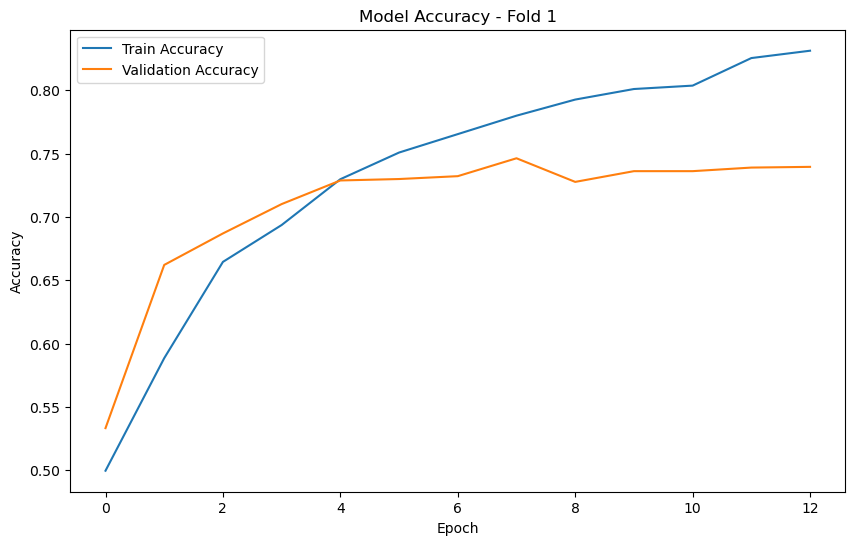

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7463
Balanced Accuracy: 0.7446
MCC: 0.4929
Sensitivity: 0.8007
Specificity: 0.6884

Learned track weights for fold 1:
Sequence weight: 0.6178
Structure weight: 0.3822

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.5001 - loss: 0.7005 - val_accuracy: 0.5424 - val_loss: 0.6914 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5439 - loss: 0.6867 - val_accuracy: 0.6480 - val_loss: 0.6351 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6525 - loss: 0.6280 - val_accuracy: 0.7107 - val_loss: 0.5687 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7122 - loss: 0.5669 - val_accuracy: 0.7452 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7398 - loss: 0.5369 - val_accuracy: 0.7537 - val_loss: 0.5213 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7497 - loss: 0.5266 - val_accuracy: 0.7531 - val_loss: 0.5112 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7520 - loss: 0.5121 - val_

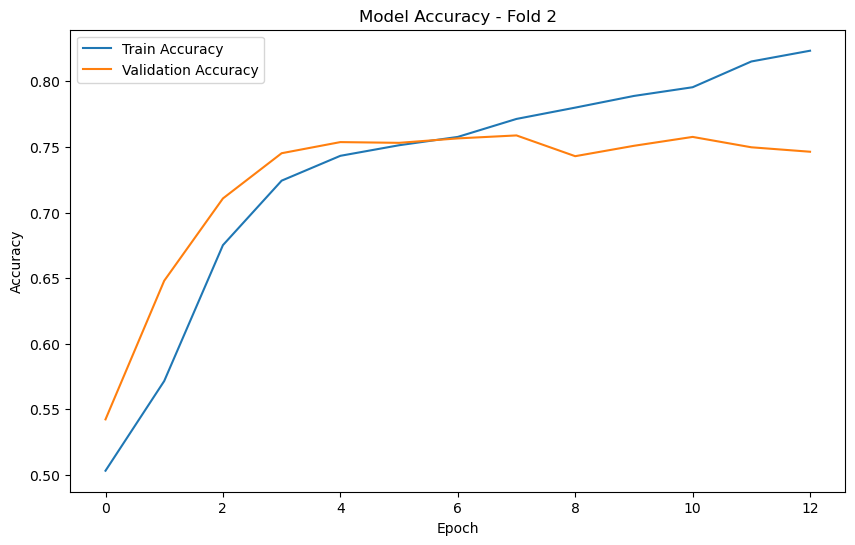

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7588
Balanced Accuracy: 0.7548
MCC: 0.5159
Sensitivity: 0.8226
Specificity: 0.6871

Learned track weights for fold 2:
Sequence weight: 0.6090
Structure weight: 0.3910

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5080 - loss: 0.6966 - val_accuracy: 0.5418 - val_loss: 0.6903 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5591 - loss: 0.6809 - val_accuracy: 0.6480 - val_loss: 0.6376 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6441 - loss: 0.6280 - val_accuracy: 0.6994 - val_loss: 0.5824 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7132 - loss: 0.5671 - val_accuracy: 0.7305 - val_loss: 0.5584 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7291 - loss: 0.5334 - val_accuracy: 0.7277 - val_loss: 0.5510 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7521 - loss: 0.5194 - val_accuracy: 0.7305 - val_loss: 0.5563 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7663 - loss: 0.4897 - val_

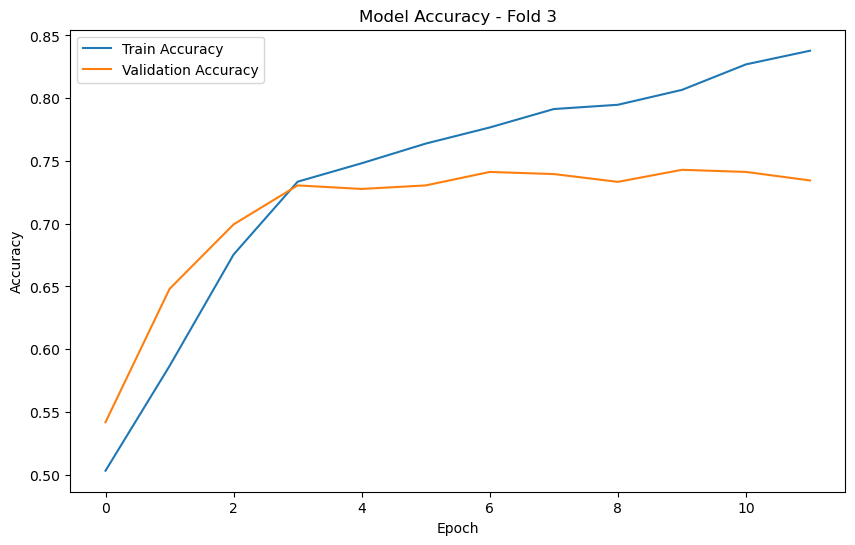

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7412
Balanced Accuracy: 0.7412
MCC: 0.4823
Sensitivity: 0.7415
Specificity: 0.7410

Learned track weights for fold 3:
Sequence weight: 0.5982
Structure weight: 0.4018

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5078 - loss: 0.6955 - val_accuracy: 0.5932 - val_loss: 0.6879 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5840 - loss: 0.6668 - val_accuracy: 0.6723 - val_loss: 0.6214 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6821 - loss: 0.5971 - val_accuracy: 0.7136 - val_loss: 0.5746 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7311 - loss: 0.5530 - val_accuracy: 0.7051 - val_loss: 0.5584 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7363 - loss: 0.5384 - val_accuracy: 0.7203 - val_loss: 0.5487 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7549 - loss: 0.5157 - val_accuracy: 0.7294 - val_loss: 0.5375 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7642 - loss: 0.5049 - val_

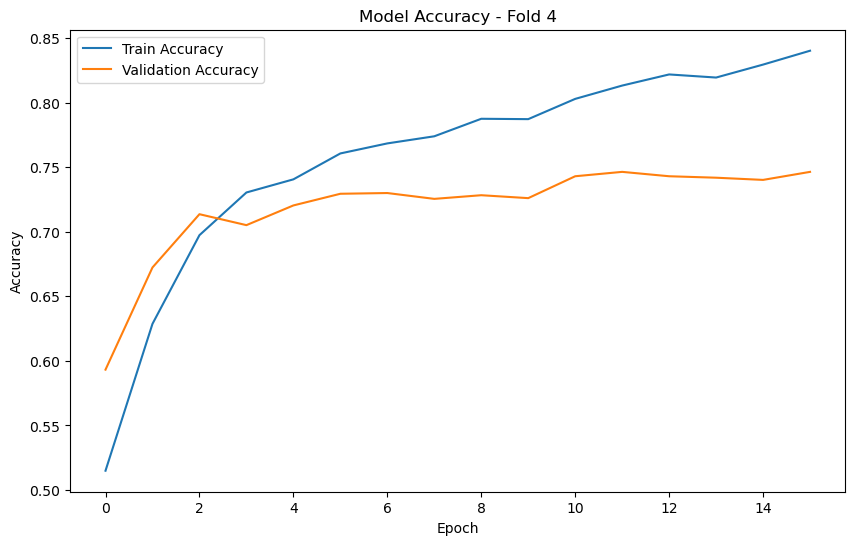

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 4 Results:
Accuracy: 0.7429
Balanced Accuracy: 0.7402
MCC: 0.4888
Sensitivity: 0.8258
Specificity: 0.6546

Learned track weights for fold 4:
Sequence weight: 0.6493
Structure weight: 0.3507

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5178 - loss: 0.6981 - val_accuracy: 0.5593 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5811 - loss: 0.6729 - val_accuracy: 0.6407 - val_loss: 0.6239 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6765 - loss: 0.6100 - val_accuracy: 0.7085 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7341 - loss: 0.5537 - val_accuracy: 0.7322 - val_loss: 0.5433 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7435 - loss: 0.5203 - val_accuracy: 0.7379 - val_loss: 0.5279 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7565 - loss: 0.5094 - val_accuracy: 0.7328 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7632 - loss: 0

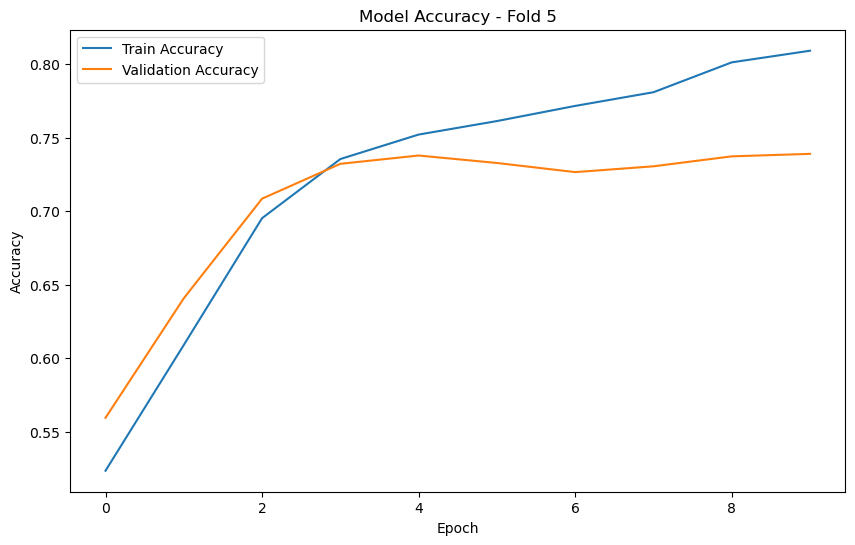

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7379
Balanced Accuracy: 0.7376
MCC: 0.4751
Sensitivity: 0.7459
Specificity: 0.7292

Learned track weights for fold 5:
Sequence weight: 0.5880
Structure weight: 0.4120

Average track weights across folds:
Sequence weight: 0.6124 ± 0.0210
Structure weight: 0.3876 ± 0.0210

Average Cross-validation Results:
ACC: 0.7454 ± 0.0072
BALANCED_ACC: 0.7437 ± 0.0060
MCC: 0.4910 ± 0.0139
SN: 0.7873 ± 0.0367
SP: 0.7001 ± 0.0313

Final Test Set Results:
Accuracy: 0.7132
Balanced Accuracy: 0.7355
MCC: 0.2827
Sensitivity: 0.7625
Specificity: 0.7085
Confusion Matrix:
[[1769  728]
 [  57  183]]


In [11]:
if __name__ == "__main__":
    model = train_and_evaluate()

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)
y_test: (2737,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5376 - loss: 0.6919 - val_accuracy: 0.5621 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.5679 - loss: 0.6724 - val_accuracy: 0.6514 - val_loss: 0.6371 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6648 - loss: 0.6164 - val_accuracy: 0.7266 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7284 - loss: 0.5558 - val_accuracy: 0.7339 - val_loss: 0.5410 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7508 - loss: 0.5294 - val_accuracy: 0.7395 - val_loss: 0.5257 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7635 - loss: 0.5061 - val_accuracy: 0.7379 - val_loss: 0.5229 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7670 - loss: 0

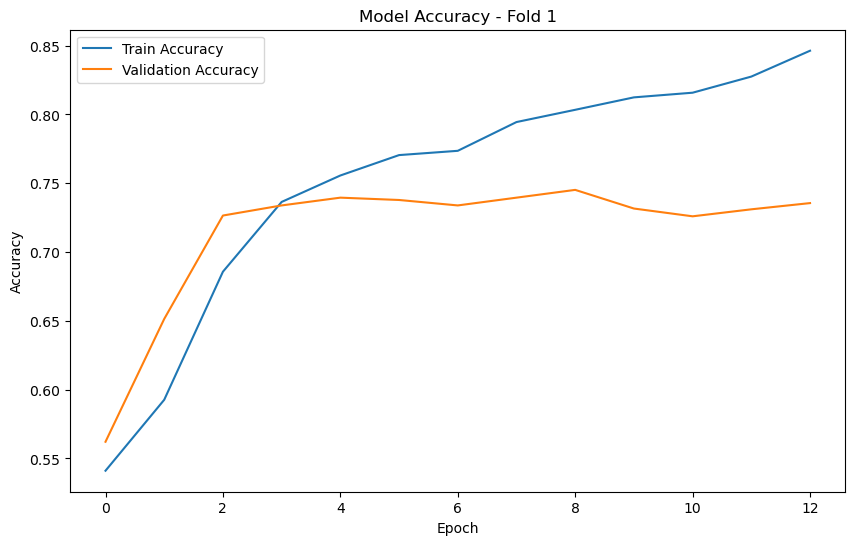

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7395
Balanced Accuracy: 0.7372
MCC: 0.4808
Sensitivity: 0.8127
Specificity: 0.6616

Learned track weights for fold 1:
Sequence weight: 0.5374
Structure weight: 0.4626

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5142 - loss: 0.6949 - val_accuracy: 0.5435 - val_loss: 0.6851 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5686 - loss: 0.6742 - val_accuracy: 0.6915 - val_loss: 0.5882 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7120 - loss: 0.5776 - val_accuracy: 0.7429 - val_loss: 0.5405 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7381 - loss: 0.5411 - val_accuracy: 0.7480 - val_loss: 0.5165 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7438 - loss: 0.5240 - val_accuracy: 0.7548 - val_loss: 0.5131 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7616 - loss: 0.5056 - val_accuracy: 0.7559 - val_loss: 0.5101 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7716 - loss: 0.4932 - val

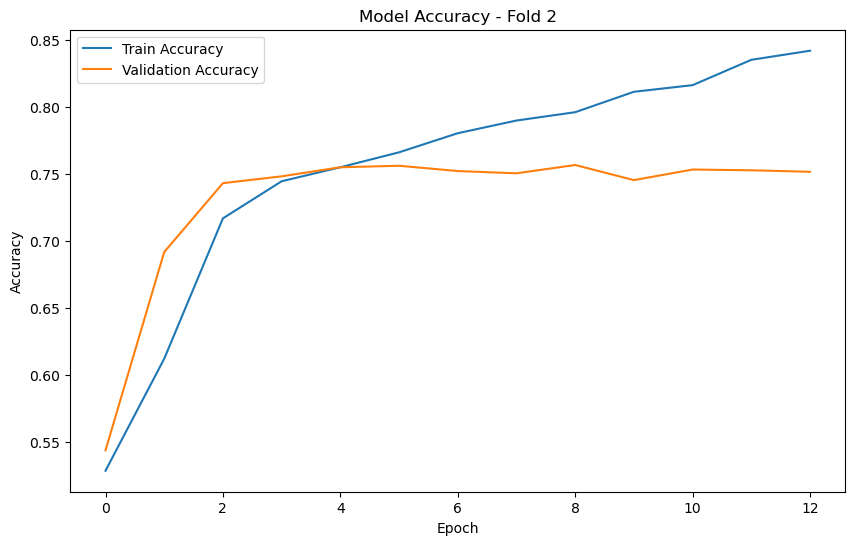

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7503
Balanced Accuracy: 0.7430
MCC: 0.5056
Sensitivity: 0.8697
Specificity: 0.6163

Learned track weights for fold 2:
Sequence weight: 0.5366
Structure weight: 0.4634

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.5255 - loss: 0.6948 - val_accuracy: 0.5768 - val_loss: 0.6794 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6006 - loss: 0.6652 - val_accuracy: 0.6729 - val_loss: 0.6179 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6913 - loss: 0.6020 - val_accuracy: 0.7107 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7195 - loss: 0.5550 - val_accuracy: 0.7260 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7406 - loss: 0.5289 - val_accuracy: 0.7277 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7529 - loss: 0.5149 - val_accuracy: 0.7345 - val_loss: 0.5424 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7647 - loss: 0.4960 - val

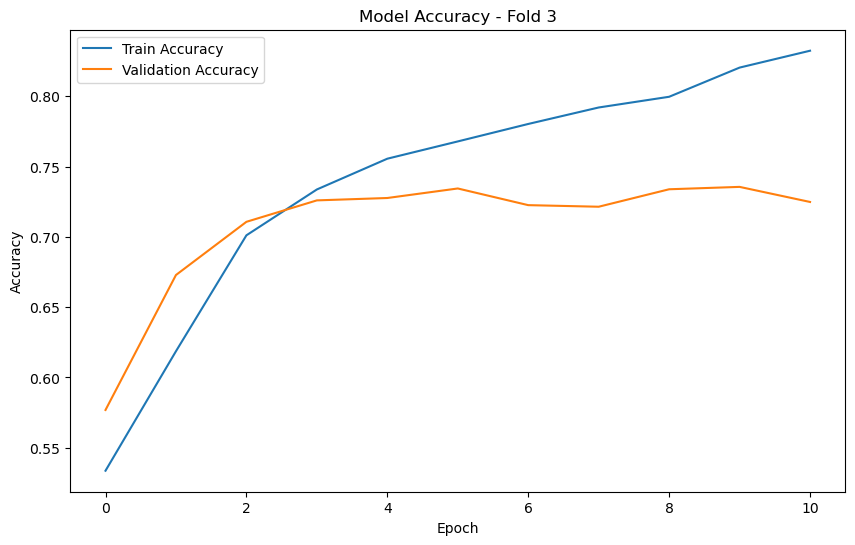

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7345
Balanced Accuracy: 0.7352
MCC: 0.4703
Sensitivity: 0.7130
Specificity: 0.7573

Learned track weights for fold 3:
Sequence weight: 0.5375
Structure weight: 0.4625

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5380 - loss: 0.6908 - val_accuracy: 0.6102 - val_loss: 0.6616 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6535 - loss: 0.6241 - val_accuracy: 0.6983 - val_loss: 0.5791 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7234 - loss: 0.5522 - val_accuracy: 0.7373 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7445 - loss: 0.5268 - val_accuracy: 0.7243 - val_loss: 0.5473 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7600 - loss: 0.5125 - val_accuracy: 0.7254 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7650 - loss: 0.4938 - val_accuracy: 0.7260 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7740 - loss: 0.4870 - val

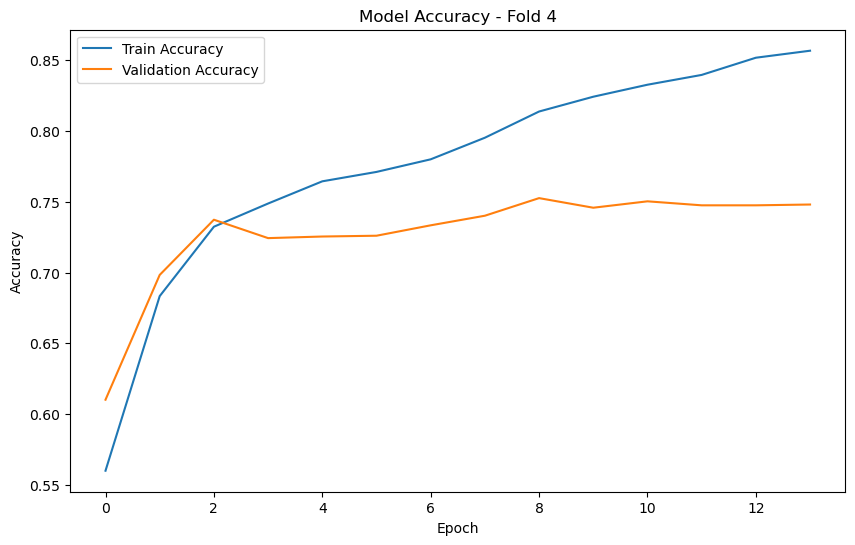

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Results:
Accuracy: 0.7525
Balanced Accuracy: 0.7496
MCC: 0.5092
Sensitivity: 0.8412
Specificity: 0.6581

Learned track weights for fold 4:
Sequence weight: 0.5390
Structure weight: 0.4610

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.5403 - loss: 0.6882 - val_accuracy: 0.5763 - val_loss: 0.6823 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6118 - loss: 0.6671 - val_accuracy: 0.7090 - val_loss: 0.5871 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7114 - loss: 0.5758 - val_accuracy: 0.7322 - val_loss: 0.5457 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7439 - loss: 0.5430 - val_accuracy: 0.7294 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7554 - loss: 0.5153 - val_accuracy: 0.7345 - val_loss: 0.5293 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7725 - loss: 0.4996 - val_accuracy: 0.7362 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7770 - loss: 0.4871 - val

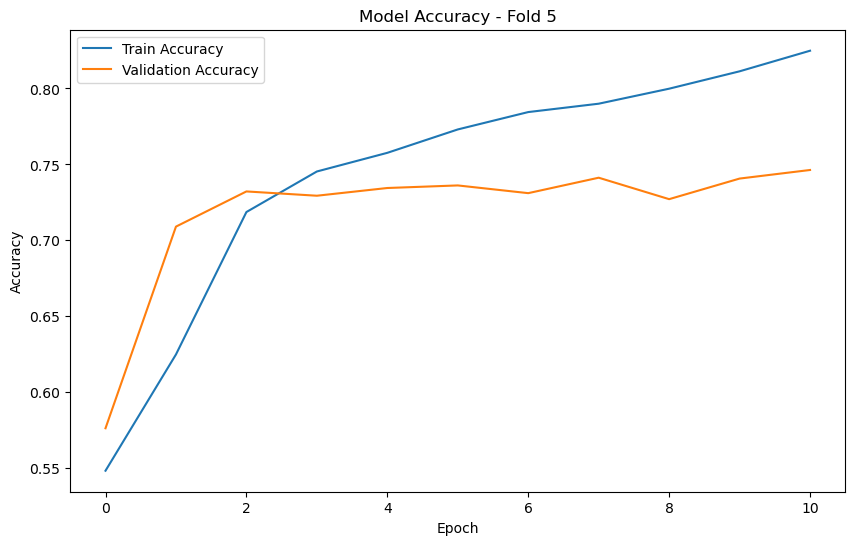

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7362
Balanced Accuracy: 0.7351
MCC: 0.4712
Sensitivity: 0.7655
Specificity: 0.7046

Learned track weights for fold 5:
Sequence weight: 0.5206
Structure weight: 0.4794

Average track weights across folds:
Sequence weight: 0.5342 ± 0.0069
Structure weight: 0.4658 ± 0.0069

Average Cross-validation Results:
ACC: 0.7426 ± 0.0074
BALANCED_ACC: 0.7400 ± 0.0056
MCC: 0.4874 ± 0.0168
SN: 0.8004 ± 0.0556
SP: 0.6796 ± 0.0479

Final Test Set Results:
Accuracy: 0.6872
Balanced Accuracy: 0.7344
MCC: 0.2756
Sensitivity: 0.7917
Specificity: 0.6772
Confusion Matrix:
[[1691  806]
 [  50  190]]


In [12]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=1)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5266 - loss: 0.6969 - val_accuracy: 0.5689 - val_loss: 0.6849 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5590 - loss: 0.6849 - val_accuracy: 0.5667 - val_loss: 0.6728 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5627 - loss: 0.6803 - val_accuracy: 0.5723 - val_loss: 0.6651 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5837 - loss: 0.6691 - val_accuracy: 0.6689 - val_loss: 0.6230 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6513 - loss: 0.6270 - val_accuracy: 0.7045 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7070 - loss: 0.5751 - val_accuracy: 0.7424 - val_loss: 0.5297 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7429 - loss: 0.5365 - val

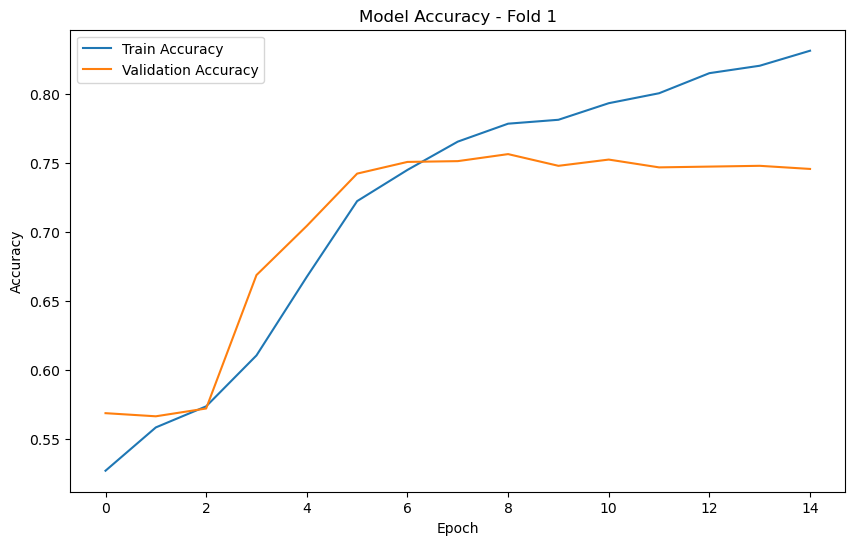

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7480
Balanced Accuracy: 0.7463
MCC: 0.4963
Sensitivity: 0.8018
Specificity: 0.6908

Learned track weights for fold 1:
Sequence weight: 0.4978
Structure weight: 0.5022

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4868 - loss: 0.7177 - val_accuracy: 0.5486 - val_loss: 0.6882 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5538 - loss: 0.6873 - val_accuracy: 0.6458 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6559 - loss: 0.6254 - val_accuracy: 0.7158 - val_loss: 0.5581 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7265 - loss: 0.5633 - val_accuracy: 0.7475 - val_loss: 0.5259 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7393 - loss: 0.5345 - val_accuracy: 0.7390 - val_loss: 0.5219 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7497 - loss: 0.5182 - val_accuracy: 0.7463 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7651 - loss: 0.5059 - val

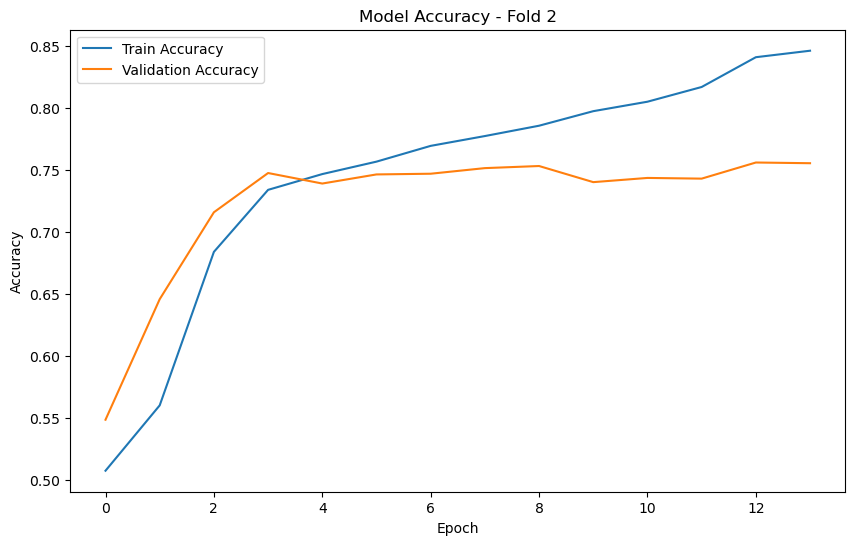

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7531
Balanced Accuracy: 0.7513
MCC: 0.5039
Sensitivity: 0.7831
Specificity: 0.7194

Learned track weights for fold 2:
Sequence weight: 0.5555
Structure weight: 0.4445

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5057 - loss: 0.7057 - val_accuracy: 0.6096 - val_loss: 0.6810 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6073 - loss: 0.6622 - val_accuracy: 0.6571 - val_loss: 0.6260 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6760 - loss: 0.6070 - val_accuracy: 0.6989 - val_loss: 0.5866 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7200 - loss: 0.5613 - val_accuracy: 0.7056 - val_loss: 0.5829 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7349 - loss: 0.5322 - val_accuracy: 0.7113 - val_loss: 0.5797 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7390 - loss: 0.5242 - val_accuracy: 0.7220 - val_loss: 0.5634 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7613 - loss: 0.5023 - val

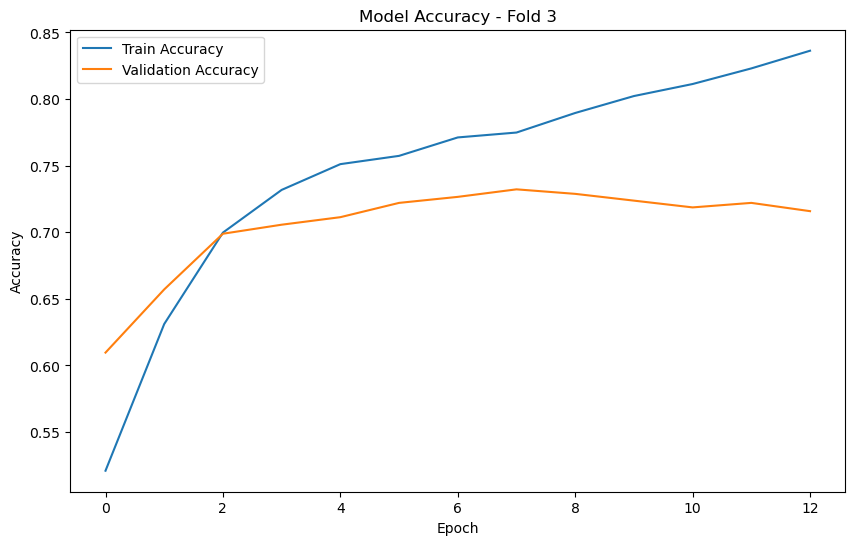

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7322
Balanced Accuracy: 0.7327
MCC: 0.4652
Sensitivity: 0.7174
Specificity: 0.7480

Learned track weights for fold 3:
Sequence weight: 0.5557
Structure weight: 0.4443

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5163 - loss: 0.6946 - val_accuracy: 0.5932 - val_loss: 0.6805 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5628 - loss: 0.6791 - val_accuracy: 0.5989 - val_loss: 0.6601 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6148 - loss: 0.6530 - val_accuracy: 0.6825 - val_loss: 0.6133 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6919 - loss: 0.5921 - val_accuracy: 0.7062 - val_loss: 0.5688 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7281 - loss: 0.5494 - val_accuracy: 0.7254 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7498 - loss: 0.5238 - val_accuracy: 0.7294 - val_loss: 0.5478 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7611 - loss: 0.5053 - val

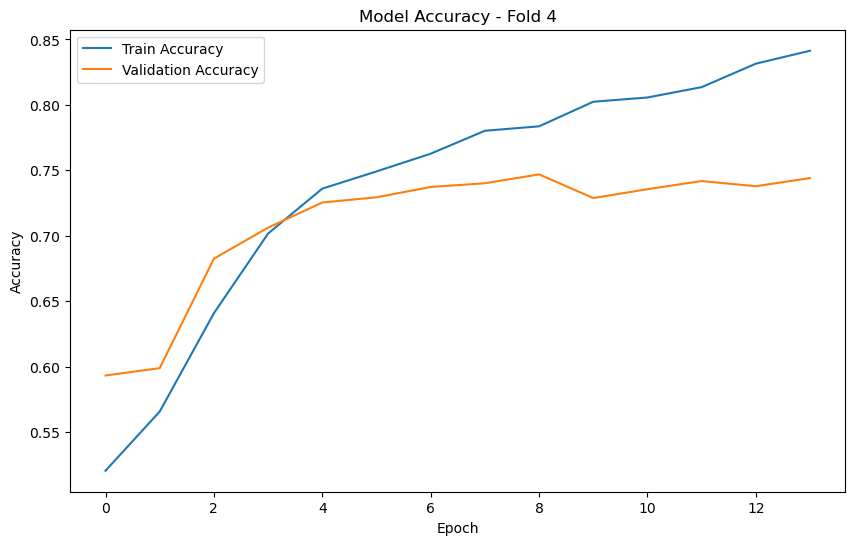

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 4 Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7458
MCC: 0.4931
Sensitivity: 0.7798
Specificity: 0.7118

Learned track weights for fold 4:
Sequence weight: 0.5576
Structure weight: 0.4424

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.5261 - loss: 0.7023 - val_accuracy: 0.5718 - val_loss: 0.6864 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5876 - loss: 0.6746 - val_accuracy: 0.5847 - val_loss: 0.6781 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5917 - loss: 0.6668 - val_accuracy: 0.6028 - val_loss: 0.6616 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6310 - loss: 0.6427 - val_accuracy: 0.6362 - val_loss: 0.6365 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6614 - loss: 0.6173 - val_accuracy: 0.6605 - val_loss: 0.6144 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6945 - loss: 0.5925 - val_accuracy: 0.6910 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7237 - loss: 0.5602 - val

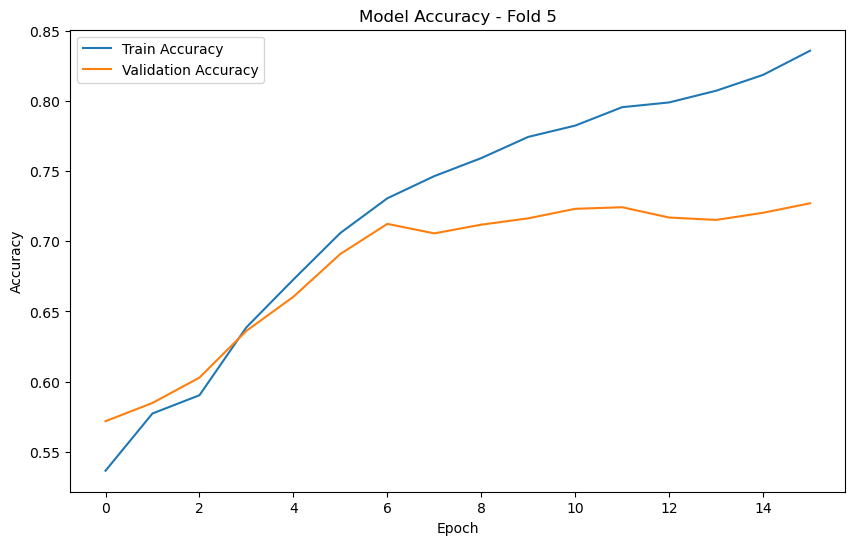

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7232
Balanced Accuracy: 0.7248
MCC: 0.4504
Sensitivity: 0.6805
Specificity: 0.7691

Learned track weights for fold 5:
Sequence weight: 0.5485
Structure weight: 0.4515

Average track weights across folds:
Sequence weight: 0.5430 ± 0.0228
Structure weight: 0.4570 ± 0.0228

Average Cross-validation Results:
ACC: 0.7407 ± 0.0112
BALANCED_ACC: 0.7402 ± 0.0099
MCC: 0.4818 ± 0.0204
SN: 0.7525 ± 0.0459
SP: 0.7278 ± 0.0276

Final Test Set Results:
Accuracy: 0.7355
Balanced Accuracy: 0.7590
MCC: 0.3154
Sensitivity: 0.7875
Specificity: 0.7305
Confusion Matrix:
[[1824  673]
 [  51  189]]


In [24]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=2)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)
y_test: (2737,)

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5047 - loss: 0.7059 - val_accuracy: 0.6282 - val_loss: 0.6749 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6105 - loss: 0.6547 - val_accuracy: 0.6904 - val_loss: 0.6105 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.6849 - loss: 0.6017 - val_accuracy: 0.7305 - val_loss: 0.5544 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7307 - loss: 0.5484 - val_accuracy: 0.7395 - val_loss: 0.5306 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7466 - loss: 0.5276 - val_accuracy: 0.7446 - val_loss: 0.5217 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7709 - loss: 0.4953 - val_accuracy: 0.7542 - val_loss: 0.5149 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7820 - loss: 0.4816 - val

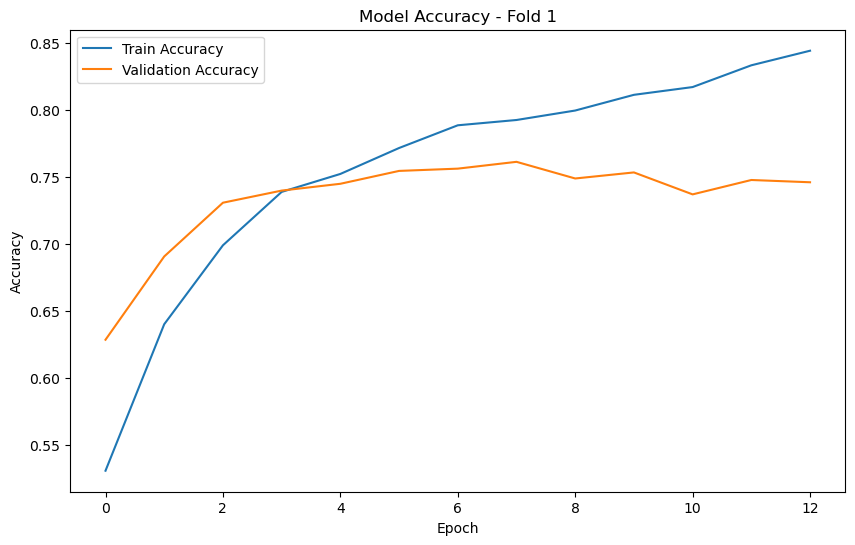

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7610
Balanced Accuracy: 0.7594
MCC: 0.5222
Sensitivity: 0.8105
Specificity: 0.7083

Learned track weights for fold 1:
Sequence weight: 0.5408
Structure weight: 0.4592

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5366 - loss: 0.6951 - val_accuracy: 0.6017 - val_loss: 0.6659 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6215 - loss: 0.6580 - val_accuracy: 0.6740 - val_loss: 0.6080 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6815 - loss: 0.6018 - val_accuracy: 0.7062 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7232 - loss: 0.5544 - val_accuracy: 0.7390 - val_loss: 0.5345 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7409 - loss: 0.5280 - val_accuracy: 0.7480 - val_loss: 0.5120 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.7632 - loss: 0.4987 - val_accuracy: 0.7486 - val_loss: 0.5130 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7752 - loss: 0.4759 - val_

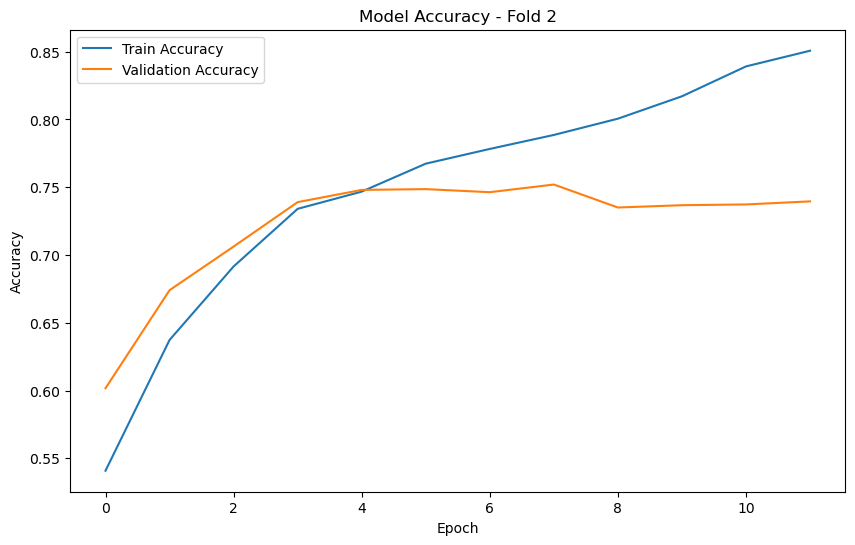

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7463
Balanced Accuracy: 0.7444
MCC: 0.4902
Sensitivity: 0.7778
Specificity: 0.7110

Learned track weights for fold 2:
Sequence weight: 0.5462
Structure weight: 0.4538

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5458 - loss: 0.6985 - val_accuracy: 0.5983 - val_loss: 0.6766 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.6257 - loss: 0.6523 - val_accuracy: 0.6774 - val_loss: 0.5944 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6999 - loss: 0.5755 - val_accuracy: 0.7198 - val_loss: 0.5503 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7240 - loss: 0.5464 - val_accuracy: 0.7271 - val_loss: 0.5518 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7483 - loss: 0.5213 - val_accuracy: 0.7288 - val_loss: 0.5483 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7614 - loss: 0.5084 - val_accuracy: 0.7226 - val_loss: 0.5733 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7637 - loss: 0.4936 - val

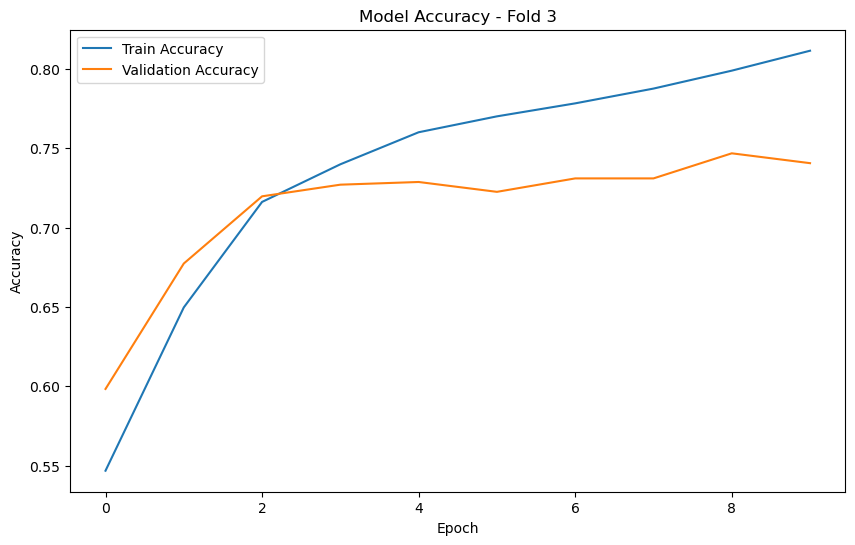

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7288
Balanced Accuracy: 0.7297
MCC: 0.4594
Sensitivity: 0.7032
Specificity: 0.7561

Learned track weights for fold 3:
Sequence weight: 0.5329
Structure weight: 0.4671

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.5147 - loss: 0.6919 - val_accuracy: 0.5542 - val_loss: 0.6819 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.5779 - loss: 0.6739 - val_accuracy: 0.6588 - val_loss: 0.6291 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6774 - loss: 0.6108 - val_accuracy: 0.7006 - val_loss: 0.5835 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7263 - loss: 0.5538 - val_accuracy: 0.7254 - val_loss: 0.5597 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7596 - loss: 0.5244 - val_accuracy: 0.7260 - val_loss: 0.5428 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7716 - loss: 0.5042 - val_accuracy: 0.7390 - val_loss: 0.5271 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7735 - loss: 0.4890 - val

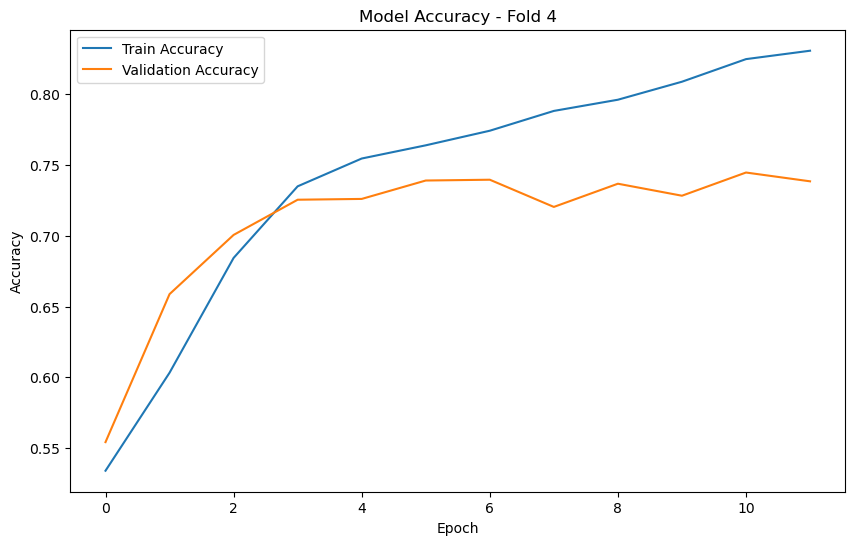

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Fold 4 Results:
Accuracy: 0.7395
Balanced Accuracy: 0.7397
MCC: 0.4792
Sensitivity: 0.7349
Specificity: 0.7445

Learned track weights for fold 4:
Sequence weight: 0.5276
Structure weight: 0.4724

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5230 - loss: 0.7022 - val_accuracy: 0.5621 - val_loss: 0.6895 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5603 - loss: 0.6795 - val_accuracy: 0.6621 - val_loss: 0.6167 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6827 - loss: 0.6000 - val_accuracy: 0.7237 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7323 - loss: 0.5455 - val_accuracy: 0.7367 - val_loss: 0.5370 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7448 - loss: 0.5256 - val_accuracy: 0.7266 - val_loss: 0.5311 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7565 - loss: 0.5105 - val_accuracy: 0.7333 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7666 - loss: 0.4956 - val

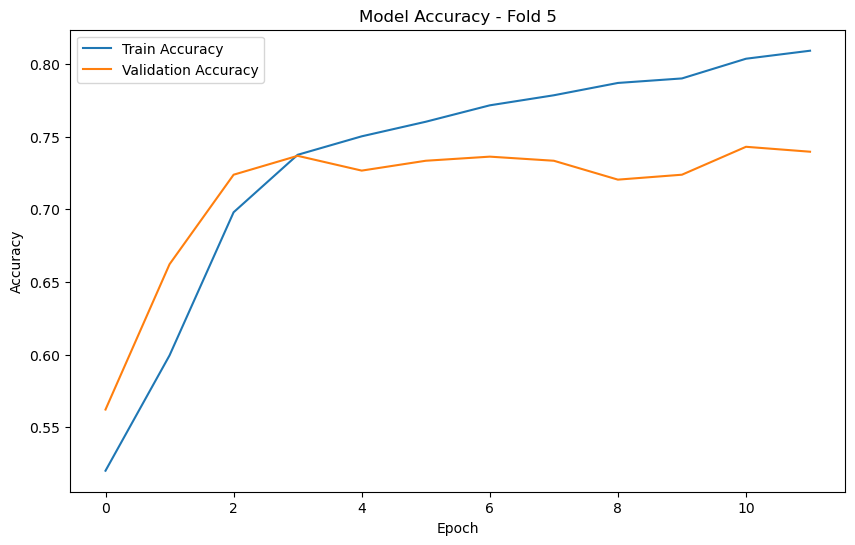

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7362
Balanced Accuracy: 0.7361
MCC: 0.4720
Sensitivity: 0.7383
Specificity: 0.7339

Learned track weights for fold 5:
Sequence weight: 0.5288
Structure weight: 0.4712

Average track weights across folds:
Sequence weight: 0.5353 ± 0.0072
Structure weight: 0.4647 ± 0.0072

Average Cross-validation Results:
ACC: 0.7424 ± 0.0109
BALANCED_ACC: 0.7418 ± 0.0100
MCC: 0.4846 ± 0.0213
SN: 0.7529 ± 0.0373
SP: 0.7308 ± 0.0186

Final Test Set Results:
Accuracy: 0.7347
Balanced Accuracy: 0.7398
MCC: 0.2937
Sensitivity: 0.7458
Specificity: 0.7337
Confusion Matrix:
[[1832  665]
 [  61  179]]


In [13]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=3)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)
y_test: (2737,)

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.5264 - loss: 0.7012 - val_accuracy: 0.5757 - val_loss: 0.6764 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5931 - loss: 0.6719 - val_accuracy: 0.6847 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6652 - loss: 0.6169 - val_accuracy: 0.7136 - val_loss: 0.5776 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7045 - loss: 0.5754 - val_accuracy: 0.7458 - val_loss: 0.5381 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7479 - loss: 0.5276 - val_accuracy: 0.7407 - val_loss: 0.5267 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7553 - loss: 0.5134 - val_accuracy: 0.7294 - val_loss: 0.5337 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7703 - loss: 0.4906 - val

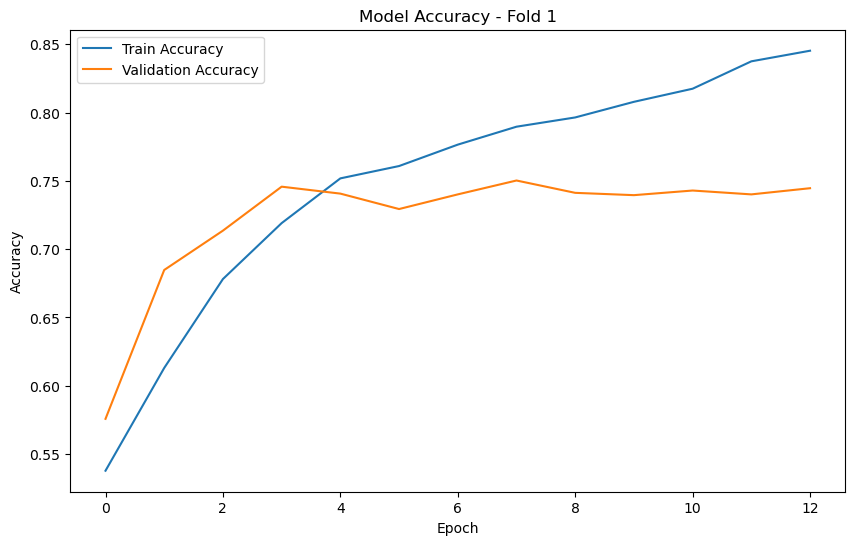

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7503
Balanced Accuracy: 0.7476
MCC: 0.5037
Sensitivity: 0.8324
Specificity: 0.6628

Learned track weights for fold 1:
Sequence weight: 0.5277
Structure weight: 0.4723

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4963 - loss: 0.6990 - val_accuracy: 0.6266 - val_loss: 0.6818 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6003 - loss: 0.6696 - val_accuracy: 0.7034 - val_loss: 0.5836 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7123 - loss: 0.5836 - val_accuracy: 0.7322 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7369 - loss: 0.5450 - val_accuracy: 0.7492 - val_loss: 0.5144 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7452 - loss: 0.5357 - val_accuracy: 0.7576 - val_loss: 0.5043 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7591 - loss: 0.5148 - val_accuracy: 0.7605 - val_loss: 0.4973 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7758 - loss: 0.4917 - val

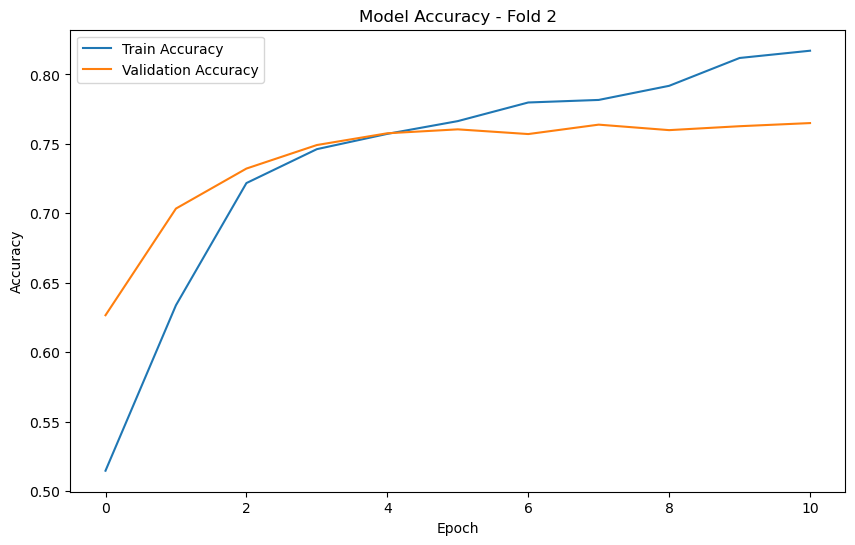

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 2 Results:
Accuracy: 0.7605
Balanced Accuracy: 0.7568
MCC: 0.5191
Sensitivity: 0.8194
Specificity: 0.6942

Learned track weights for fold 2:
Sequence weight: 0.5369
Structure weight: 0.4631

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5109 - loss: 0.7017 - val_accuracy: 0.5927 - val_loss: 0.6832 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6027 - loss: 0.6666 - val_accuracy: 0.6576 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6720 - loss: 0.6135 - val_accuracy: 0.6808 - val_loss: 0.5924 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7136 - loss: 0.5663 - val_accuracy: 0.7096 - val_loss: 0.5819 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7317 - loss: 0.5433 - val_accuracy: 0.7181 - val_loss: 0.5697 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7425 - loss: 0.5173 - val_accuracy: 0.7147 - val_loss: 0.5730 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7572 - loss: 0.5034 - val

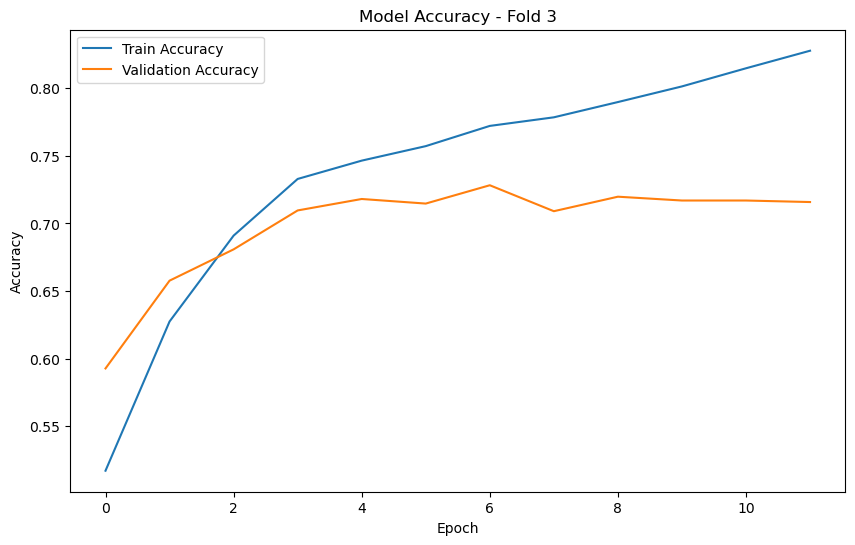

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7282
Balanced Accuracy: 0.7299
MCC: 0.4614
Sensitivity: 0.6780
Specificity: 0.7818

Learned track weights for fold 3:
Sequence weight: 0.5319
Structure weight: 0.4681

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.4925 - loss: 0.7037 - val_accuracy: 0.5463 - val_loss: 0.6850 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5427 - loss: 0.6881 - val_accuracy: 0.6469 - val_loss: 0.6465 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6750 - loss: 0.6115 - val_accuracy: 0.7085 - val_loss: 0.5798 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7204 - loss: 0.5526 - val_accuracy: 0.7164 - val_loss: 0.5586 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7393 - loss: 0.5285 - val_accuracy: 0.7339 - val_loss: 0.5368 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7632 - loss: 0.5054 - val_accuracy: 0.7294 - val_loss: 0.5412 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7784 - loss: 0.4901 - val

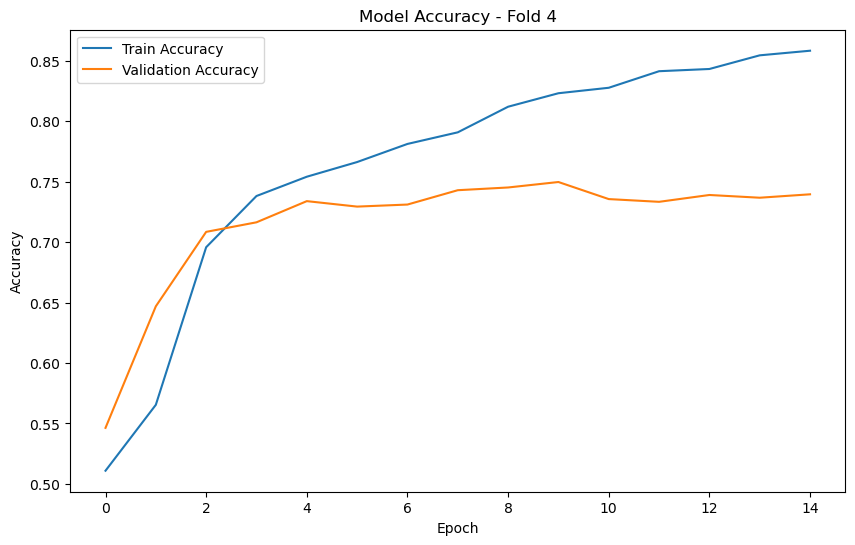

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7497
Balanced Accuracy: 0.7481
MCC: 0.4995
Sensitivity: 0.7996
Specificity: 0.6966

Learned track weights for fold 4:
Sequence weight: 0.5313
Structure weight: 0.4687

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5259 - loss: 0.6973 - val_accuracy: 0.5955 - val_loss: 0.6798 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6015 - loss: 0.6655 - val_accuracy: 0.6294 - val_loss: 0.6374 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6734 - loss: 0.6156 - val_accuracy: 0.6525 - val_loss: 0.6168 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7095 - loss: 0.5837 - val_accuracy: 0.6972 - val_loss: 0.5861 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7170 - loss: 0.5578 - val_accuracy: 0.7051 - val_loss: 0.5667 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7480 - loss: 0.5279 - val_accuracy: 0.7130 - val_loss: 0.5636 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7630 - loss: 0.5042 - val_

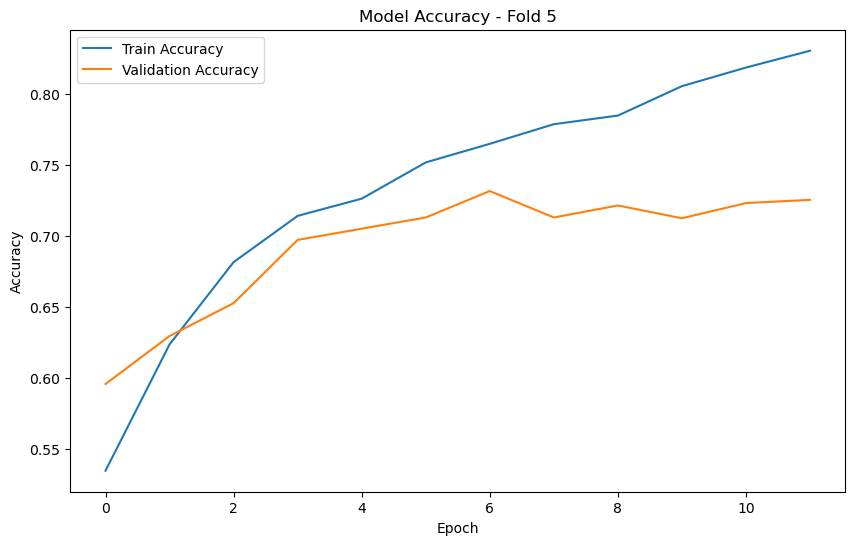

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7316
Balanced Accuracy: 0.7319
MCC: 0.4635
Sensitivity: 0.7252
Specificity: 0.7386

Learned track weights for fold 5:
Sequence weight: 0.5151
Structure weight: 0.4849

Average track weights across folds:
Sequence weight: 0.5286 ± 0.0074
Structure weight: 0.4714 ± 0.0074

Average Cross-validation Results:
ACC: 0.7441 ± 0.0122
BALANCED_ACC: 0.7429 ± 0.0103
MCC: 0.4894 ± 0.0230
SN: 0.7709 ± 0.0595
SP: 0.7148 ± 0.0413

Final Test Set Results:
Accuracy: 0.7176
Balanced Accuracy: 0.7473
MCC: 0.2970
Sensitivity: 0.7833
Specificity: 0.7113
Confusion Matrix:
[[1776  721]
 [  52  188]]


In [14]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=4)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)
y_test: (2737,)

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5196 - loss: 0.7013 - val_accuracy: 0.5638 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5696 - loss: 0.6834 - val_accuracy: 0.6424 - val_loss: 0.6607 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6388 - loss: 0.6349 - val_accuracy: 0.7158 - val_loss: 0.5770 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7169 - loss: 0.5676 - val_accuracy: 0.7486 - val_loss: 0.5341 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7479 - loss: 0.5275 - val_accuracy: 0.7463 - val_loss: 0.5501 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7629 - loss: 0.5085 - val_accuracy: 0.7339 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7744 - loss: 0.4948 - val

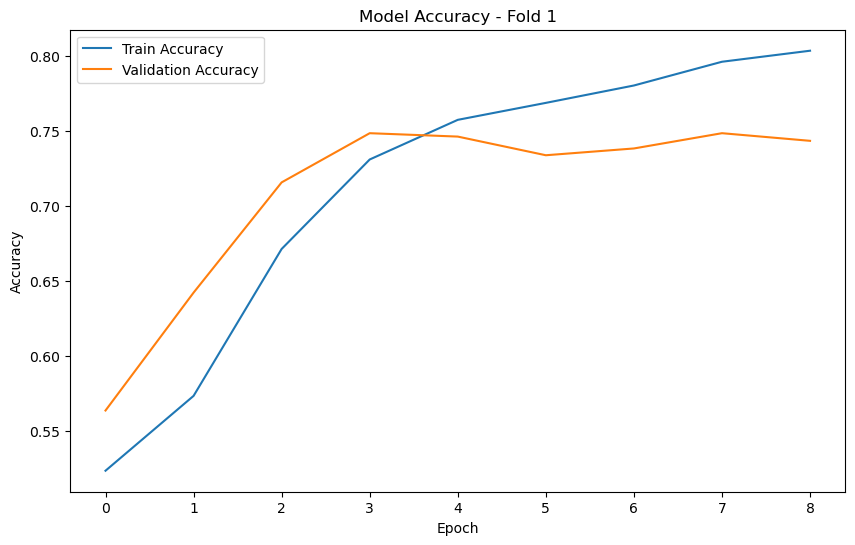

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7486
Balanced Accuracy: 0.7472
MCC: 0.4968
Sensitivity: 0.7908
Specificity: 0.7036

Learned track weights for fold 1:
Sequence weight: 0.5239
Structure weight: 0.4761

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5066 - loss: 0.7029 - val_accuracy: 0.5921 - val_loss: 0.6812 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6061 - loss: 0.6630 - val_accuracy: 0.6706 - val_loss: 0.6017 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6841 - loss: 0.5978 - val_accuracy: 0.7350 - val_loss: 0.5408 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7220 - loss: 0.5540 - val_accuracy: 0.7407 - val_loss: 0.5223 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7385 - loss: 0.5335 - val_accuracy: 0.7412 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7557 - loss: 0.5055 - val_accuracy: 0.7559 - val_loss: 0.5026 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7660 - loss: 0.4975 - val

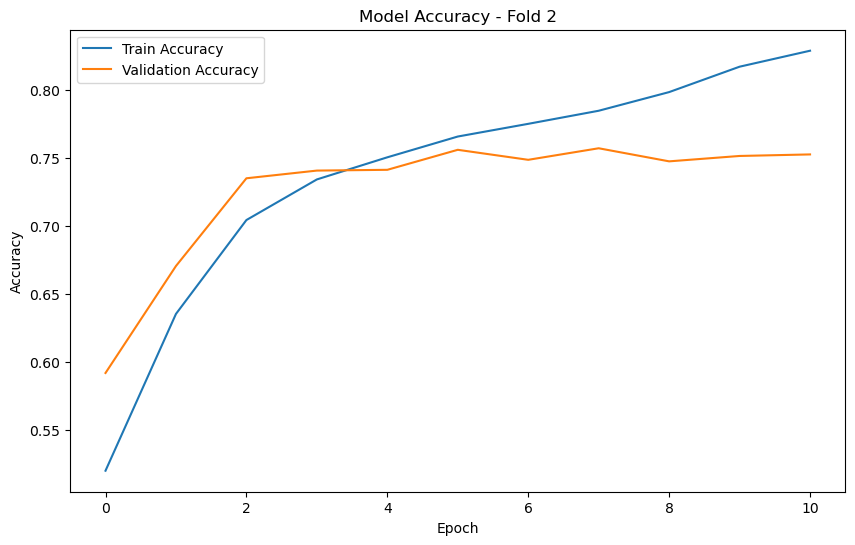

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7559
Balanced Accuracy: 0.7520
MCC: 0.5102
Sensitivity: 0.8205
Specificity: 0.6835

Learned track weights for fold 2:
Sequence weight: 0.5398
Structure weight: 0.4602

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5167 - loss: 0.7063 - val_accuracy: 0.6062 - val_loss: 0.6783 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6197 - loss: 0.6548 - val_accuracy: 0.6633 - val_loss: 0.6163 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6858 - loss: 0.5991 - val_accuracy: 0.6960 - val_loss: 0.5794 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7243 - loss: 0.5567 - val_accuracy: 0.7141 - val_loss: 0.5746 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7425 - loss: 0.5266 - val_accuracy: 0.7153 - val_loss: 0.5727 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7591 - loss: 0.5076 - val_accuracy: 0.7299 - val_loss: 0.5618 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7765 - loss: 0.4875 - val

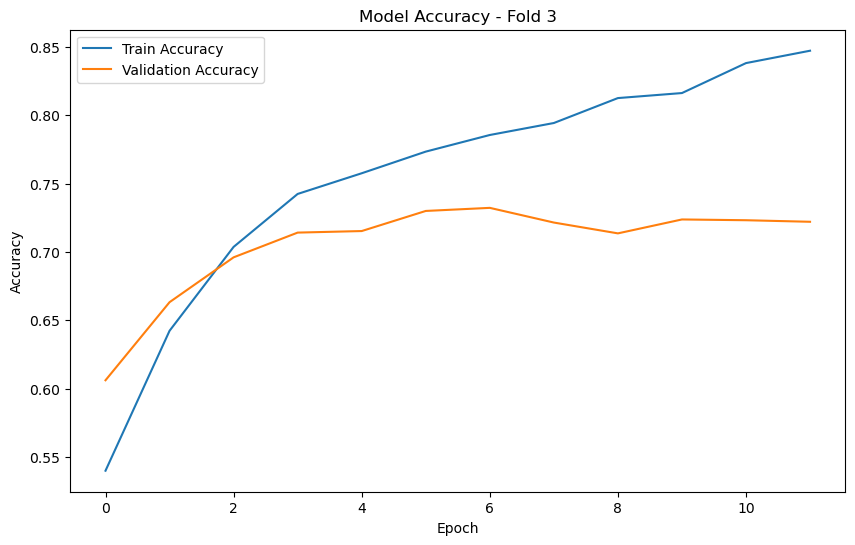

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7322
Balanced Accuracy: 0.7319
MCC: 0.4638
Sensitivity: 0.7426
Specificity: 0.7211

Learned track weights for fold 3:
Sequence weight: 0.5291
Structure weight: 0.4709

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.5077 - loss: 0.7117 - val_accuracy: 0.6011 - val_loss: 0.6889 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5727 - loss: 0.6757 - val_accuracy: 0.6390 - val_loss: 0.6459 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6366 - loss: 0.6395 - val_accuracy: 0.6729 - val_loss: 0.6139 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6813 - loss: 0.6050 - val_accuracy: 0.6808 - val_loss: 0.6006 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6991 - loss: 0.5851 - val_accuracy: 0.6887 - val_loss: 0.5889 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7207 - loss: 0.5585 - val_accuracy: 0.7017 - val_loss: 0.5803 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7396 - loss: 0.5406 - val_

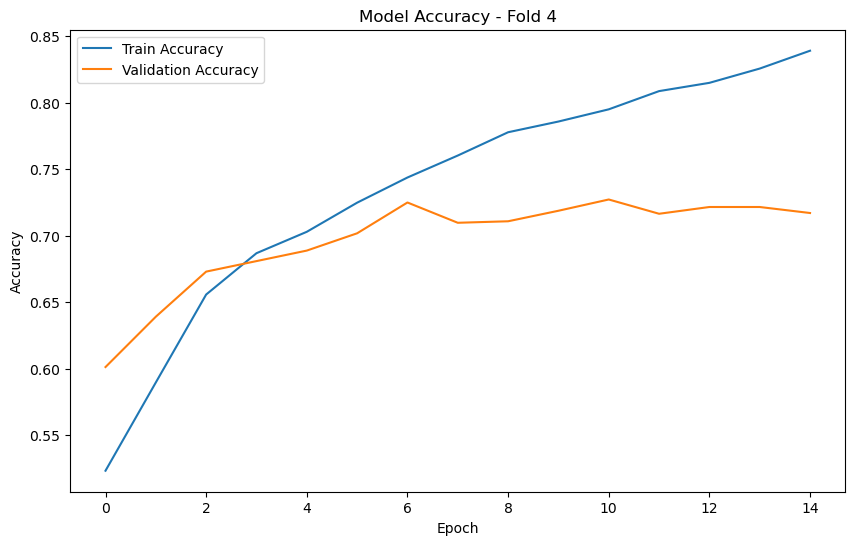

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7186
Balanced Accuracy: 0.7201
MCC: 0.4412
Sensitivity: 0.6747
Specificity: 0.7655

Learned track weights for fold 4:
Sequence weight: 0.5323
Structure weight: 0.4677

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.5553 - loss: 0.6900 - val_accuracy: 0.6339 - val_loss: 0.6657 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6277 - loss: 0.6518 - val_accuracy: 0.6599 - val_loss: 0.6198 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6840 - loss: 0.6012 - val_accuracy: 0.6910 - val_loss: 0.5852 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7296 - loss: 0.5511 - val_accuracy: 0.7362 - val_loss: 0.5394 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7486 - loss: 0.5221 - val_accuracy: 0.7328 - val_loss: 0.5365 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7616 - loss: 0.4985 - val_accuracy: 0.7373 - val_loss: 0.5337 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7735 - loss: 0.4841 - val_

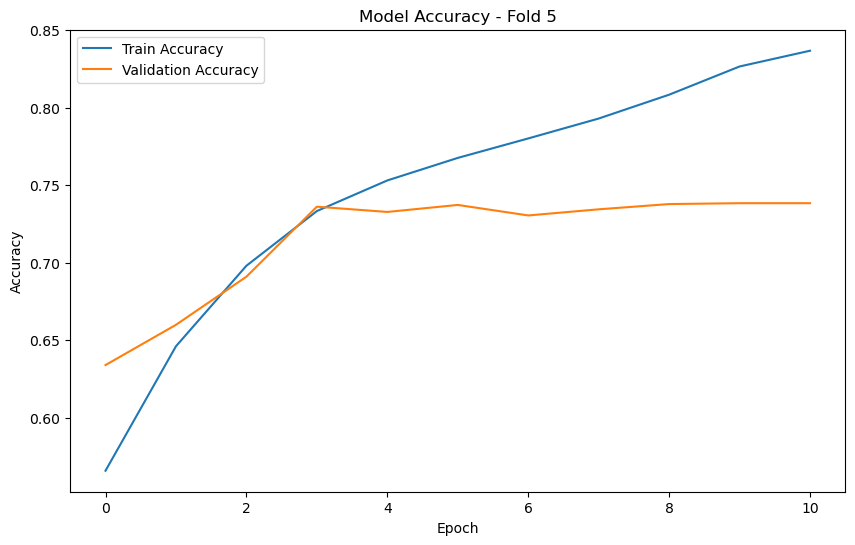

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7373
Balanced Accuracy: 0.7374
MCC: 0.4745
Sensitivity: 0.7339
Specificity: 0.7409

Learned track weights for fold 5:
Sequence weight: 0.5263
Structure weight: 0.4737

Average track weights across folds:
Sequence weight: 0.5303 ± 0.0055
Structure weight: 0.4697 ± 0.0055

Average Cross-validation Results:
ACC: 0.7385 ± 0.0130
BALANCED_ACC: 0.7377 ± 0.0113
MCC: 0.4773 ± 0.0243
SN: 0.7525 ± 0.0502
SP: 0.7229 ± 0.0285

Final Test Set Results:
Accuracy: 0.7304
Balanced Accuracy: 0.7468
MCC: 0.3002
Sensitivity: 0.7667
Specificity: 0.7269
Confusion Matrix:
[[1815  682]
 [  56  184]]


In [15]:
if __name__ == "__main__":
    model = train_and_evaluate(struct_window=5)

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)
y_test: (2737,)

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5247 - loss: 0.6941 - val_accuracy: 0.6362 - val_loss: 0.6679 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6325 - loss: 0.6475 - val_accuracy: 0.6955 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7073 - loss: 0.5757 - val_accuracy: 0.7384 - val_loss: 0.5450 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7446 - loss: 0.5298 - val_accuracy: 0.7458 - val_loss: 0.5255 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7528 - loss: 0.5118 - val_accuracy: 0.7508 - val_loss: 0.5180 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7784 - loss: 0.4843 - val_accuracy: 0.7463 - val_loss: 0.5238 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7838 - loss: 0.4730 - val

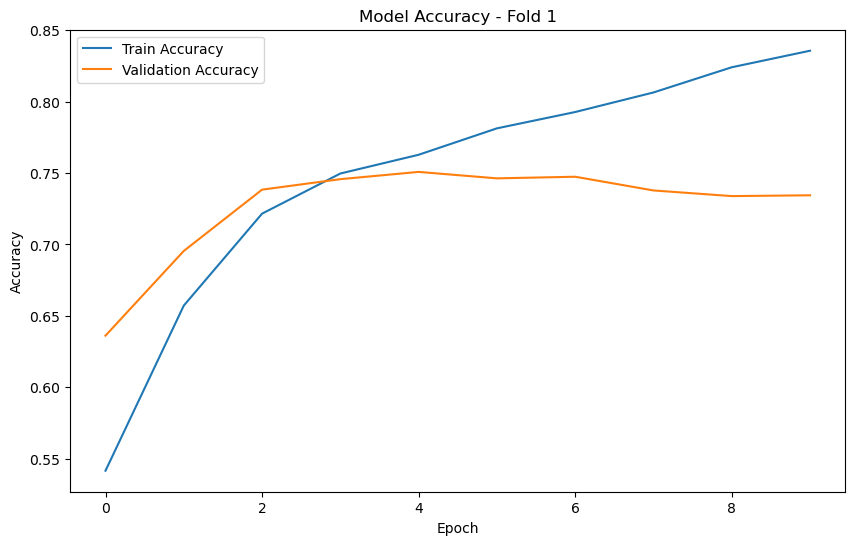

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7508
Balanced Accuracy: 0.7491
MCC: 0.5019
Sensitivity: 0.8039
Specificity: 0.6943

Learned track weights for fold 1:
Sequence weight: 0.5317
Structure weight: 0.4683

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5202 - loss: 0.6974 - val_accuracy: 0.5695 - val_loss: 0.6880 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5467 - loss: 0.6824 - val_accuracy: 0.5797 - val_loss: 0.6768 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5656 - loss: 0.6726 - val_accuracy: 0.6373 - val_loss: 0.6547 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6391 - loss: 0.6334 - val_accuracy: 0.7119 - val_loss: 0.5781 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7151 - loss: 0.5756 - val_accuracy: 0.7452 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7352 - loss: 0.5414 - val_accuracy: 0.7486 - val_loss: 0.5170 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7589 - loss: 0.5101 - val

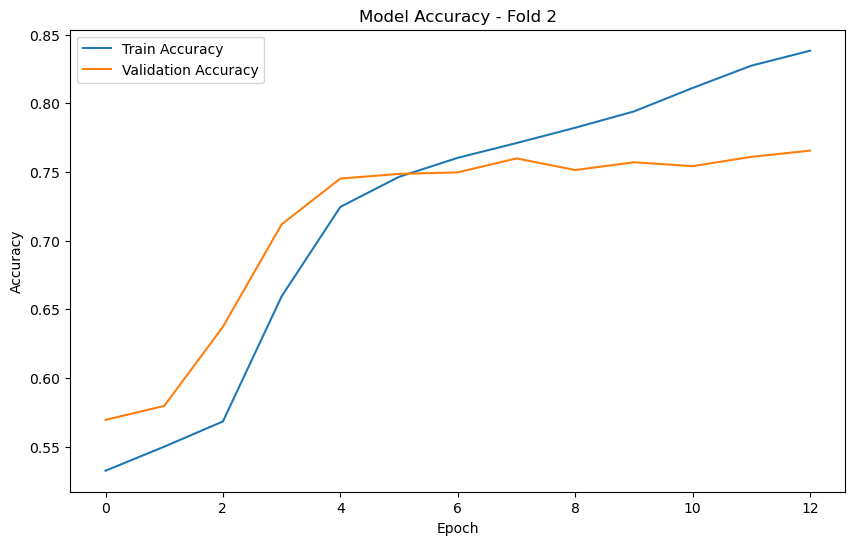

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7599
Balanced Accuracy: 0.7568
MCC: 0.5176
Sensitivity: 0.8098
Specificity: 0.7038

Learned track weights for fold 2:
Sequence weight: 0.5197
Structure weight: 0.4803

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5181 - loss: 0.7023 - val_accuracy: 0.5819 - val_loss: 0.6835 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6071 - loss: 0.6693 - val_accuracy: 0.6599 - val_loss: 0.6255 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6684 - loss: 0.6047 - val_accuracy: 0.6989 - val_loss: 0.5886 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7156 - loss: 0.5572 - val_accuracy: 0.7209 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7271 - loss: 0.5420 - val_accuracy: 0.7418 - val_loss: 0.5477 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7426 - loss: 0.5144 - val_accuracy: 0.7412 - val_loss: 0.5538 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7578 - loss: 0.4946 - val

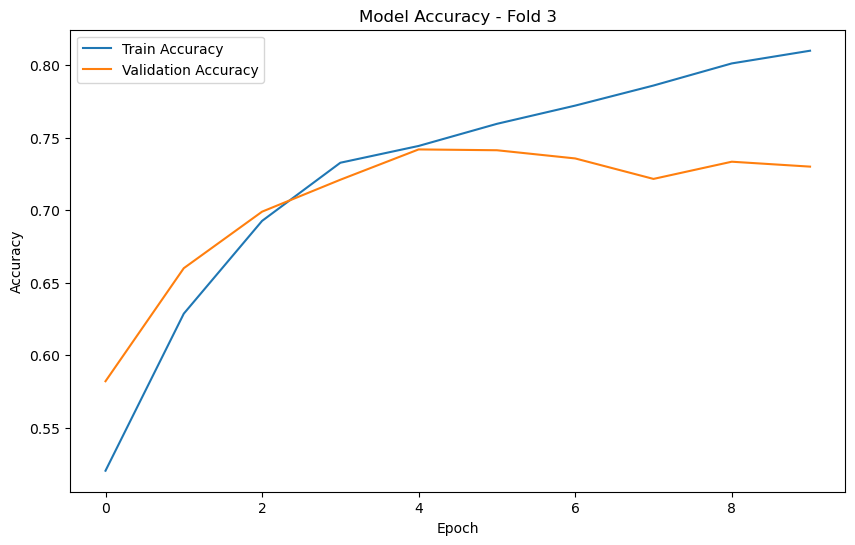

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7418
Balanced Accuracy: 0.7420
MCC: 0.4838
Sensitivity: 0.7360
Specificity: 0.7480

Learned track weights for fold 3:
Sequence weight: 0.5313
Structure weight: 0.4687

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5175 - loss: 0.6954 - val_accuracy: 0.5876 - val_loss: 0.6772 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5924 - loss: 0.6699 - val_accuracy: 0.6288 - val_loss: 0.6381 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6826 - loss: 0.6008 - val_accuracy: 0.6966 - val_loss: 0.5767 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7325 - loss: 0.5510 - val_accuracy: 0.7277 - val_loss: 0.5442 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7516 - loss: 0.5177 - val_accuracy: 0.7192 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7700 - loss: 0.4983 - val_accuracy: 0.7305 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7835 - loss: 0.4794 - val

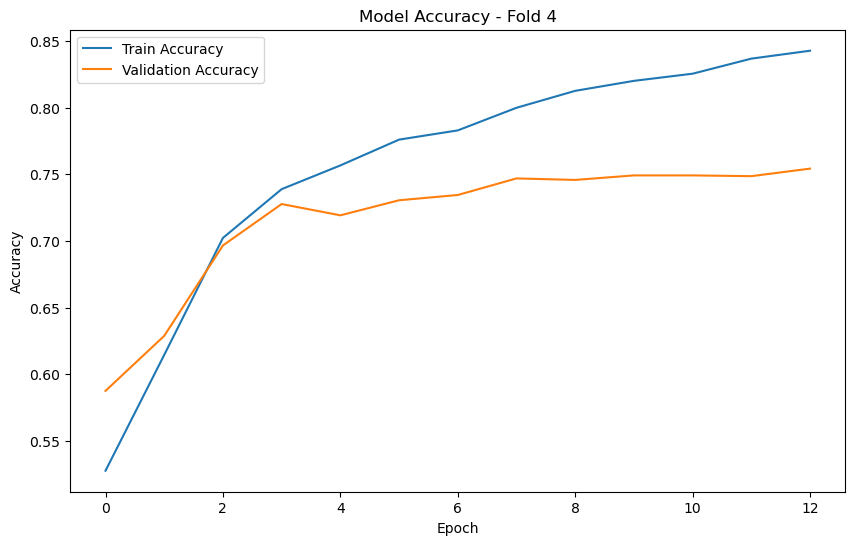

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7451
MCC: 0.4940
Sensitivity: 0.8007
Specificity: 0.6896

Learned track weights for fold 4:
Sequence weight: 0.5203
Structure weight: 0.4797

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5184 - loss: 0.7037 - val_accuracy: 0.5757 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6001 - loss: 0.6669 - val_accuracy: 0.6339 - val_loss: 0.6377 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6556 - loss: 0.6288 - val_accuracy: 0.6593 - val_loss: 0.6169 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6880 - loss: 0.5915 - val_accuracy: 0.6661 - val_loss: 0.6040 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7174 - loss: 0.5648 - val_accuracy: 0.7017 - val_loss: 0.5770 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7355 - loss: 0.5406 - val_accuracy: 0.7181 - val_loss: 0.5508 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7566 - loss: 0.5137 - val

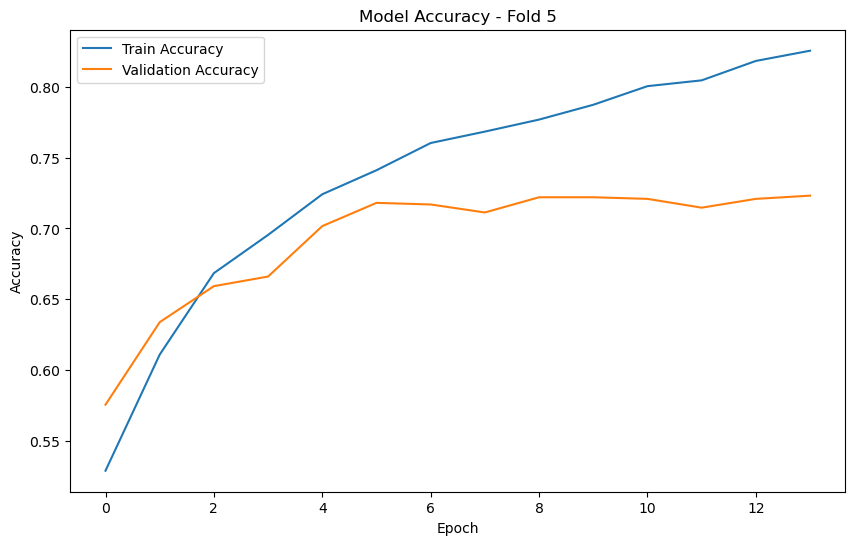

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7220
Balanced Accuracy: 0.7224
MCC: 0.4445
Sensitivity: 0.7121
Specificity: 0.7327

Learned track weights for fold 5:
Sequence weight: 0.5276
Structure weight: 0.4724

Average track weights across folds:
Sequence weight: 0.5261 ± 0.0052
Structure weight: 0.4739 ± 0.0052

Average Cross-validation Results:
ACC: 0.7443 ± 0.0126
BALANCED_ACC: 0.7431 ± 0.0115
MCC: 0.4884 ± 0.0245
SN: 0.7725 ± 0.0404
SP: 0.7137 ± 0.0228

Final Test Set Results:
Accuracy: 0.7183
Balanced Accuracy: 0.7345
MCC: 0.2829
Sensitivity: 0.7542
Specificity: 0.7149
Confusion Matrix:
[[1785  712]
 [  59  181]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5213 - loss: 0.7027 - val_accuracy: 0.5655 - val_loss: 0.6824 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5736 - loss: 0.6809 - val_accuracy: 0.6734 - val_loss: 0.6198 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6613 - loss: 0.6259 - val_accuracy: 0.7040 - val_loss: 0.5840 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7091 - loss: 0.5752 - val_accuracy: 0.7339 - val_loss: 0.5421 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7404 - loss: 0.5351 - val_accuracy: 0.7463 - val_loss: 0.5312 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7558 - loss: 0.5121 - val_accuracy: 0.7418 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7686 - loss: 0.4967 - val

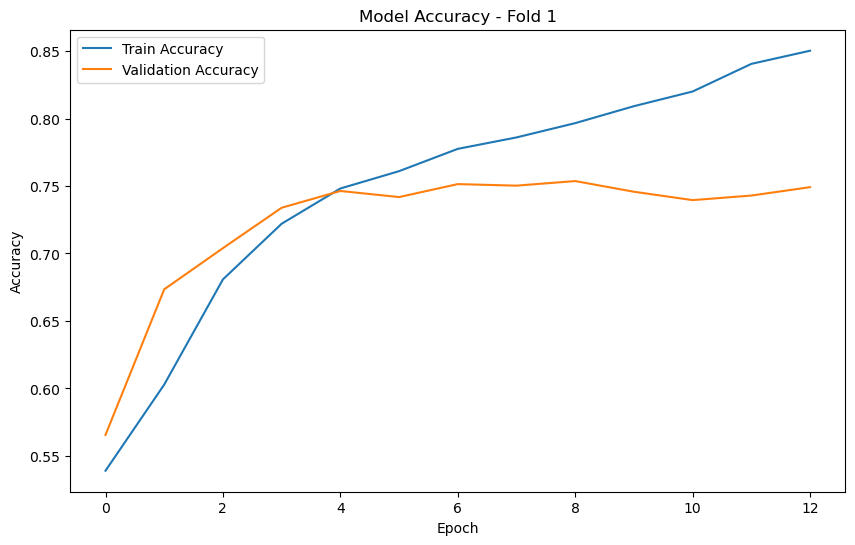

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7503
Balanced Accuracy: 0.7486
MCC: 0.5007
Sensitivity: 0.8018
Specificity: 0.6954

Learned track weights for fold 1:
Sequence weight: 0.5294
Structure weight: 0.4706

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5187 - loss: 0.7056 - val_accuracy: 0.5689 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5765 - loss: 0.6800 - val_accuracy: 0.6593 - val_loss: 0.6270 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6803 - loss: 0.6120 - val_accuracy: 0.7147 - val_loss: 0.5665 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7170 - loss: 0.5659 - val_accuracy: 0.7322 - val_loss: 0.5444 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7439 - loss: 0.5312 - val_accuracy: 0.7401 - val_loss: 0.5229 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7577 - loss: 0.5153 - val_accuracy: 0.7401 - val_loss: 0.5214 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7711 - loss: 0.4912 - val

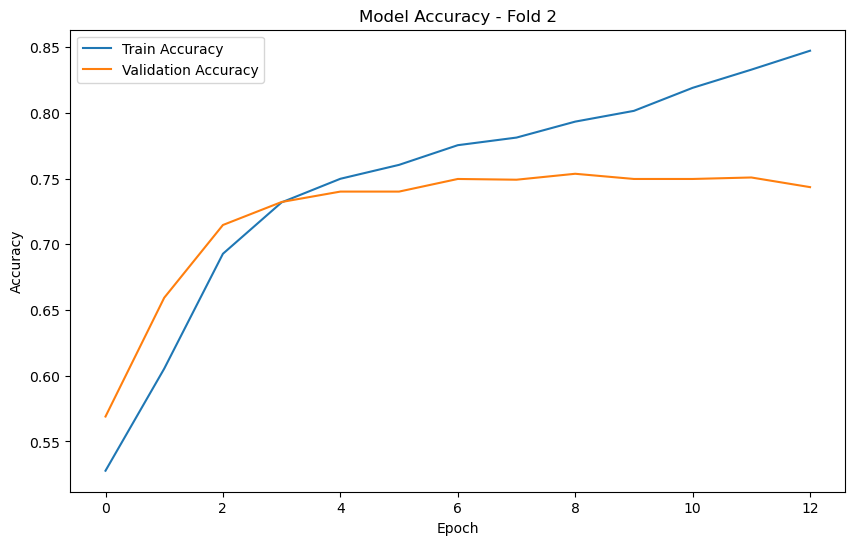

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7492
Balanced Accuracy: 0.7460
MCC: 0.4959
Sensitivity: 0.8002
Specificity: 0.6918

Learned track weights for fold 2:
Sequence weight: 0.5320
Structure weight: 0.4680

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5375 - loss: 0.7027 - val_accuracy: 0.6215 - val_loss: 0.6705 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6284 - loss: 0.6527 - val_accuracy: 0.6520 - val_loss: 0.6207 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6756 - loss: 0.6104 - val_accuracy: 0.6791 - val_loss: 0.5986 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6944 - loss: 0.5802 - val_accuracy: 0.6977 - val_loss: 0.5812 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7262 - loss: 0.5453 - val_accuracy: 0.7085 - val_loss: 0.5694 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7525 - loss: 0.5187 - val_accuracy: 0.7141 - val_loss: 0.5623 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7590 - loss: 0.5000 - val

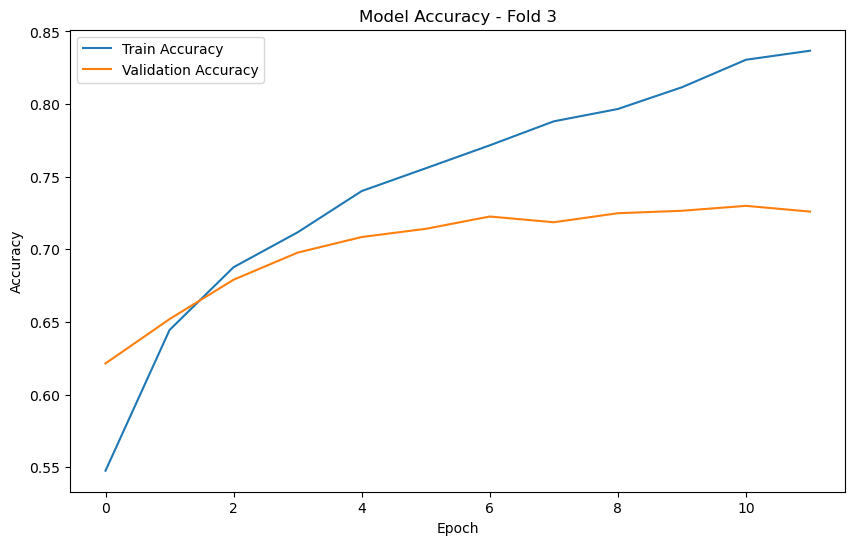

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7226
Balanced Accuracy: 0.7245
MCC: 0.4512
Sensitivity: 0.6648
Specificity: 0.7841

Learned track weights for fold 3:
Sequence weight: 0.5355
Structure weight: 0.4645

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5363 - loss: 0.6977 - val_accuracy: 0.5994 - val_loss: 0.6750 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6237 - loss: 0.6559 - val_accuracy: 0.6689 - val_loss: 0.6252 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6882 - loss: 0.6004 - val_accuracy: 0.6859 - val_loss: 0.5995 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7231 - loss: 0.5654 - val_accuracy: 0.7141 - val_loss: 0.5704 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7506 - loss: 0.5296 - val_accuracy: 0.7113 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7590 - loss: 0.5089 - val_accuracy: 0.7288 - val_loss: 0.5561 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7748 - loss: 0.4862 - val

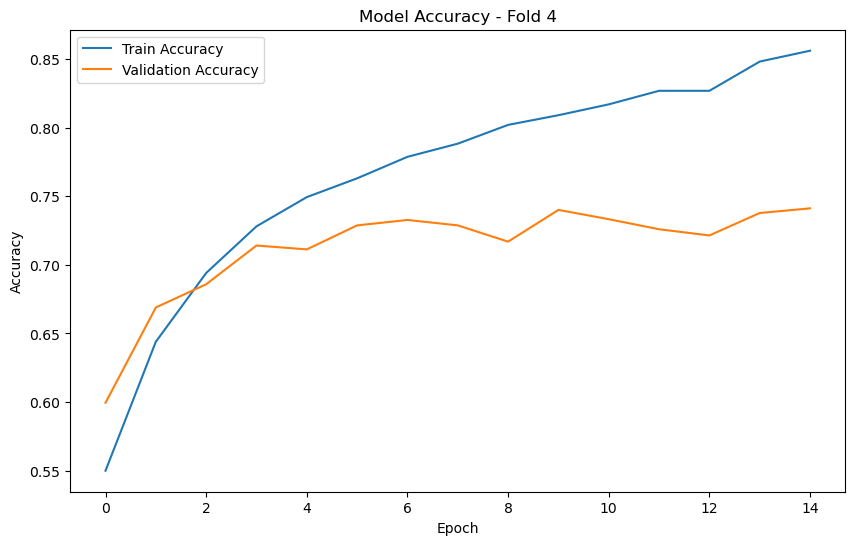

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7401
Balanced Accuracy: 0.7402
MCC: 0.4801
Sensitivity: 0.7382
Specificity: 0.7421

Learned track weights for fold 4:
Sequence weight: 0.5215
Structure weight: 0.4785

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.5140 - loss: 0.7046 - val_accuracy: 0.5531 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5511 - loss: 0.6825 - val_accuracy: 0.6418 - val_loss: 0.6395 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6561 - loss: 0.6311 - val_accuracy: 0.6836 - val_loss: 0.5983 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7118 - loss: 0.5781 - val_accuracy: 0.7113 - val_loss: 0.5675 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7414 - loss: 0.5428 - val_accuracy: 0.7294 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7567 - loss: 0.5132 - val_accuracy: 0.7271 - val_loss: 0.5336 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7722 - loss: 0.4867 - val

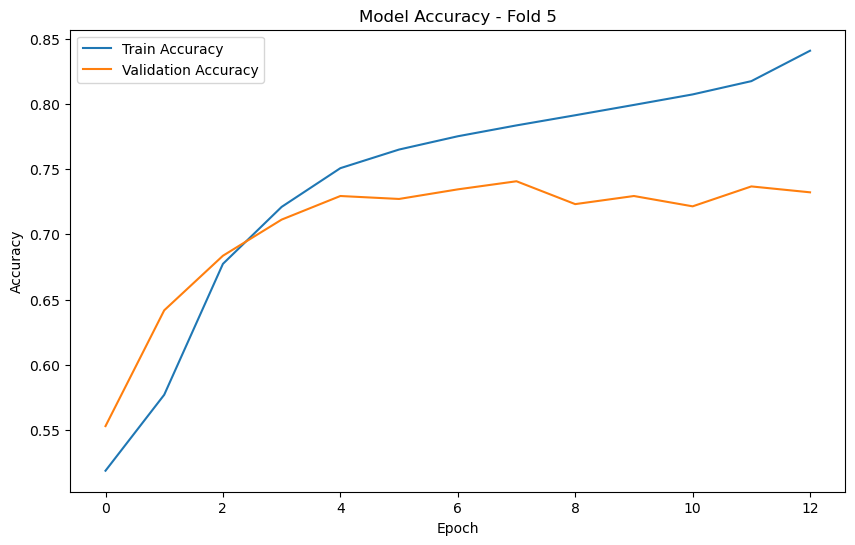

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7407
Balanced Accuracy: 0.7404
MCC: 0.4807
Sensitivity: 0.7492
Specificity: 0.7315

Learned track weights for fold 5:
Sequence weight: 0.5275
Structure weight: 0.4725

Average track weights across folds:
Sequence weight: 0.5292 ± 0.0047
Structure weight: 0.4708 ± 0.0047

Average Cross-validation Results:
ACC: 0.7406 ± 0.0099
BALANCED_ACC: 0.7399 ± 0.0084
MCC: 0.4817 ± 0.0173
SN: 0.7508 ± 0.0502
SP: 0.7290 ± 0.0338

Final Test Set Results:
Accuracy: 0.7428
Balanced Accuracy: 0.7573
MCC: 0.3161
Sensitivity: 0.7750
Specificity: 0.7397
Confusion Matrix:
[[1847  650]
 [  54  186]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5041 - loss: 0.7044 - val_accuracy: 0.5514 - val_loss: 0.6901 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5892 - loss: 0.6705 - val_accuracy: 0.6847 - val_loss: 0.6179 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6787 - loss: 0.6103 - val_accuracy: 0.7282 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7200 - loss: 0.5567 - val_accuracy: 0.7333 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7514 - loss: 0.5288 - val_accuracy: 0.7424 - val_loss: 0.5329 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7634 - loss: 0.5107 - val_accuracy: 0.7384 - val_loss: 0.5275 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7812 - loss: 0.4857 - val

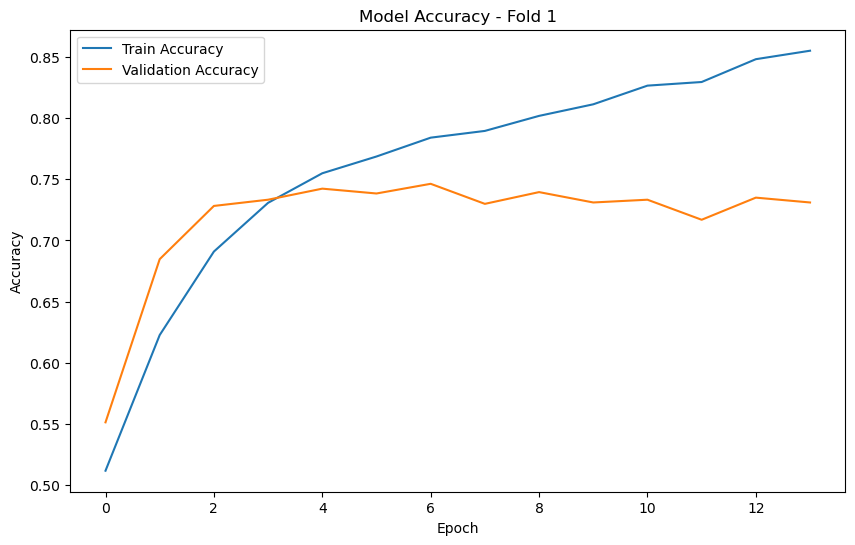

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7395
Balanced Accuracy: 0.7363
MCC: 0.4843
Sensitivity: 0.8390
Specificity: 0.6336

Learned track weights for fold 1:
Sequence weight: 0.5355
Structure weight: 0.4645

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5181 - loss: 0.6984 - val_accuracy: 0.6186 - val_loss: 0.6589 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6370 - loss: 0.6459 - val_accuracy: 0.6791 - val_loss: 0.5939 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6983 - loss: 0.5924 - val_accuracy: 0.7401 - val_loss: 0.5372 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7272 - loss: 0.5477 - val_accuracy: 0.7401 - val_loss: 0.5257 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7402 - loss: 0.5279 - val_accuracy: 0.7475 - val_loss: 0.5202 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7532 - loss: 0.5105 - val_accuracy: 0.7429 - val_loss: 0.5157 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7608 - loss: 0.4983 - val

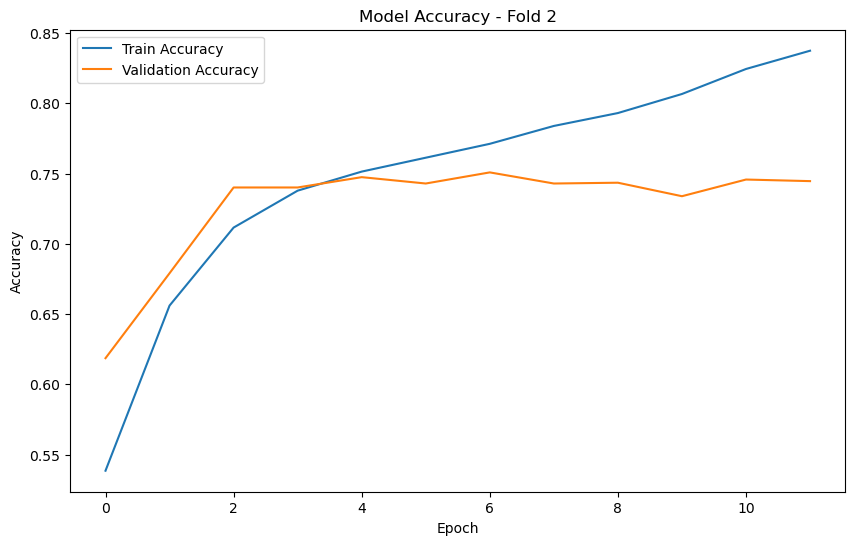

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7508
Balanced Accuracy: 0.7488
MCC: 0.4993
Sensitivity: 0.7842
Specificity: 0.7134

Learned track weights for fold 2:
Sequence weight: 0.5423
Structure weight: 0.4577

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.5071 - loss: 0.7099 - val_accuracy: 0.6124 - val_loss: 0.6767 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6134 - loss: 0.6636 - val_accuracy: 0.6514 - val_loss: 0.6324 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6786 - loss: 0.6043 - val_accuracy: 0.6927 - val_loss: 0.5851 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7200 - loss: 0.5620 - val_accuracy: 0.7164 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7390 - loss: 0.5365 - val_accuracy: 0.7226 - val_loss: 0.5620 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7499 - loss: 0.5221 - val_accuracy: 0.7243 - val_loss: 0.5735 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7603 - loss: 0.4990 - val

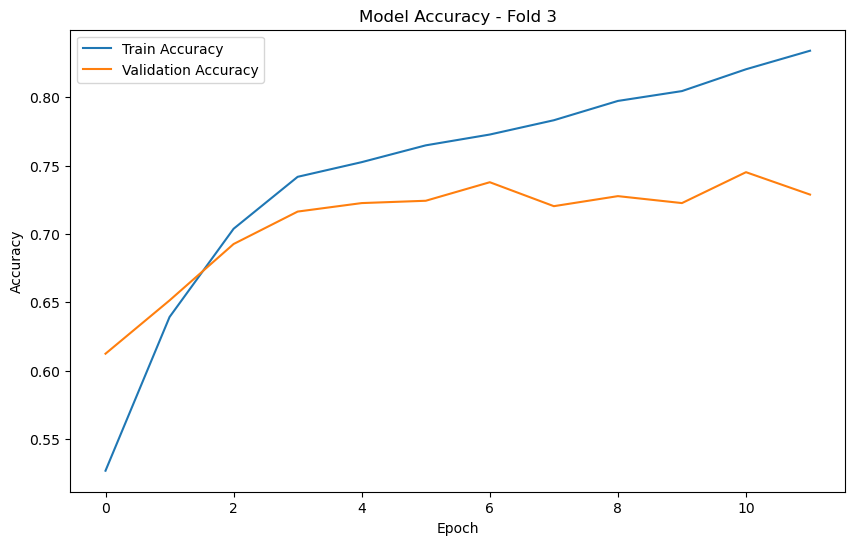

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7379
Balanced Accuracy: 0.7392
MCC: 0.4793
Sensitivity: 0.6966
Specificity: 0.7818

Learned track weights for fold 3:
Sequence weight: 0.5294
Structure weight: 0.4706

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.5159 - loss: 0.7019 - val_accuracy: 0.5610 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5982 - loss: 0.6707 - val_accuracy: 0.6446 - val_loss: 0.6417 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6621 - loss: 0.6212 - val_accuracy: 0.6808 - val_loss: 0.6091 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7080 - loss: 0.5732 - val_accuracy: 0.6989 - val_loss: 0.5847 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7428 - loss: 0.5344 - val_accuracy: 0.7068 - val_loss: 0.5685 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7578 - loss: 0.5089 - val_accuracy: 0.7102 - val_loss: 0.5680 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7677 - loss: 0.4886 - val

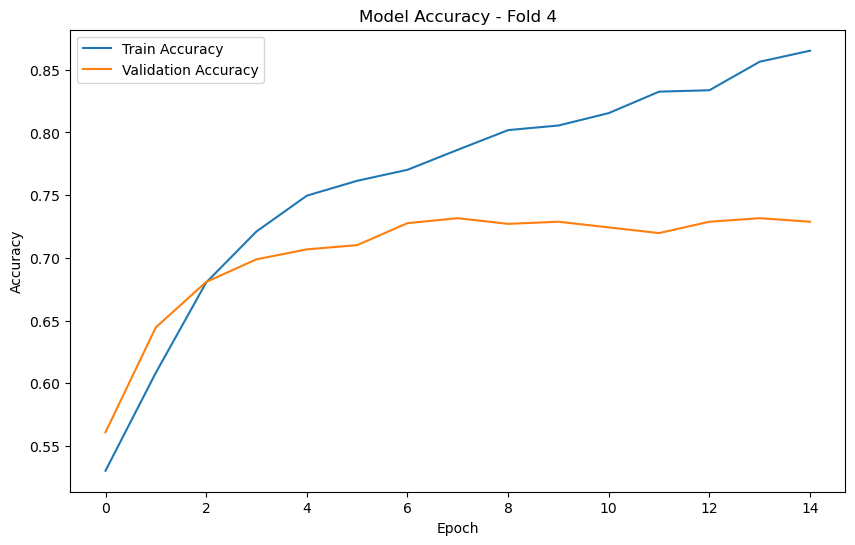

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7288
Balanced Accuracy: 0.7300
MCC: 0.4605
Sensitivity: 0.6933
Specificity: 0.7666

Learned track weights for fold 4:
Sequence weight: 0.5272
Structure weight: 0.4728

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5432 - loss: 0.6951 - val_accuracy: 0.5689 - val_loss: 0.6810 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5882 - loss: 0.6702 - val_accuracy: 0.6390 - val_loss: 0.6367 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6749 - loss: 0.6133 - val_accuracy: 0.6825 - val_loss: 0.5969 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7257 - loss: 0.5552 - val_accuracy: 0.7169 - val_loss: 0.5479 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7496 - loss: 0.5193 - val_accuracy: 0.7254 - val_loss: 0.5450 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7670 - loss: 0.5066 - val_accuracy: 0.7260 - val_loss: 0.5374 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7780 - loss: 0.4789 - val

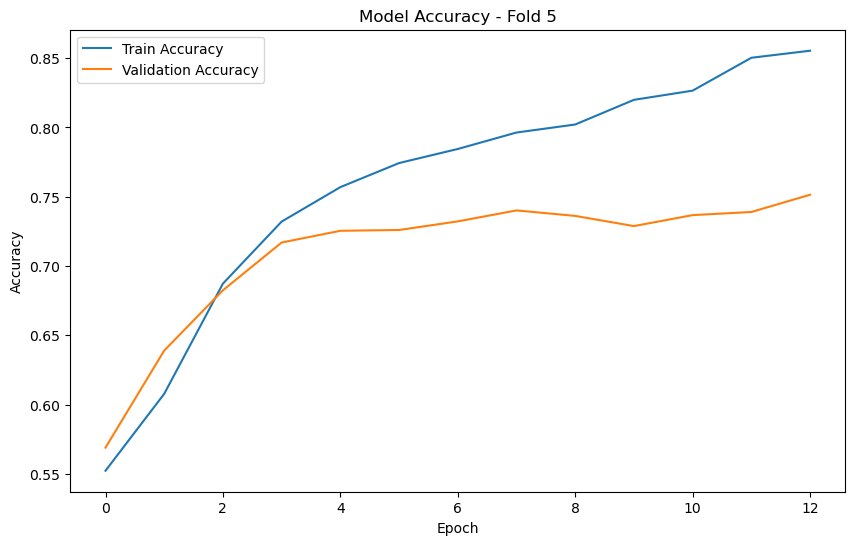

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7401
Balanced Accuracy: 0.7403
MCC: 0.4803
Sensitivity: 0.7350
Specificity: 0.7456

Learned track weights for fold 5:
Sequence weight: 0.5239
Structure weight: 0.4761

Average track weights across folds:
Sequence weight: 0.5316 ± 0.0066
Structure weight: 0.4684 ± 0.0066

Average Cross-validation Results:
ACC: 0.7394 ± 0.0070
BALANCED_ACC: 0.7389 ± 0.0061
MCC: 0.4807 ± 0.0124
SN: 0.7496 ± 0.0555
SP: 0.7282 ± 0.0526

Final Test Set Results:
Accuracy: 0.7457
Balanced Accuracy: 0.7514
MCC: 0.3105
Sensitivity: 0.7583
Specificity: 0.7445
Confusion Matrix:
[[1859  638]
 [  58  182]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.5116 - loss: 0.7043 - val_accuracy: 0.6508 - val_loss: 0.6639 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.6450 - loss: 0.6326 - val_accuracy: 0.7102 - val_loss: 0.5691 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.7178 - loss: 0.5626 - val_accuracy: 0.7288 - val_loss: 0.5416 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7448 - loss: 0.5318 - val_accuracy: 0.7463 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7486 - loss: 0.5173 - val_accuracy: 0.7469 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.7607 - loss: 0.5050 - val_accuracy: 0.7469 - val_loss: 0.5168 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7793 - loss: 0.4807 - val

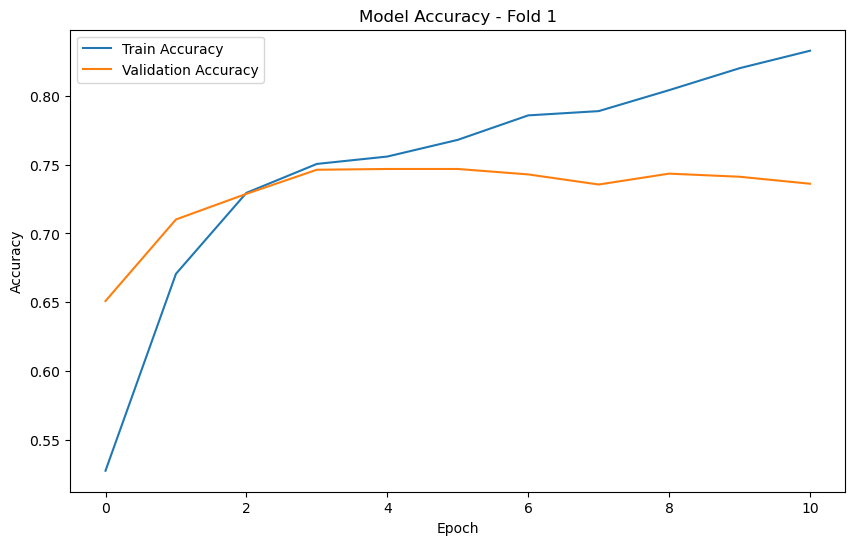

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7463
MCC: 0.4931
Sensitivity: 0.7645
Specificity: 0.7281

Learned track weights for fold 1:
Sequence weight: 0.5463
Structure weight: 0.4537

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5216 - loss: 0.6935 - val_accuracy: 0.5633 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5766 - loss: 0.6841 - val_accuracy: 0.6548 - val_loss: 0.6342 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6546 - loss: 0.6288 - val_accuracy: 0.6989 - val_loss: 0.5847 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7111 - loss: 0.5747 - val_accuracy: 0.7429 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7328 - loss: 0.5455 - val_accuracy: 0.7508 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7592 - loss: 0.5120 - val_accuracy: 0.7407 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7620 - loss: 0.4979 - val

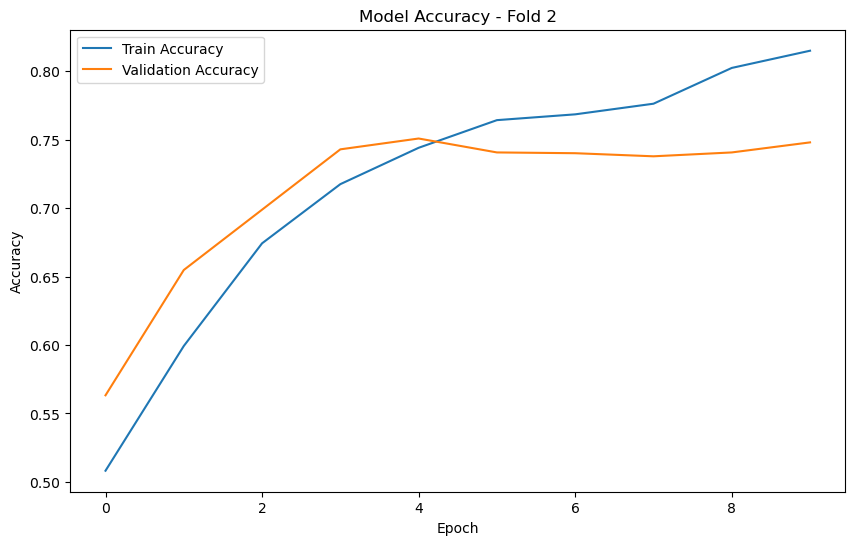

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7508
Balanced Accuracy: 0.7487
MCC: 0.4992
Sensitivity: 0.7863
Specificity: 0.7110

Learned track weights for fold 2:
Sequence weight: 0.5276
Structure weight: 0.4724

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5312 - loss: 0.7047 - val_accuracy: 0.5503 - val_loss: 0.6844 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5778 - loss: 0.6721 - val_accuracy: 0.6633 - val_loss: 0.6233 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6575 - loss: 0.6230 - val_accuracy: 0.6684 - val_loss: 0.6094 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7026 - loss: 0.5934 - val_accuracy: 0.7056 - val_loss: 0.5795 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7222 - loss: 0.5544 - val_accuracy: 0.7141 - val_loss: 0.5651 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7392 - loss: 0.5304 - val_accuracy: 0.7220 - val_loss: 0.5645 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7626 - loss: 0.5055 - val

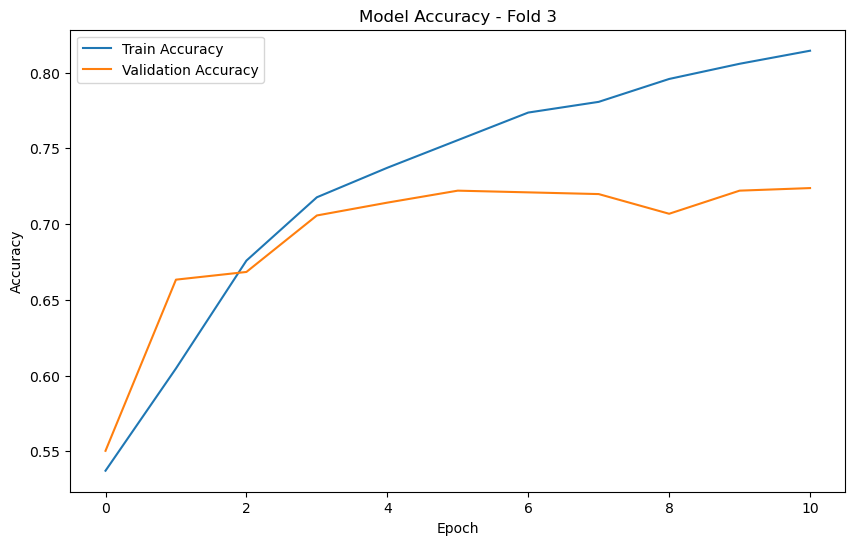

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7220
Balanced Accuracy: 0.7238
MCC: 0.4495
Sensitivity: 0.6681
Specificity: 0.7795

Learned track weights for fold 3:
Sequence weight: 0.5304
Structure weight: 0.4696

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.5357 - loss: 0.7061 - val_accuracy: 0.5418 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.5974 - loss: 0.6770 - val_accuracy: 0.6469 - val_loss: 0.6415 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6765 - loss: 0.6273 - val_accuracy: 0.6757 - val_loss: 0.6082 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6954 - loss: 0.5929 - val_accuracy: 0.6842 - val_loss: 0.5937 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7184 - loss: 0.5559 - val_accuracy: 0.7090 - val_loss: 0.5793 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7410 - loss: 0.5259 - val_accuracy: 0.7017 - val_loss: 0.5967 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7618 - loss: 0.5062 - val

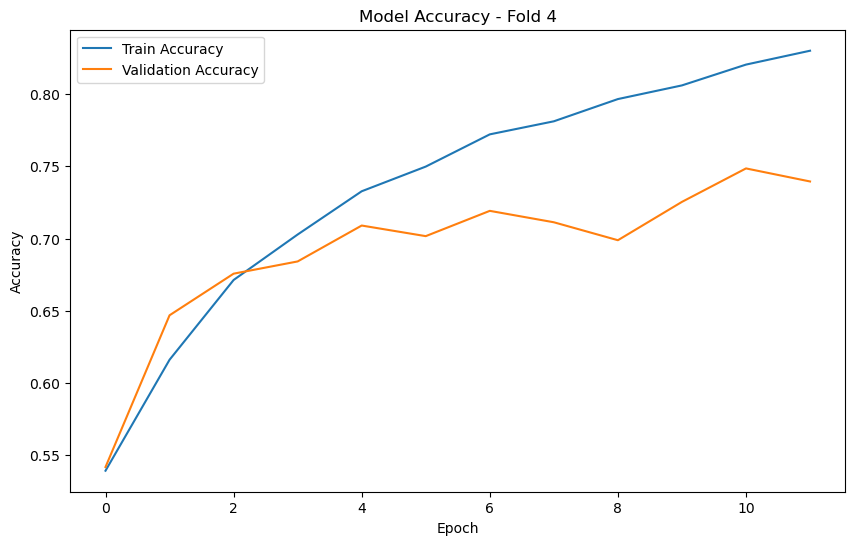

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7192
Balanced Accuracy: 0.7218
MCC: 0.4485
Sensitivity: 0.6396
Specificity: 0.8040

Learned track weights for fold 4:
Sequence weight: 0.5370
Structure weight: 0.4630

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5214 - loss: 0.6994 - val_accuracy: 0.5328 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5366 - loss: 0.6884 - val_accuracy: 0.6186 - val_loss: 0.6456 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6555 - loss: 0.6335 - val_accuracy: 0.6582 - val_loss: 0.6168 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6892 - loss: 0.5972 - val_accuracy: 0.6915 - val_loss: 0.5818 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7239 - loss: 0.5571 - val_accuracy: 0.7339 - val_loss: 0.5552 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7464 - loss: 0.5207 - val_accuracy: 0.7395 - val_loss: 0.5509 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7700 - loss: 0.4940 - val

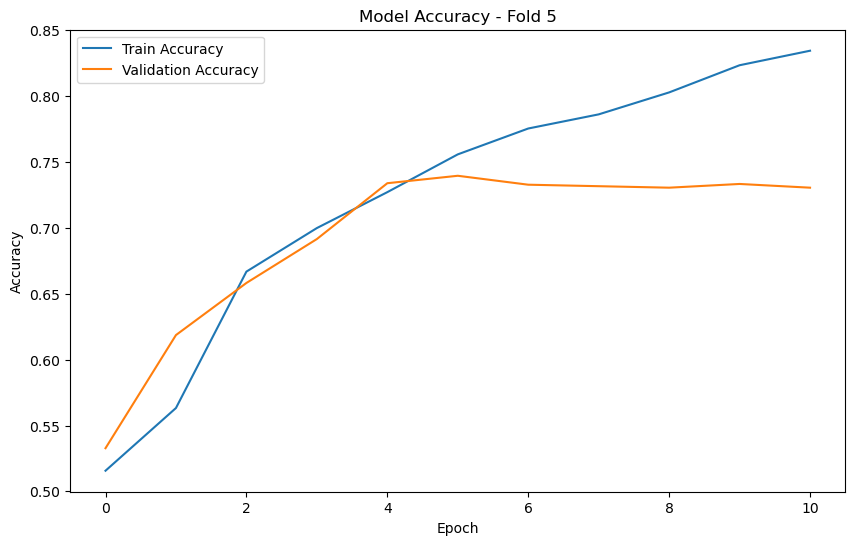

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 5 Results:
Accuracy: 0.7395
Balanced Accuracy: 0.7373
MCC: 0.4792
Sensitivity: 0.8004
Specificity: 0.6741

Learned track weights for fold 5:
Sequence weight: 0.5276
Structure weight: 0.4724

Average track weights across folds:
Sequence weight: 0.5338 ± 0.0071
Structure weight: 0.4662 ± 0.0071

Average Cross-validation Results:
ACC: 0.7357 ± 0.0129
BALANCED_ACC: 0.7356 ± 0.0111
MCC: 0.4739 ± 0.0213
SN: 0.7318 ± 0.0653
SP: 0.7393 ± 0.0468

Final Test Set Results:
Accuracy: 0.7391
Balanced Accuracy: 0.7346
MCC: 0.2893
Sensitivity: 0.7292
Specificity: 0.7401
Confusion Matrix:
[[1848  649]
 [  65  175]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5182 - loss: 0.6964 - val_accuracy: 0.5610 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5633 - loss: 0.6834 - val_accuracy: 0.6729 - val_loss: 0.6292 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6590 - loss: 0.6318 - val_accuracy: 0.7023 - val_loss: 0.6021 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6969 - loss: 0.5924 - val_accuracy: 0.7220 - val_loss: 0.5696 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7261 - loss: 0.5578 - val_accuracy: 0.7305 - val_loss: 0.5407 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7399 - loss: 0.5341 - val_accuracy: 0.7390 - val_loss: 0.5390 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.7562 - loss: 0.5133 - val

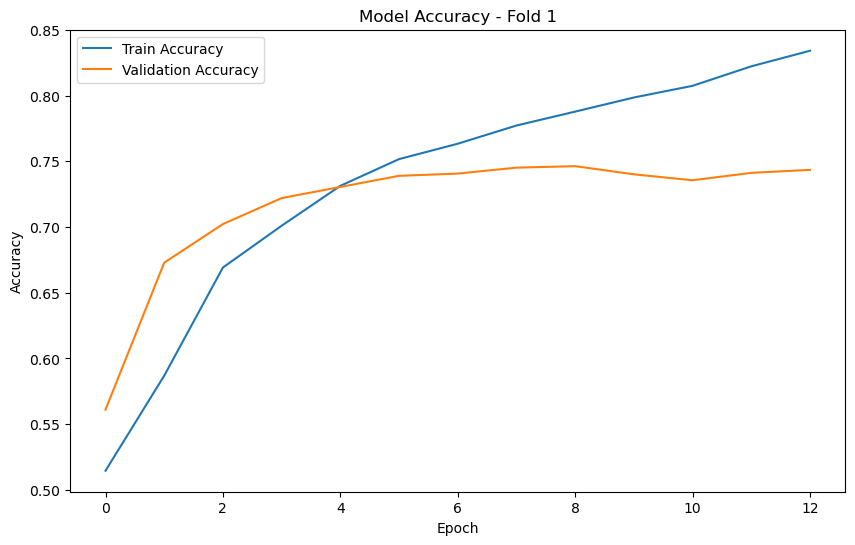

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7452
Balanced Accuracy: 0.7430
MCC: 0.4918
Sensitivity: 0.8138
Specificity: 0.6721

Learned track weights for fold 1:
Sequence weight: 0.5287
Structure weight: 0.4713

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.5221 - loss: 0.6998 - val_accuracy: 0.5876 - val_loss: 0.6822 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5797 - loss: 0.6820 - val_accuracy: 0.6367 - val_loss: 0.6376 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6542 - loss: 0.6344 - val_accuracy: 0.6853 - val_loss: 0.6003 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7030 - loss: 0.5820 - val_accuracy: 0.7260 - val_loss: 0.5533 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7348 - loss: 0.5346 - val_accuracy: 0.7407 - val_loss: 0.5360 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7446 - loss: 0.5207 - val_accuracy: 0.7452 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7595 - loss: 0.5053 - val

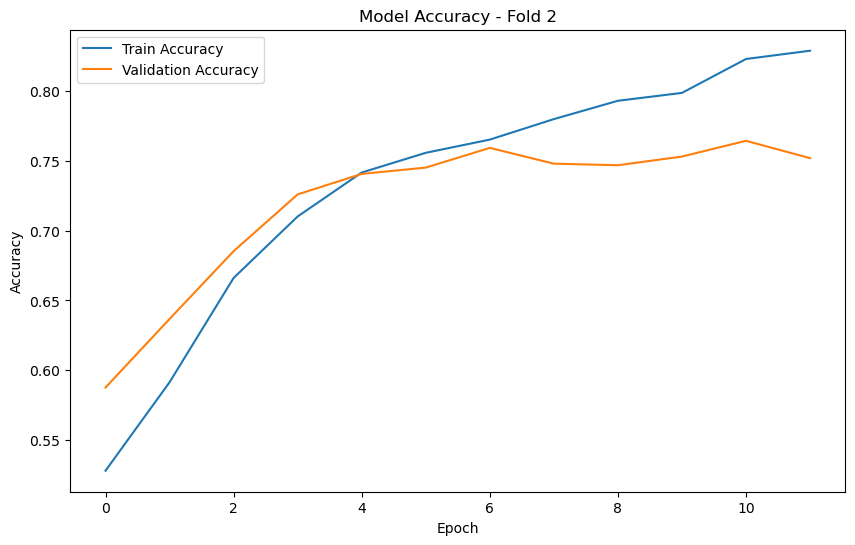

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7593
Balanced Accuracy: 0.7564
MCC: 0.5164
Sensitivity: 0.8066
Specificity: 0.7062

Learned track weights for fold 2:
Sequence weight: 0.5179
Structure weight: 0.4821

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5327 - loss: 0.6955 - val_accuracy: 0.5655 - val_loss: 0.6735 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6218 - loss: 0.6537 - val_accuracy: 0.6797 - val_loss: 0.6177 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6851 - loss: 0.6025 - val_accuracy: 0.7045 - val_loss: 0.5841 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7243 - loss: 0.5555 - val_accuracy: 0.7153 - val_loss: 0.5609 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7411 - loss: 0.5271 - val_accuracy: 0.7322 - val_loss: 0.5426 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7613 - loss: 0.5090 - val_accuracy: 0.7215 - val_loss: 0.5612 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7750 - loss: 0.4838 - val

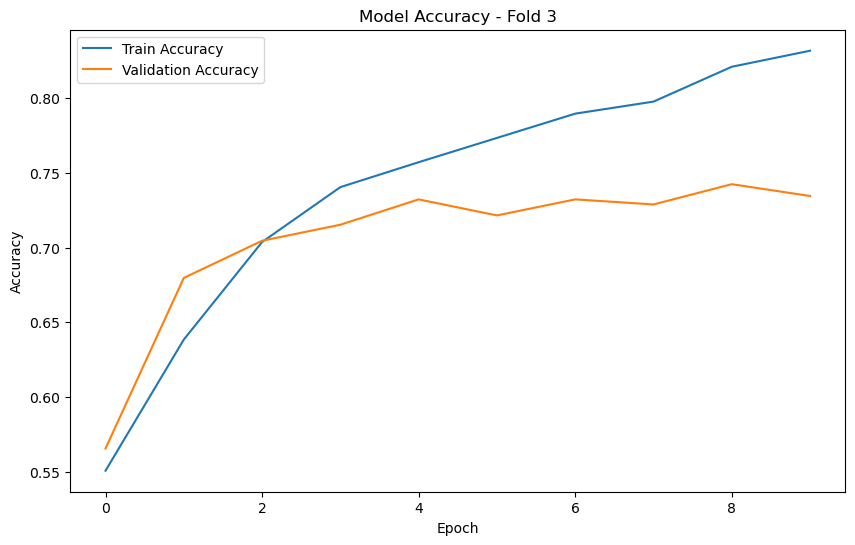

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7322
Balanced Accuracy: 0.7314
MCC: 0.4636
Sensitivity: 0.7558
Specificity: 0.7071

Learned track weights for fold 3:
Sequence weight: 0.5216
Structure weight: 0.4784

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5244 - loss: 0.7013 - val_accuracy: 0.5785 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6064 - loss: 0.6666 - val_accuracy: 0.6605 - val_loss: 0.6471 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6759 - loss: 0.6112 - val_accuracy: 0.6921 - val_loss: 0.5908 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7219 - loss: 0.5618 - val_accuracy: 0.7175 - val_loss: 0.5637 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7544 - loss: 0.5172 - val_accuracy: 0.7249 - val_loss: 0.5554 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7622 - loss: 0.5000 - val_accuracy: 0.7260 - val_loss: 0.5462 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7898 - loss: 0.4703 - val

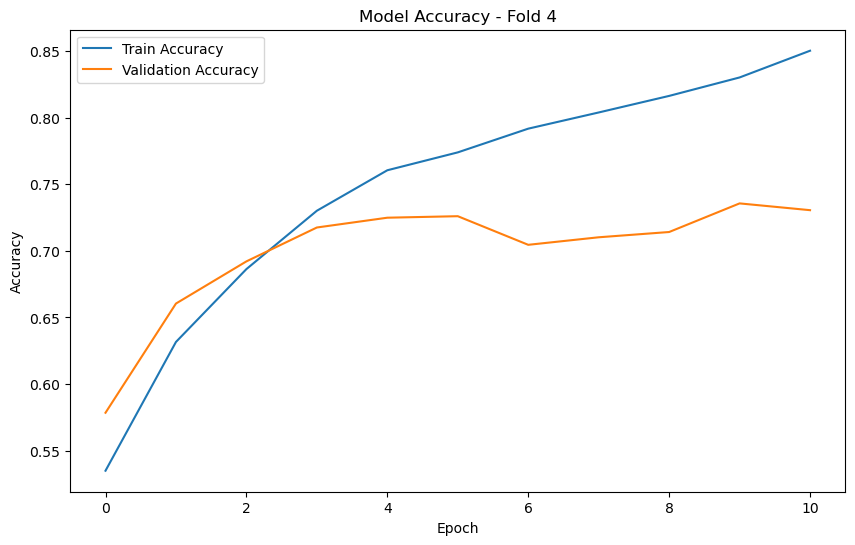

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7260
Balanced Accuracy: 0.7264
MCC: 0.4526
Sensitivity: 0.7130
Specificity: 0.7398

Learned track weights for fold 4:
Sequence weight: 0.5259
Structure weight: 0.4741

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.5444 - loss: 0.6964 - val_accuracy: 0.5785 - val_loss: 0.6812 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6311 - loss: 0.6554 - val_accuracy: 0.6503 - val_loss: 0.6229 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6783 - loss: 0.6097 - val_accuracy: 0.6881 - val_loss: 0.5836 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7234 - loss: 0.5556 - val_accuracy: 0.7158 - val_loss: 0.5626 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7478 - loss: 0.5300 - val_accuracy: 0.7141 - val_loss: 0.5592 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7557 - loss: 0.4980 - val_accuracy: 0.7237 - val_loss: 0.5485 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7778 - loss: 0.4796 - val

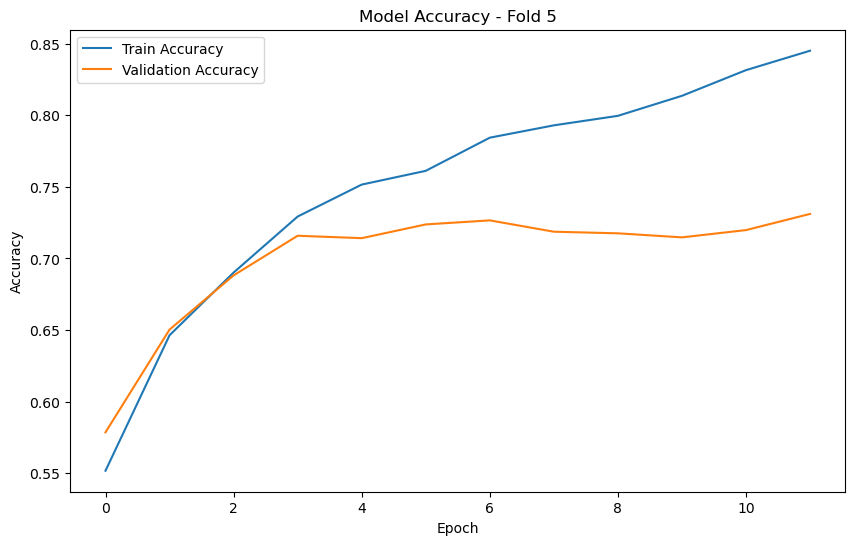

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7266
Balanced Accuracy: 0.7263
MCC: 0.4525
Sensitivity: 0.7339
Specificity: 0.7186

Learned track weights for fold 5:
Sequence weight: 0.5359
Structure weight: 0.4641

Average track weights across folds:
Sequence weight: 0.5260 ± 0.0062
Structure weight: 0.4740 ± 0.0062

Average Cross-validation Results:
ACC: 0.7379 ± 0.0128
BALANCED_ACC: 0.7367 ± 0.0116
MCC: 0.4754 ± 0.0250
SN: 0.7646 ± 0.0397
SP: 0.7088 ± 0.0220

Final Test Set Results:
Accuracy: 0.7267
Balanced Accuracy: 0.7372
MCC: 0.2884
Sensitivity: 0.7500
Specificity: 0.7245
Confusion Matrix:
[[1809  688]
 [  60  180]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.5193 - loss: 0.7032 - val_accuracy: 0.6429 - val_loss: 0.6697 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6347 - loss: 0.6493 - val_accuracy: 0.6910 - val_loss: 0.5958 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6989 - loss: 0.5817 - val_accuracy: 0.7311 - val_loss: 0.5440 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7310 - loss: 0.5381 - val_accuracy: 0.7339 - val_loss: 0.5427 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7539 - loss: 0.5183 - val_accuracy: 0.7441 - val_loss: 0.5229 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7675 - loss: 0.5023 - val_accuracy: 0.7333 - val_loss: 0.5282 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7721 - loss: 0.4864 - val

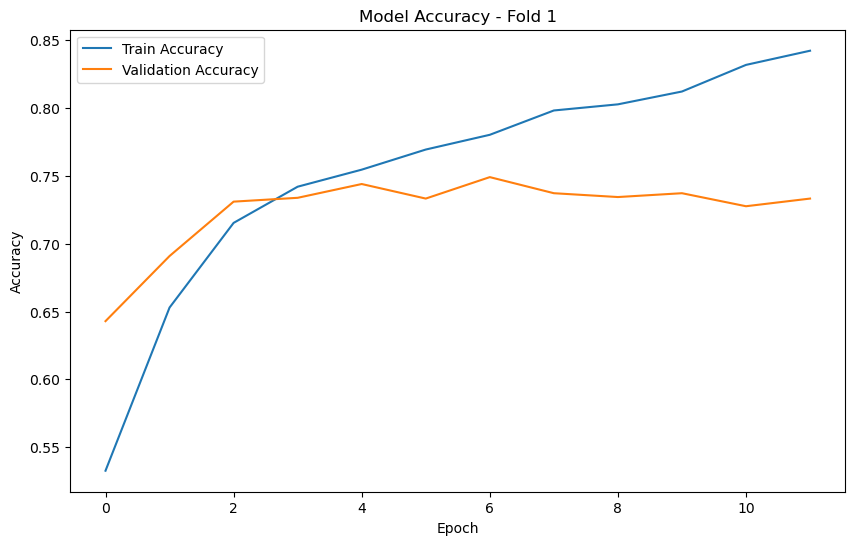

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7492
Balanced Accuracy: 0.7480
MCC: 0.4977
Sensitivity: 0.7842
Specificity: 0.7118

Learned track weights for fold 1:
Sequence weight: 0.5388
Structure weight: 0.4612

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5322 - loss: 0.6974 - val_accuracy: 0.6356 - val_loss: 0.6513 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6340 - loss: 0.6502 - val_accuracy: 0.6780 - val_loss: 0.6086 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6781 - loss: 0.6055 - val_accuracy: 0.7068 - val_loss: 0.5682 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7217 - loss: 0.5621 - val_accuracy: 0.7424 - val_loss: 0.5407 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7415 - loss: 0.5275 - val_accuracy: 0.7441 - val_loss: 0.5257 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7520 - loss: 0.5118 - val_accuracy: 0.7492 - val_loss: 0.5207 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7692 - loss: 0.4952 - val

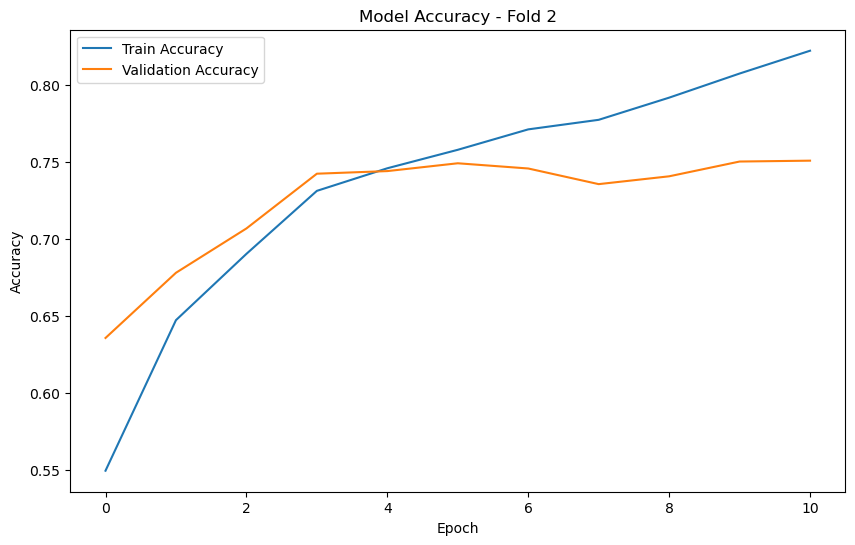

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7492
Balanced Accuracy: 0.7484
MCC: 0.4968
Sensitivity: 0.7607
Specificity: 0.7362

Learned track weights for fold 2:
Sequence weight: 0.5313
Structure weight: 0.4687

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.5152 - loss: 0.7003 - val_accuracy: 0.5452 - val_loss: 0.6853 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5780 - loss: 0.6825 - val_accuracy: 0.6486 - val_loss: 0.6293 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6748 - loss: 0.6076 - val_accuracy: 0.7079 - val_loss: 0.5676 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7152 - loss: 0.5629 - val_accuracy: 0.7130 - val_loss: 0.5796 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7368 - loss: 0.5328 - val_accuracy: 0.7209 - val_loss: 0.5569 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7500 - loss: 0.5099 - val_accuracy: 0.7311 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7708 - loss: 0.4845 - val

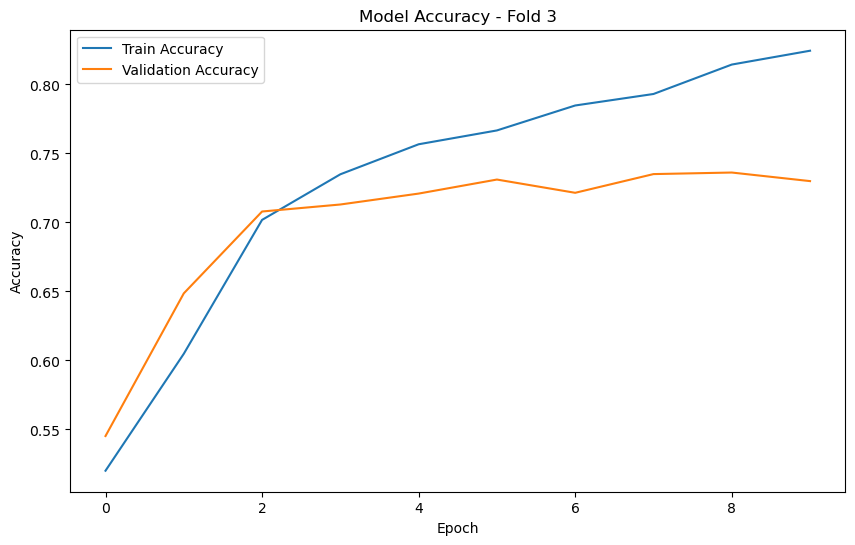

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 3 Results:
Accuracy: 0.7209
Balanced Accuracy: 0.7217
MCC: 0.4436
Sensitivity: 0.6955
Specificity: 0.7480

Learned track weights for fold 3:
Sequence weight: 0.5252
Structure weight: 0.4748

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5253 - loss: 0.6978 - val_accuracy: 0.5638 - val_loss: 0.6855 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6065 - loss: 0.6721 - val_accuracy: 0.6458 - val_loss: 0.6324 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6771 - loss: 0.6135 - val_accuracy: 0.6819 - val_loss: 0.6008 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7194 - loss: 0.5597 - val_accuracy: 0.7034 - val_loss: 0.5734 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7461 - loss: 0.5272 - val_accuracy: 0.7175 - val_loss: 0.5608 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7555 - loss: 0.5091 - val_accuracy: 0.7090 - val_loss: 0.5624 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7739 - loss: 0.4899 - val

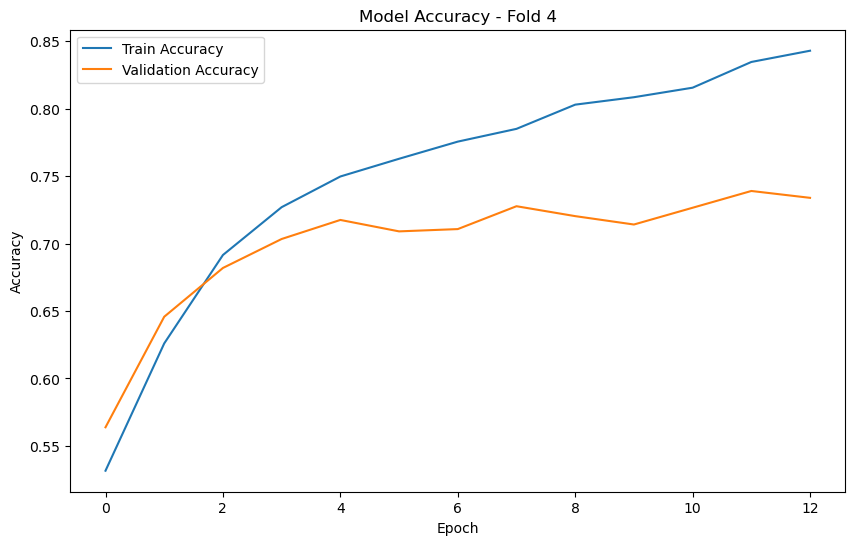

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7277
Balanced Accuracy: 0.7289
MCC: 0.4584
Sensitivity: 0.6911
Specificity: 0.7666

Learned track weights for fold 4:
Sequence weight: 0.5233
Structure weight: 0.4767

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.5356 - loss: 0.7015 - val_accuracy: 0.5859 - val_loss: 0.6857 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5705 - loss: 0.6784 - val_accuracy: 0.6751 - val_loss: 0.6038 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6941 - loss: 0.5835 - val_accuracy: 0.7277 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7389 - loss: 0.5416 - val_accuracy: 0.7367 - val_loss: 0.5344 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7521 - loss: 0.5218 - val_accuracy: 0.7395 - val_loss: 0.5275 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7631 - loss: 0.5061 - val_accuracy: 0.7384 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7726 - loss: 0.4841 - val

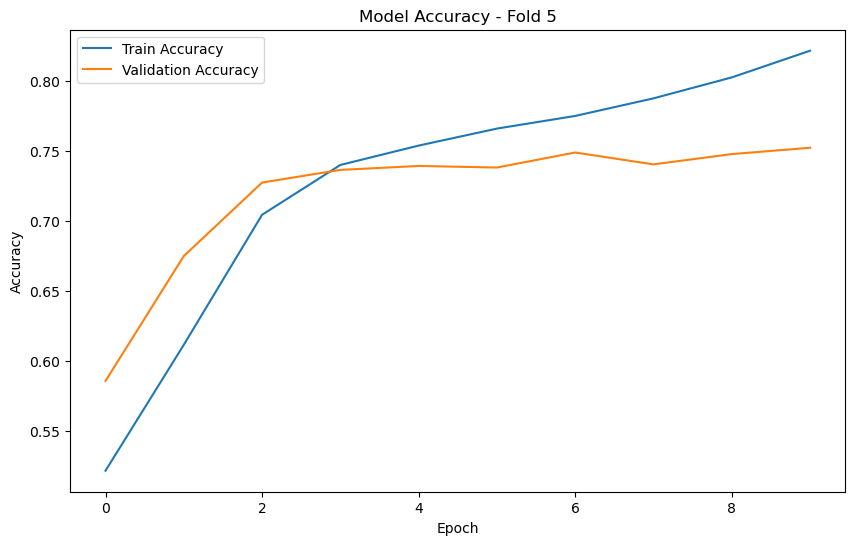

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7395
Balanced Accuracy: 0.7396
MCC: 0.4790
Sensitivity: 0.7372
Specificity: 0.7421

Learned track weights for fold 5:
Sequence weight: 0.5308
Structure weight: 0.4692

Average track weights across folds:
Sequence weight: 0.5299 ± 0.0054
Structure weight: 0.4701 ± 0.0054

Average Cross-validation Results:
ACC: 0.7373 ± 0.0114
BALANCED_ACC: 0.7373 ± 0.0106
MCC: 0.4751 ± 0.0213
SN: 0.7337 ± 0.0362
SP: 0.7409 ± 0.0178

Final Test Set Results:
Accuracy: 0.7461
Balanced Accuracy: 0.7309
MCC: 0.2875
Sensitivity: 0.7125
Specificity: 0.7493
Confusion Matrix:
[[1871  626]
 [  69  171]]


In [16]:
# Run from the window size 5 to 10
for struct_window in range(5, 11):
    model = train_and_evaluate(struct_window=struct_window)
    

Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)
y_test: (2737,)

Fold 1/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.5157 - loss: 0.7017 - val_accuracy: 0.6192 - val_loss: 0.6746 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6152 - loss: 0.6551 - val_accuracy: 0.6729 - val_loss: 0.6264 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6713 - loss: 0.6147 - val_accuracy: 0.7000 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7068 - loss: 0.5715 - val_accuracy: 0.7226 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7405 - loss: 0.5392 - val_accuracy: 0.7226 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7463 - loss: 0.5230 - val_accuracy: 0.7282 - val_loss: 0.5260 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7626 - loss: 0.5060 - val

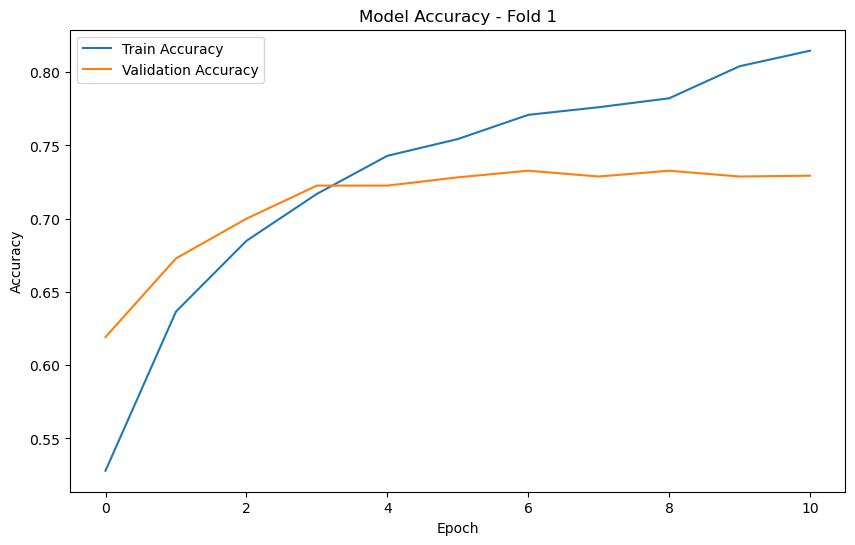

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7282
Balanced Accuracy: 0.7256
MCC: 0.4587
Sensitivity: 0.8105
Specificity: 0.6406

Learned track weights for fold 1:
Sequence weight: 0.5385
Structure weight: 0.4615

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5203 - loss: 0.7106 - val_accuracy: 0.5684 - val_loss: 0.6816 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5706 - loss: 0.6813 - val_accuracy: 0.6740 - val_loss: 0.6261 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6689 - loss: 0.6139 - val_accuracy: 0.7113 - val_loss: 0.5745 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7183 - loss: 0.5694 - val_accuracy: 0.7215 - val_loss: 0.5666 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7320 - loss: 0.5424 - val_accuracy: 0.7350 - val_loss: 0.5535 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7536 - loss: 0.5195 - val_accuracy: 0.7401 - val_loss: 0.5419 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7584 - loss: 0.5077 - val

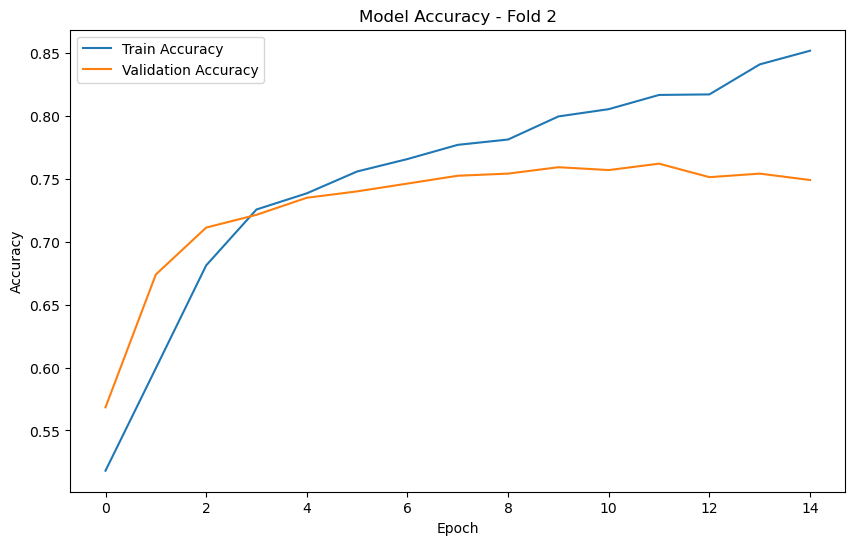

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7593
Balanced Accuracy: 0.7575
MCC: 0.5164
Sensitivity: 0.7885
Specificity: 0.7266

Learned track weights for fold 2:
Sequence weight: 0.5443
Structure weight: 0.4557

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5418 - loss: 0.7000 - val_accuracy: 0.5887 - val_loss: 0.6710 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6262 - loss: 0.6464 - val_accuracy: 0.6616 - val_loss: 0.6108 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7016 - loss: 0.5835 - val_accuracy: 0.7073 - val_loss: 0.5694 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7234 - loss: 0.5488 - val_accuracy: 0.7294 - val_loss: 0.5570 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7479 - loss: 0.5230 - val_accuracy: 0.7266 - val_loss: 0.5635 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7572 - loss: 0.5160 - val_accuracy: 0.7333 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7705 - loss: 0.4847 - val

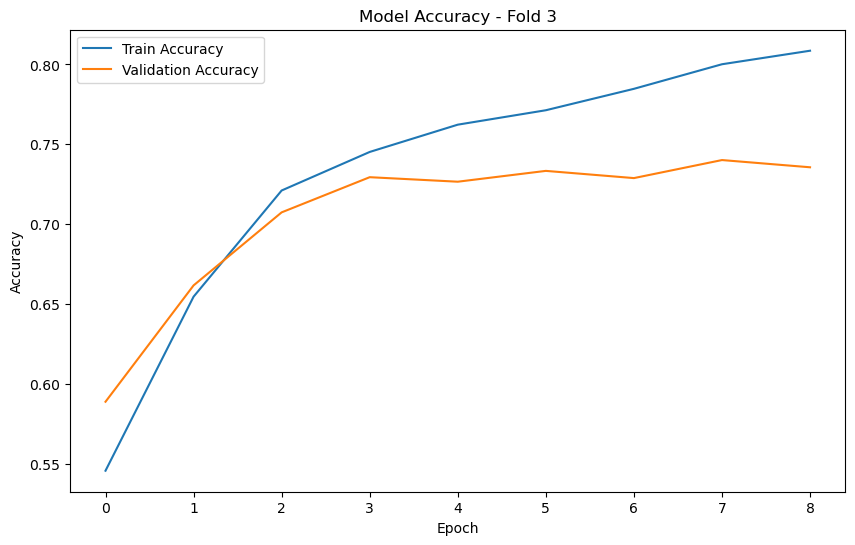

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7294
Balanced Accuracy: 0.7308
MCC: 0.4629
Sensitivity: 0.6846
Specificity: 0.7771

Learned track weights for fold 3:
Sequence weight: 0.5416
Structure weight: 0.4584

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.5233 - loss: 0.7011 - val_accuracy: 0.6418 - val_loss: 0.6625 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6511 - loss: 0.6370 - val_accuracy: 0.7068 - val_loss: 0.5833 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7187 - loss: 0.5620 - val_accuracy: 0.7220 - val_loss: 0.5565 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7300 - loss: 0.5484 - val_accuracy: 0.7266 - val_loss: 0.5476 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7551 - loss: 0.5217 - val_accuracy: 0.7282 - val_loss: 0.5388 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7661 - loss: 0.5081 - val_accuracy: 0.7277 - val_loss: 0.5403 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7814 - loss: 0.4873 - val

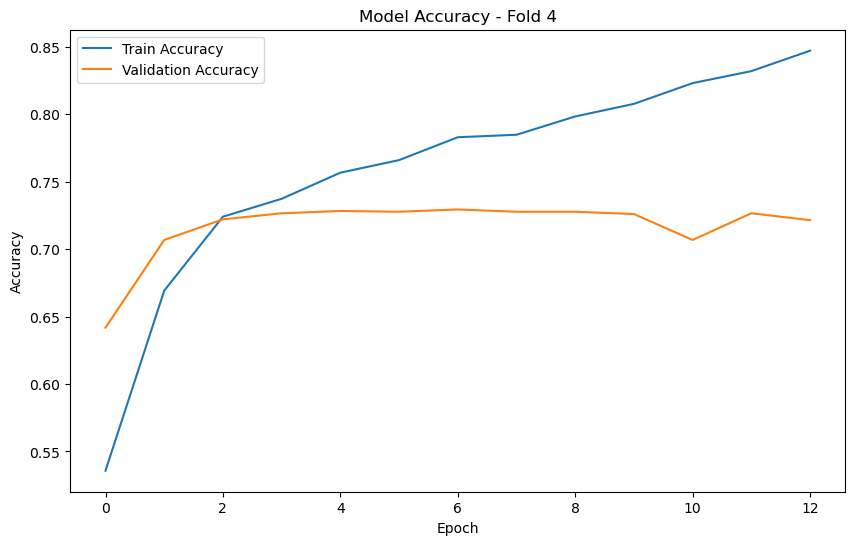

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7277
Balanced Accuracy: 0.7276
MCC: 0.4550
Sensitivity: 0.7317
Specificity: 0.7235

Learned track weights for fold 4:
Sequence weight: 0.5435
Structure weight: 0.4565

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5351 - loss: 0.7011 - val_accuracy: 0.5621 - val_loss: 0.6858 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6071 - loss: 0.6633 - val_accuracy: 0.6503 - val_loss: 0.6305 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6731 - loss: 0.6190 - val_accuracy: 0.6740 - val_loss: 0.6103 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6947 - loss: 0.5894 - val_accuracy: 0.7073 - val_loss: 0.5868 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7327 - loss: 0.5526 - val_accuracy: 0.7237 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7528 - loss: 0.5235 - val_accuracy: 0.7119 - val_loss: 0.5598 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7629 - loss: 0.4936 - val

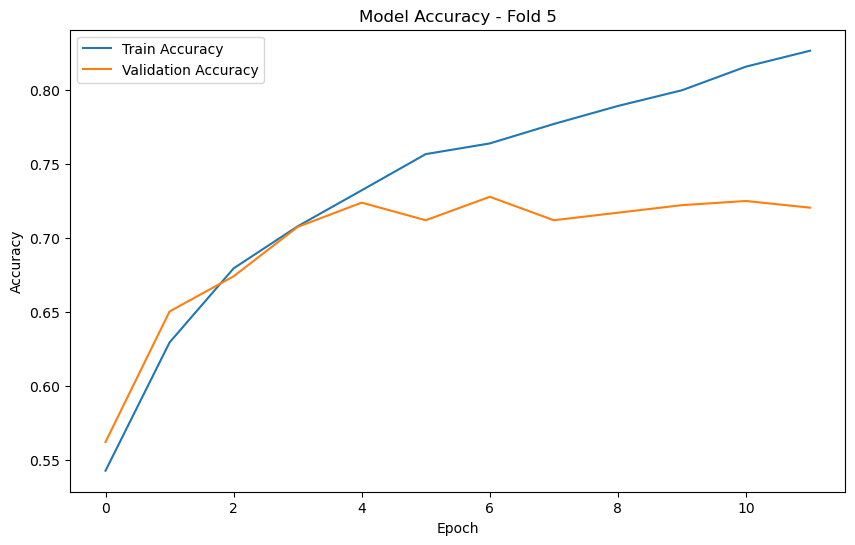

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7277
Balanced Accuracy: 0.7299
MCC: 0.4621
Sensitivity: 0.6685
Specificity: 0.7913

Learned track weights for fold 5:
Sequence weight: 0.5278
Structure weight: 0.4722

Average track weights across folds:
Sequence weight: 0.5391 ± 0.0060
Structure weight: 0.4609 ± 0.0060

Average Cross-validation Results:
ACC: 0.7345 ± 0.0124
BALANCED_ACC: 0.7343 ± 0.0118
MCC: 0.4710 ± 0.0229
SN: 0.7367 ± 0.0557
SP: 0.7318 ± 0.0529

Final Test Set Results:
Accuracy: 0.7424
Balanced Accuracy: 0.7327
MCC: 0.2882
Sensitivity: 0.7208
Specificity: 0.7445
Confusion Matrix:
[[1859  638]
 [  67  173]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5130 - loss: 0.7033 - val_accuracy: 0.5463 - val_loss: 0.6850 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5987 - loss: 0.6715 - val_accuracy: 0.7096 - val_loss: 0.5777 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7101 - loss: 0.5752 - val_accuracy: 0.7345 - val_loss: 0.5446 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7400 - loss: 0.5398 - val_accuracy: 0.7412 - val_loss: 0.5312 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7403 - loss: 0.5258 - val_accuracy: 0.7373 - val_loss: 0.5246 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7648 - loss: 0.5043 - val_accuracy: 0.7401 - val_loss: 0.5176 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7745 - loss: 0.4958 - val

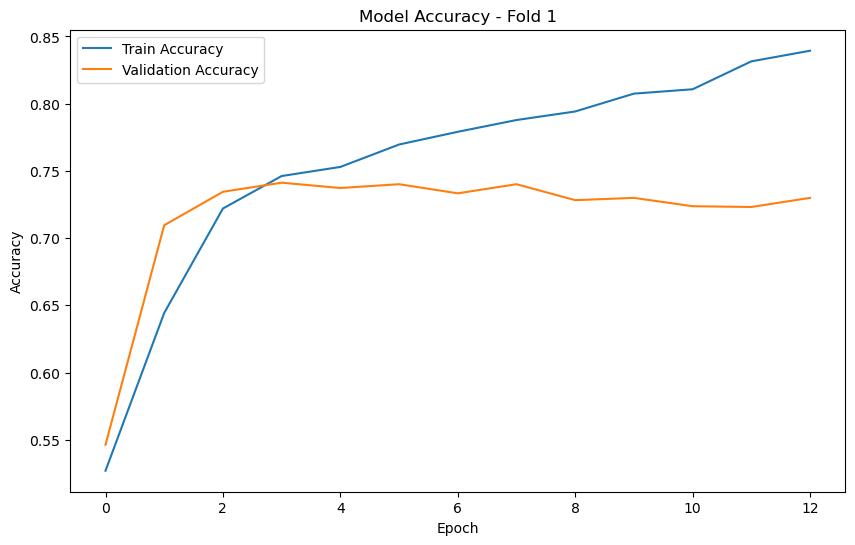

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7401
Balanced Accuracy: 0.7369
MCC: 0.4853
Sensitivity: 0.8390
Specificity: 0.6348

Learned track weights for fold 1:
Sequence weight: 0.5468
Structure weight: 0.4532

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.5124 - loss: 0.7110 - val_accuracy: 0.5751 - val_loss: 0.6845 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.5709 - loss: 0.6871 - val_accuracy: 0.6350 - val_loss: 0.6446 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6409 - loss: 0.6339 - val_accuracy: 0.7164 - val_loss: 0.5768 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7168 - loss: 0.5664 - val_accuracy: 0.7605 - val_loss: 0.5290 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7454 - loss: 0.5318 - val_accuracy: 0.7616 - val_loss: 0.5157 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7541 - loss: 0.5119 - val_accuracy: 0.7537 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7622 - loss: 0.5025 - val

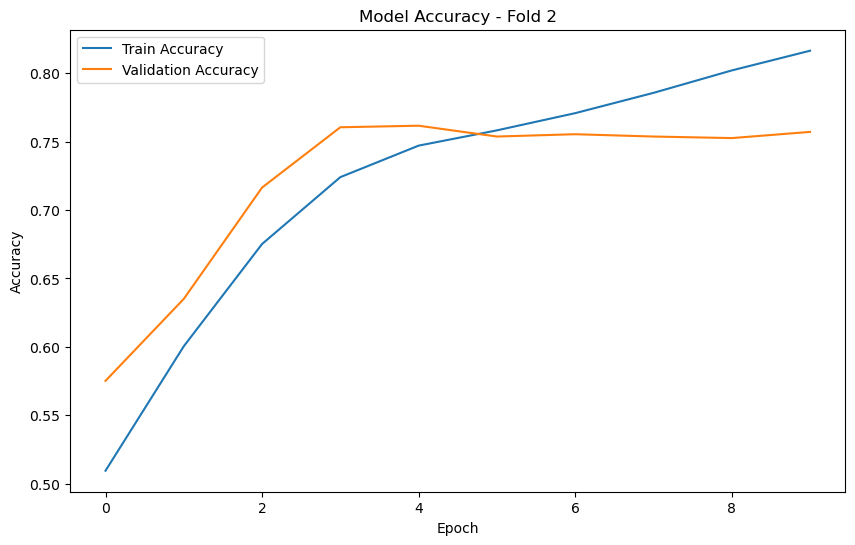

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 2 Results:
Accuracy: 0.7616
Balanced Accuracy: 0.7593
MCC: 0.5208
Sensitivity: 0.7991
Specificity: 0.7194

Learned track weights for fold 2:
Sequence weight: 0.5232
Structure weight: 0.4768

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5117 - loss: 0.7020 - val_accuracy: 0.5333 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6045 - loss: 0.6641 - val_accuracy: 0.6435 - val_loss: 0.6243 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6899 - loss: 0.5920 - val_accuracy: 0.7147 - val_loss: 0.5769 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7249 - loss: 0.5449 - val_accuracy: 0.7288 - val_loss: 0.5591 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7492 - loss: 0.5155 - val_accuracy: 0.7282 - val_loss: 0.5640 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7653 - loss: 0.4965 - val_accuracy: 0.7384 - val_loss: 0.5722 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7757 - loss: 0.4763 - val

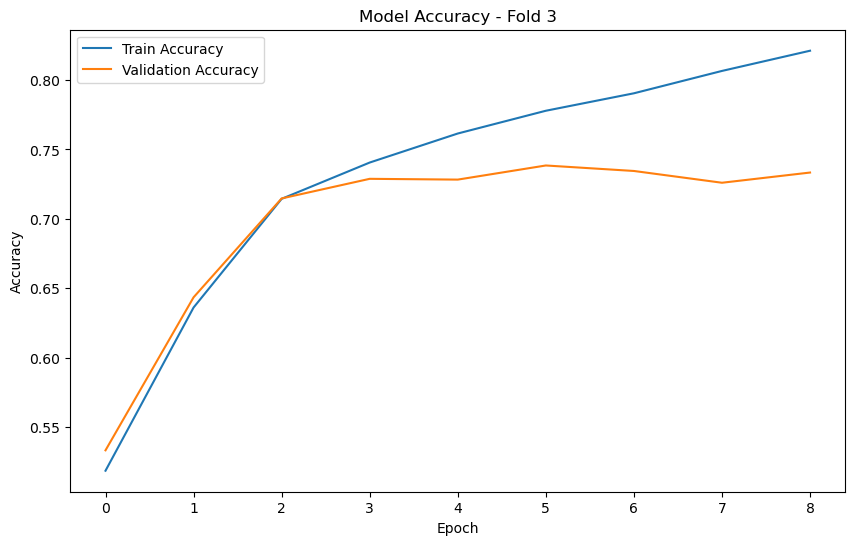

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7288
Balanced Accuracy: 0.7307
MCC: 0.4635
Sensitivity: 0.6725
Specificity: 0.7888

Learned track weights for fold 3:
Sequence weight: 0.5333
Structure weight: 0.4667

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5271 - loss: 0.7198 - val_accuracy: 0.5282 - val_loss: 0.6875 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5641 - loss: 0.6761 - val_accuracy: 0.6672 - val_loss: 0.6396 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6533 - loss: 0.6308 - val_accuracy: 0.6729 - val_loss: 0.6140 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6952 - loss: 0.5920 - val_accuracy: 0.6814 - val_loss: 0.6043 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7103 - loss: 0.5723 - val_accuracy: 0.7136 - val_loss: 0.5865 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7421 - loss: 0.5354 - val_accuracy: 0.6859 - val_loss: 0.6044 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7575 - loss: 0.5036 - val

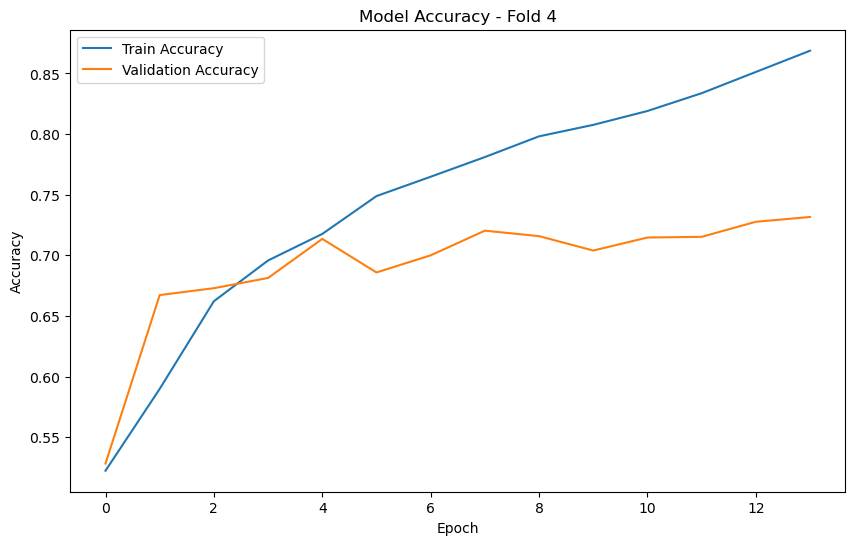

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Results:
Accuracy: 0.7158
Balanced Accuracy: 0.7176
MCC: 0.4373
Sensitivity: 0.6605
Specificity: 0.7748

Learned track weights for fold 4:
Sequence weight: 0.5198
Structure weight: 0.4802

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.5107 - loss: 0.7145 - val_accuracy: 0.6475 - val_loss: 0.6658 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6415 - loss: 0.6474 - val_accuracy: 0.6853 - val_loss: 0.5996 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7120 - loss: 0.5676 - val_accuracy: 0.7203 - val_loss: 0.5438 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7400 - loss: 0.5336 - val_accuracy: 0.7345 - val_loss: 0.5304 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7608 - loss: 0.5090 - val_accuracy: 0.7322 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7674 - loss: 0.4989 - val_accuracy: 0.7266 - val_loss: 0.5289 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7699 - loss: 0.4764 - val

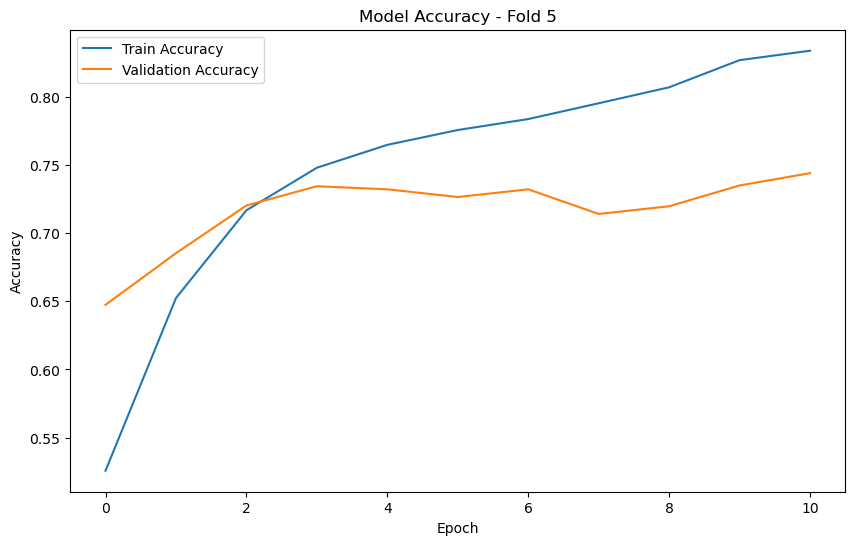

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7266
Balanced Accuracy: 0.7273
MCC: 0.4544
Sensitivity: 0.7067
Specificity: 0.7479

Learned track weights for fold 5:
Sequence weight: 0.5391
Structure weight: 0.4609

Average track weights across folds:
Sequence weight: 0.5324 ± 0.0100
Structure weight: 0.4676 ± 0.0100

Average Cross-validation Results:
ACC: 0.7346 ± 0.0156
BALANCED_ACC: 0.7343 ± 0.0139
MCC: 0.4723 ± 0.0288
SN: 0.7356 ± 0.0710
SP: 0.7331 ± 0.0546

Final Test Set Results:
Accuracy: 0.7410
Balanced Accuracy: 0.7300
MCC: 0.2847
Sensitivity: 0.7167
Specificity: 0.7433
Confusion Matrix:
[[1856  641]
 [  68  172]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.5042 - loss: 0.7019 - val_accuracy: 0.5610 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5754 - loss: 0.6714 - val_accuracy: 0.7045 - val_loss: 0.5780 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7054 - loss: 0.5786 - val_accuracy: 0.7345 - val_loss: 0.5408 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7363 - loss: 0.5435 - val_accuracy: 0.7480 - val_loss: 0.5253 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7513 - loss: 0.5290 - val_accuracy: 0.7469 - val_loss: 0.5205 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7608 - loss: 0.5121 - val_accuracy: 0.7458 - val_loss: 0.5182 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7651 - loss: 0.5019 - val

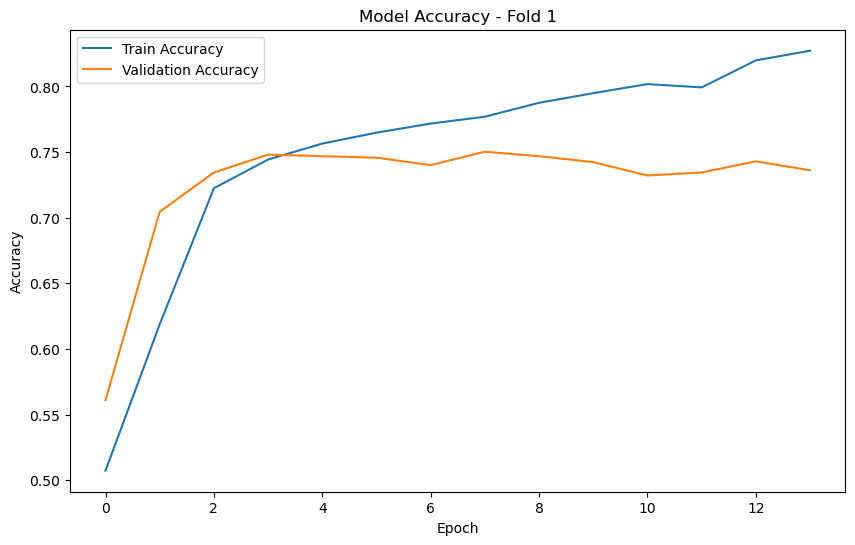

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7432
MCC: 0.5017
Sensitivity: 0.8587
Specificity: 0.6278

Learned track weights for fold 1:
Sequence weight: 0.5587
Structure weight: 0.4413

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5046 - loss: 0.6954 - val_accuracy: 0.5429 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5889 - loss: 0.6772 - val_accuracy: 0.6763 - val_loss: 0.6117 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6762 - loss: 0.6174 - val_accuracy: 0.7237 - val_loss: 0.5700 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7248 - loss: 0.5674 - val_accuracy: 0.7339 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7404 - loss: 0.5354 - val_accuracy: 0.7463 - val_loss: 0.5190 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7603 - loss: 0.5145 - val_accuracy: 0.7458 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7727 - loss: 0.4846 - val

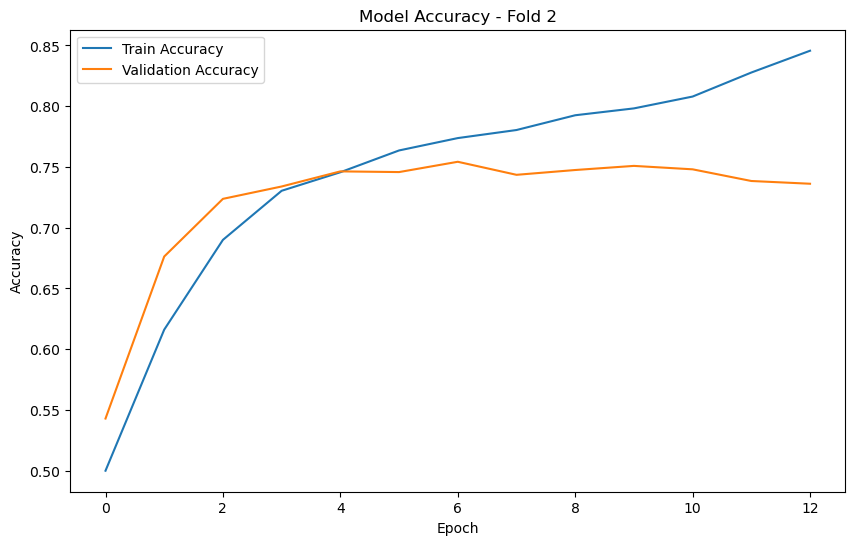

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7435
Balanced Accuracy: 0.7416
MCC: 0.4845
Sensitivity: 0.7746
Specificity: 0.7086

Learned track weights for fold 2:
Sequence weight: 0.5311
Structure weight: 0.4689

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.5278 - loss: 0.6974 - val_accuracy: 0.5164 - val_loss: 0.6860 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6232 - loss: 0.6491 - val_accuracy: 0.6638 - val_loss: 0.6063 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7054 - loss: 0.5754 - val_accuracy: 0.7198 - val_loss: 0.5595 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7361 - loss: 0.5313 - val_accuracy: 0.7299 - val_loss: 0.5619 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7496 - loss: 0.5147 - val_accuracy: 0.7288 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7677 - loss: 0.4837 - val_accuracy: 0.7277 - val_loss: 0.5673 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7816 - loss: 0.4682 - val

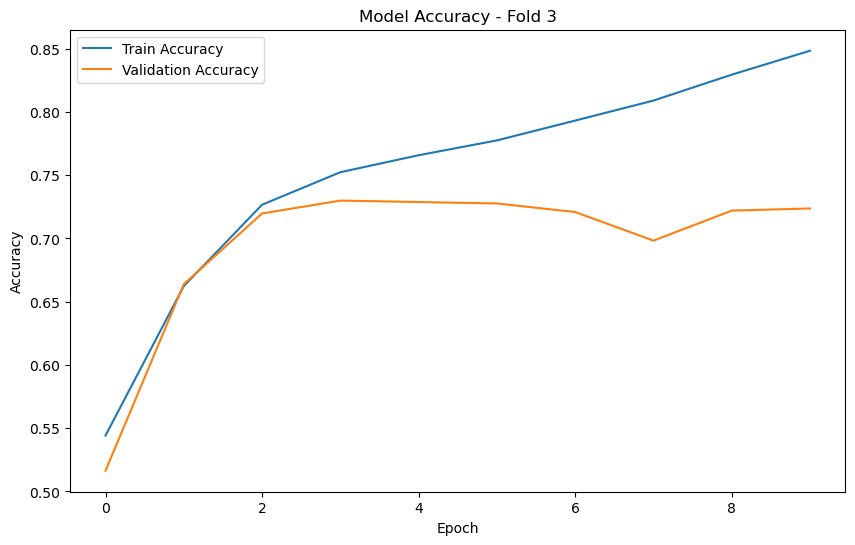

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7288
Balanced Accuracy: 0.7293
MCC: 0.4583
Sensitivity: 0.7152
Specificity: 0.7433

Learned track weights for fold 3:
Sequence weight: 0.5397
Structure weight: 0.4603

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5052 - loss: 0.6975 - val_accuracy: 0.6045 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6231 - loss: 0.6544 - val_accuracy: 0.6847 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7083 - loss: 0.5701 - val_accuracy: 0.7169 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7382 - loss: 0.5355 - val_accuracy: 0.7299 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7524 - loss: 0.5171 - val_accuracy: 0.7232 - val_loss: 0.5377 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7679 - loss: 0.5045 - val_accuracy: 0.7328 - val_loss: 0.5377 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7742 - loss: 0.4907 - val

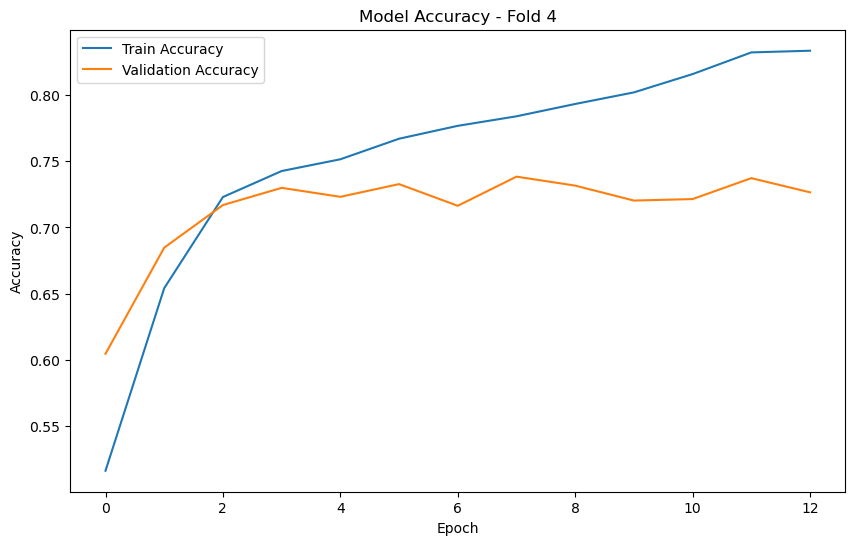

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 4 Results:
Accuracy: 0.7384
Balanced Accuracy: 0.7392
MCC: 0.4786
Sensitivity: 0.7130
Specificity: 0.7655

Learned track weights for fold 4:
Sequence weight: 0.5506
Structure weight: 0.4494

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5145 - loss: 0.7116 - val_accuracy: 0.5486 - val_loss: 0.6870 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5600 - loss: 0.6826 - val_accuracy: 0.6130 - val_loss: 0.6584 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6473 - loss: 0.6378 - val_accuracy: 0.6548 - val_loss: 0.6161 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6797 - loss: 0.5968 - val_accuracy: 0.6746 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7101 - loss: 0.5592 - val_accuracy: 0.7079 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7474 - loss: 0.5222 - val_accuracy: 0.7243 - val_loss: 0.5505 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7593 - loss: 0.4965 - val

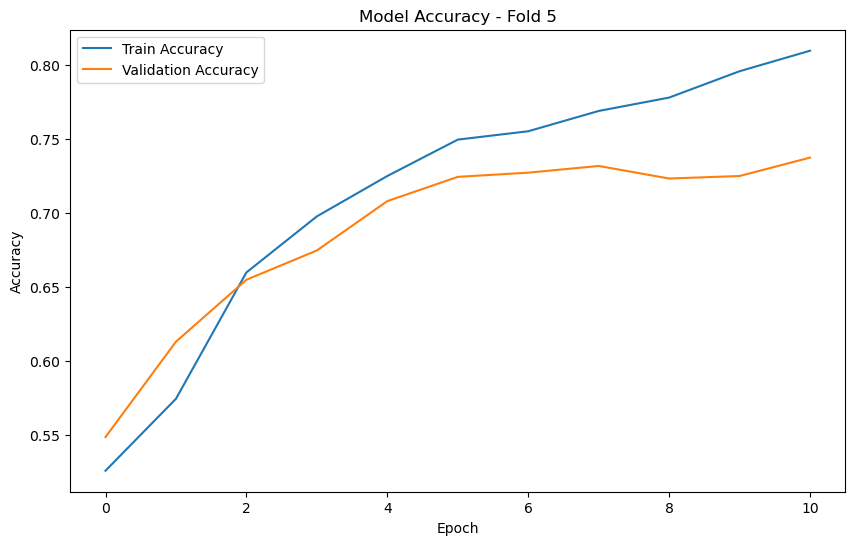

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7243
Balanced Accuracy: 0.7250
MCC: 0.4497
Sensitivity: 0.7067
Specificity: 0.7433

Learned track weights for fold 5:
Sequence weight: 0.5296
Structure weight: 0.4704

Average track weights across folds:
Sequence weight: 0.5419 ± 0.0112
Structure weight: 0.4581 ± 0.0112

Average Cross-validation Results:
ACC: 0.7364 ± 0.0086
BALANCED_ACC: 0.7357 ± 0.0072
MCC: 0.4746 ± 0.0186
SN: 0.7536 ± 0.0580
SP: 0.7177 ± 0.0485

Final Test Set Results:
Accuracy: 0.7271
Balanced Accuracy: 0.7337
MCC: 0.2845
Sensitivity: 0.7417
Specificity: 0.7257
Confusion Matrix:
[[1812  685]
 [  62  178]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.5203 - loss: 0.7043 - val_accuracy: 0.5949 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5910 - loss: 0.6723 - val_accuracy: 0.6966 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.6957 - loss: 0.5820 - val_accuracy: 0.7401 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7393 - loss: 0.5380 - val_accuracy: 0.7458 - val_loss: 0.5280 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7526 - loss: 0.5255 - val_accuracy: 0.7480 - val_loss: 0.5228 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7640 - loss: 0.5032 - val_accuracy: 0.7588 - val_loss: 0.5256 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7755 - loss: 0.4907 - val

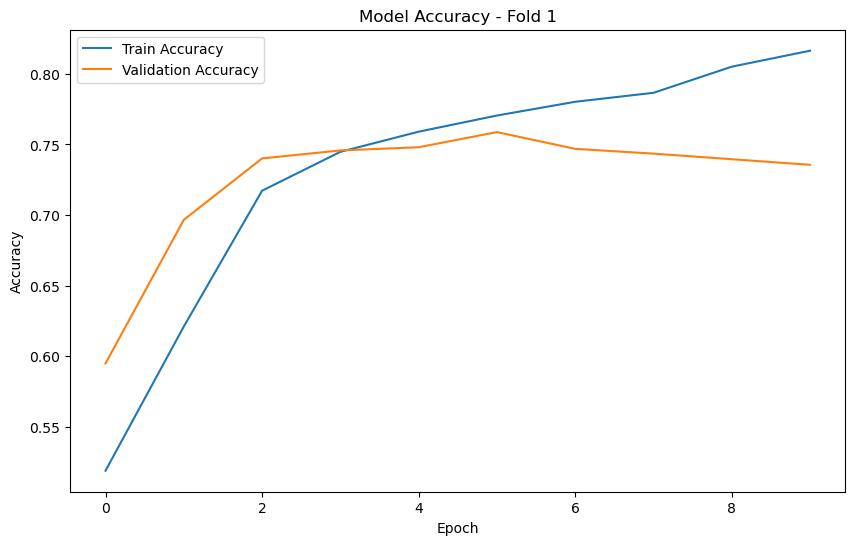

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7480
Balanced Accuracy: 0.7443
MCC: 0.5043
Sensitivity: 0.8609
Specificity: 0.6278

Learned track weights for fold 1:
Sequence weight: 0.5427
Structure weight: 0.4573

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5015 - loss: 0.7134 - val_accuracy: 0.5446 - val_loss: 0.6885 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5411 - loss: 0.6893 - val_accuracy: 0.5706 - val_loss: 0.6673 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6446 - loss: 0.6418 - val_accuracy: 0.7006 - val_loss: 0.5826 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7229 - loss: 0.5710 - val_accuracy: 0.7299 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7423 - loss: 0.5336 - val_accuracy: 0.7395 - val_loss: 0.5244 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7559 - loss: 0.5072 - val_accuracy: 0.7469 - val_loss: 0.5395 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7746 - loss: 0.4900 - val

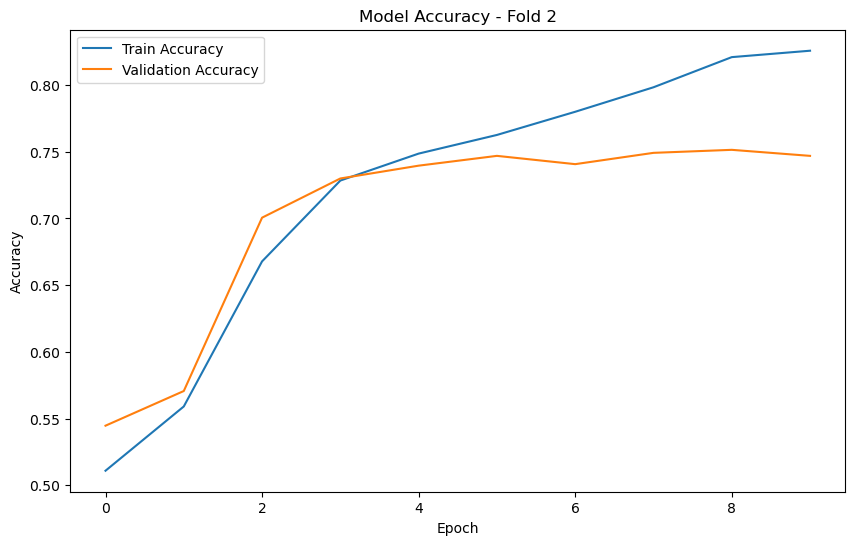

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7395
Balanced Accuracy: 0.7389
MCC: 0.4776
Sensitivity: 0.7500
Specificity: 0.7278

Learned track weights for fold 2:
Sequence weight: 0.5334
Structure weight: 0.4666

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5185 - loss: 0.6991 - val_accuracy: 0.5282 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5761 - loss: 0.6799 - val_accuracy: 0.6401 - val_loss: 0.6340 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6796 - loss: 0.6054 - val_accuracy: 0.7169 - val_loss: 0.5710 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7282 - loss: 0.5523 - val_accuracy: 0.7254 - val_loss: 0.5626 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7486 - loss: 0.5188 - val_accuracy: 0.7345 - val_loss: 0.5567 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7607 - loss: 0.5015 - val_accuracy: 0.7288 - val_loss: 0.5429 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7910 - loss: 0.4676 - val

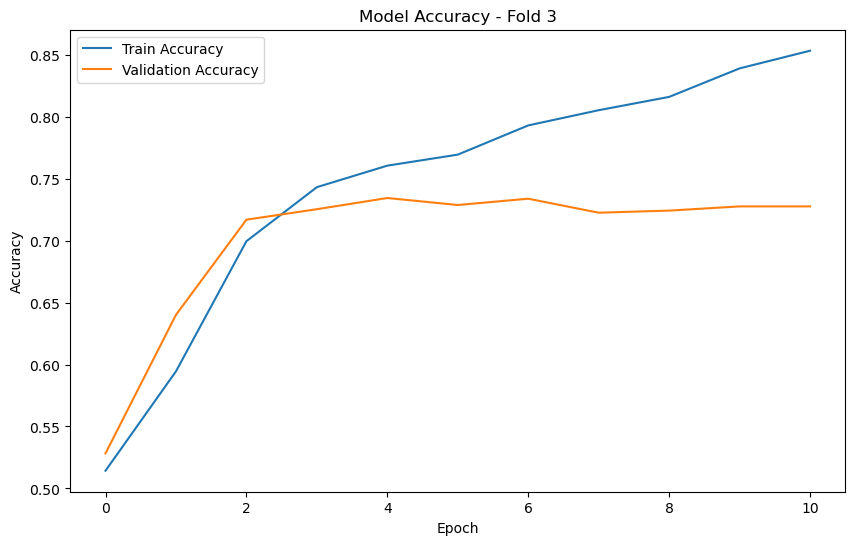

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7288
Balanced Accuracy: 0.7295
MCC: 0.4591
Sensitivity: 0.7065
Specificity: 0.7526

Learned track weights for fold 3:
Sequence weight: 0.5354
Structure weight: 0.4646

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.5275 - loss: 0.7036 - val_accuracy: 0.5282 - val_loss: 0.6898 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5578 - loss: 0.6825 - val_accuracy: 0.6367 - val_loss: 0.6537 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6511 - loss: 0.6252 - val_accuracy: 0.6977 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7195 - loss: 0.5587 - val_accuracy: 0.7085 - val_loss: 0.5757 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7404 - loss: 0.5285 - val_accuracy: 0.7271 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7642 - loss: 0.5028 - val_accuracy: 0.7429 - val_loss: 0.5432 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7740 - loss: 0.4849 - val

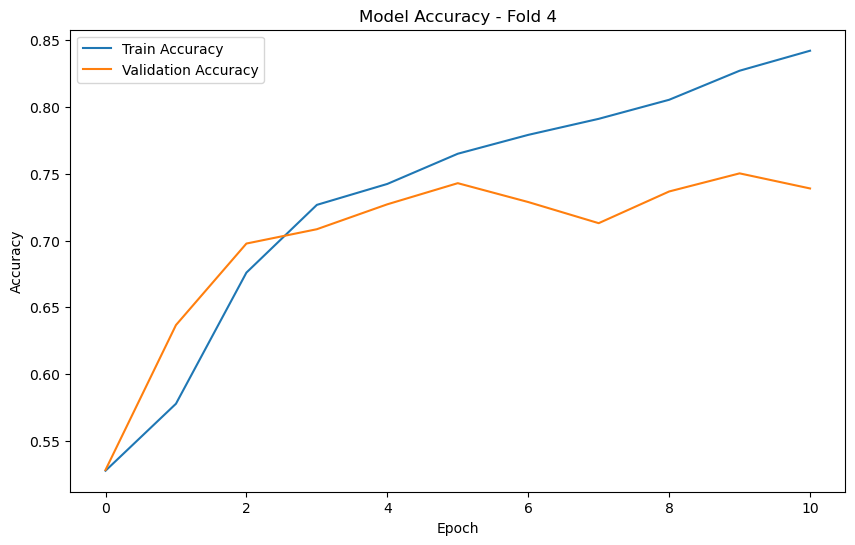

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Results:
Accuracy: 0.7429
Balanced Accuracy: 0.7409
MCC: 0.4867
Sensitivity: 0.8061
Specificity: 0.6756

Learned track weights for fold 4:
Sequence weight: 0.5284
Structure weight: 0.4716

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5147 - loss: 0.7170 - val_accuracy: 0.5661 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5927 - loss: 0.6774 - val_accuracy: 0.6734 - val_loss: 0.6178 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6980 - loss: 0.5852 - val_accuracy: 0.7260 - val_loss: 0.5526 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7336 - loss: 0.5375 - val_accuracy: 0.7277 - val_loss: 0.5441 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7611 - loss: 0.5076 - val_accuracy: 0.7350 - val_loss: 0.5481 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7727 - loss: 0.4936 - val_accuracy: 0.7452 - val_loss: 0.5373 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7819 - loss: 0.4771 - val

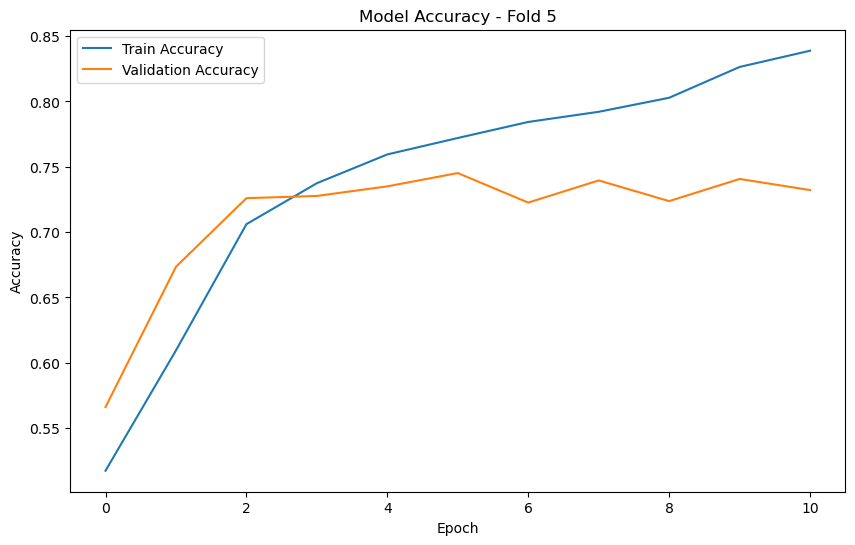

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7452
Balanced Accuracy: 0.7438
MCC: 0.4895
Sensitivity: 0.7830
Specificity: 0.7046

Learned track weights for fold 5:
Sequence weight: 0.5228
Structure weight: 0.4772

Average track weights across folds:
Sequence weight: 0.5325 ± 0.0067
Structure weight: 0.4675 ± 0.0067

Average Cross-validation Results:
ACC: 0.7409 ± 0.0067
BALANCED_ACC: 0.7395 ± 0.0053
MCC: 0.4834 ± 0.0149
SN: 0.7813 ± 0.0520
SP: 0.6977 ± 0.0432

Final Test Set Results:
Accuracy: 0.7059
Balanced Accuracy: 0.7296
MCC: 0.2743
Sensitivity: 0.7583
Specificity: 0.7008
Confusion Matrix:
[[1750  747]
 [  58  182]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5284 - loss: 0.7039 - val_accuracy: 0.5418 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5519 - loss: 0.6865 - val_accuracy: 0.6288 - val_loss: 0.6567 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6359 - loss: 0.6417 - val_accuracy: 0.6746 - val_loss: 0.6142 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6888 - loss: 0.6031 - val_accuracy: 0.7000 - val_loss: 0.5950 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7145 - loss: 0.5646 - val_accuracy: 0.7181 - val_loss: 0.5614 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7411 - loss: 0.5335 - val_accuracy: 0.7282 - val_loss: 0.5471 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7681 - loss: 0.5099 - val

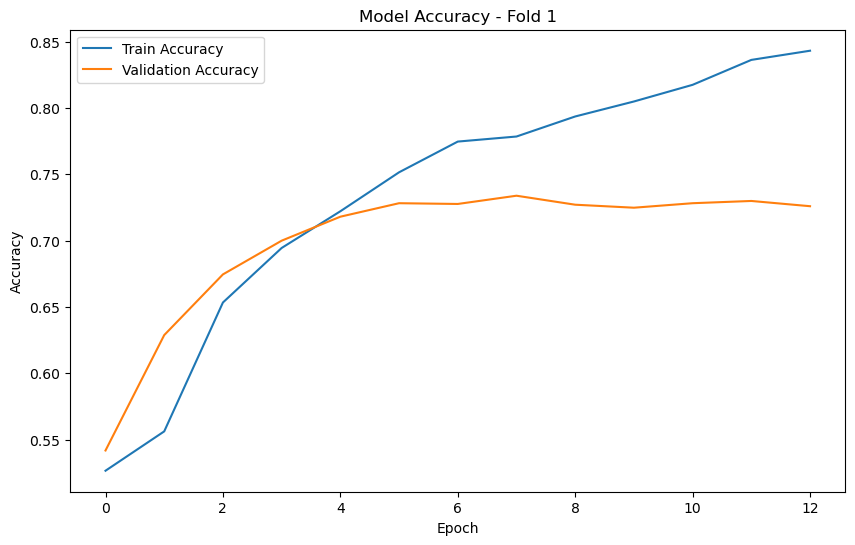

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7339
Balanced Accuracy: 0.7316
MCC: 0.4689
Sensitivity: 0.8028
Specificity: 0.6604

Learned track weights for fold 1:
Sequence weight: 0.5242
Structure weight: 0.4758

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5246 - loss: 0.7009 - val_accuracy: 0.6056 - val_loss: 0.6598 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6248 - loss: 0.6557 - val_accuracy: 0.6774 - val_loss: 0.6139 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6642 - loss: 0.6197 - val_accuracy: 0.6712 - val_loss: 0.5982 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7010 - loss: 0.5851 - val_accuracy: 0.7062 - val_loss: 0.6357 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7239 - loss: 0.5607 - val_accuracy: 0.7220 - val_loss: 0.5529 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7373 - loss: 0.5419 - val_accuracy: 0.7362 - val_loss: 0.5420 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7532 - loss: 0.5264 - val

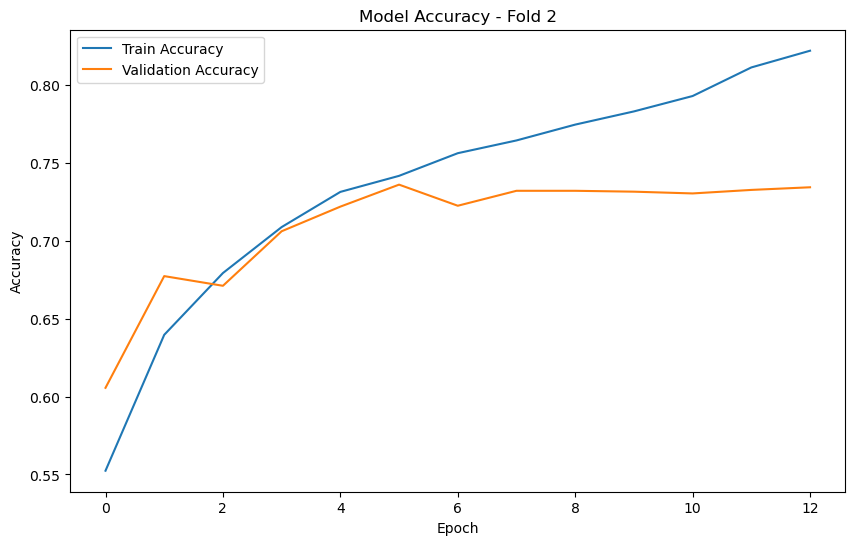

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7322
Balanced Accuracy: 0.7293
MCC: 0.4616
Sensitivity: 0.7799
Specificity: 0.6787

Learned track weights for fold 2:
Sequence weight: 0.5481
Structure weight: 0.4519

Fold 3/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.5148 - loss: 0.7143 - val_accuracy: 0.5520 - val_loss: 0.6827 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5912 - loss: 0.6747 - val_accuracy: 0.6249 - val_loss: 0.6469 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6545 - loss: 0.6243 - val_accuracy: 0.6853 - val_loss: 0.5959 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7149 - loss: 0.5660 - val_accuracy: 0.7045 - val_loss: 0.5690 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7434 - loss: 0.5261 - val_accuracy: 0.7136 - val_loss: 0.5746 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7691 - loss: 0.4956 - val_accuracy: 0.7237 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7795 - loss: 0

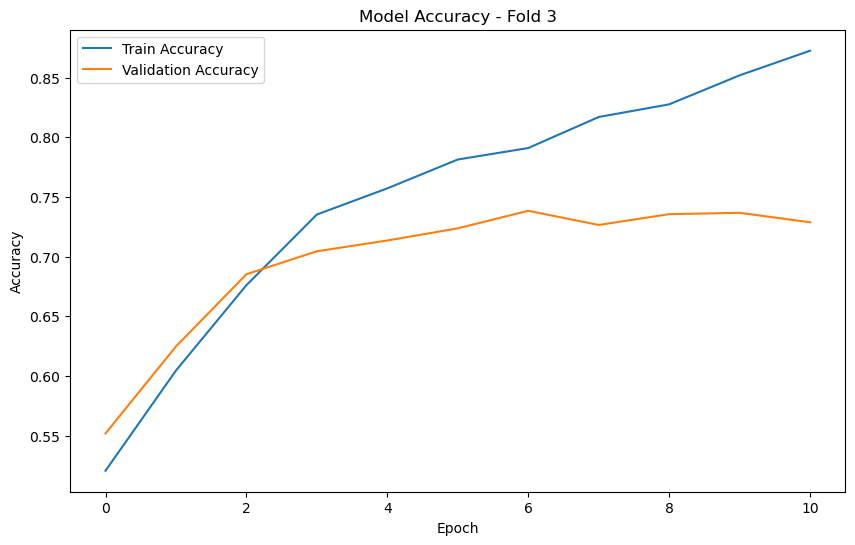

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7237
Balanced Accuracy: 0.7250
MCC: 0.4509
Sensitivity: 0.6835
Specificity: 0.7666

Learned track weights for fold 3:
Sequence weight: 0.5268
Structure weight: 0.4732

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.5125 - loss: 0.7060 - val_accuracy: 0.5870 - val_loss: 0.6891 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6092 - loss: 0.6696 - val_accuracy: 0.6706 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6730 - loss: 0.6081 - val_accuracy: 0.6972 - val_loss: 0.5883 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7239 - loss: 0.5559 - val_accuracy: 0.7288 - val_loss: 0.5532 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7451 - loss: 0.5297 - val_accuracy: 0.7243 - val_loss: 0.5519 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7605 - loss: 0.5163 - val_accuracy: 0.7271 - val_loss: 0.5391 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7710 - loss: 0.4944 - val

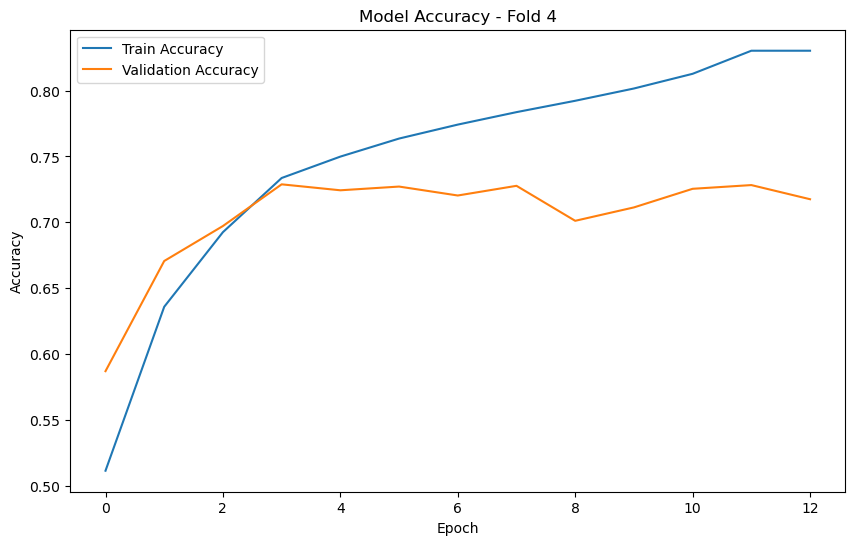

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 4 Results:
Accuracy: 0.7277
Balanced Accuracy: 0.7285
MCC: 0.4571
Sensitivity: 0.7021
Specificity: 0.7550

Learned track weights for fold 4:
Sequence weight: 0.5494
Structure weight: 0.4506

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5151 - loss: 0.7112 - val_accuracy: 0.5633 - val_loss: 0.6859 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5993 - loss: 0.6625 - val_accuracy: 0.6994 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7152 - loss: 0.5688 - val_accuracy: 0.7237 - val_loss: 0.5420 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7467 - loss: 0.5258 - val_accuracy: 0.7356 - val_loss: 0.5254 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7538 - loss: 0.5090 - val_accuracy: 0.7237 - val_loss: 0.5368 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7676 - loss: 0.4943 - val_accuracy: 0.7322 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7831 - loss: 0.4754 - val

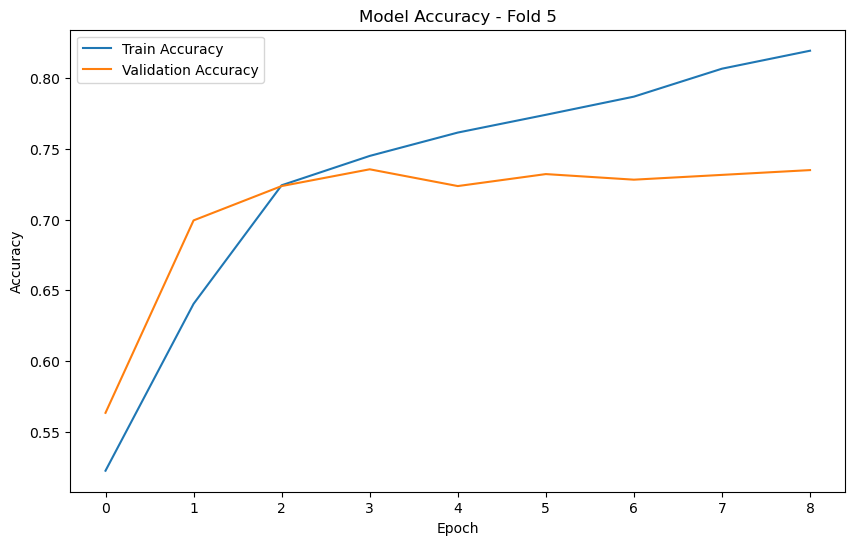

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7356
Balanced Accuracy: 0.7339
MCC: 0.4703
Sensitivity: 0.7797
Specificity: 0.6882

Learned track weights for fold 5:
Sequence weight: 0.5393
Structure weight: 0.4607

Average track weights across folds:
Sequence weight: 0.5376 ± 0.0105
Structure weight: 0.4624 ± 0.0105

Average Cross-validation Results:
ACC: 0.7306 ± 0.0043
BALANCED_ACC: 0.7297 ± 0.0030
MCC: 0.4618 ± 0.0073
SN: 0.7496 ± 0.0475
SP: 0.7098 ± 0.0428

Final Test Set Results:
Accuracy: 0.7271
Balanced Accuracy: 0.7393
MCC: 0.2908
Sensitivity: 0.7542
Specificity: 0.7245
Confusion Matrix:
[[1809  688]
 [  59  181]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5076 - loss: 0.6980 - val_accuracy: 0.6362 - val_loss: 0.6595 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.6293 - loss: 0.6459 - val_accuracy: 0.6802 - val_loss: 0.6067 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6914 - loss: 0.5919 - val_accuracy: 0.7266 - val_loss: 0.5541 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7215 - loss: 0.5497 - val_accuracy: 0.7322 - val_loss: 0.5296 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7471 - loss: 0.5229 - val_accuracy: 0.7356 - val_loss: 0.5292 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7649 - loss: 0.5023 - val_accuracy: 0.7424 - val_loss: 0.5219 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7789 - loss: 0.4834 - val

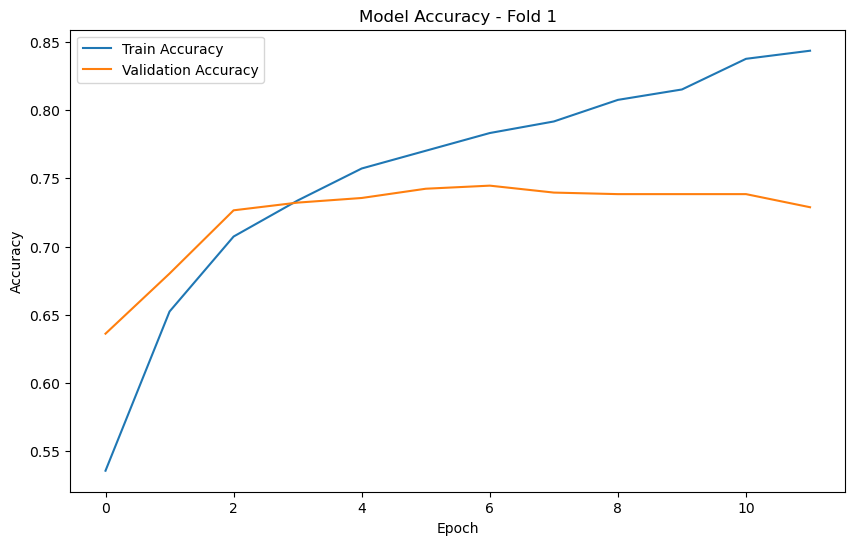

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7446
Balanced Accuracy: 0.7422
MCC: 0.4911
Sensitivity: 0.8182
Specificity: 0.6663

Learned track weights for fold 1:
Sequence weight: 0.5545
Structure weight: 0.4455

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5131 - loss: 0.6991 - val_accuracy: 0.5226 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5100 - loss: 0.6996 - val_accuracy: 0.5842 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5710 - loss: 0.6810 - val_accuracy: 0.6571 - val_loss: 0.6181 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6779 - loss: 0.5977 - val_accuracy: 0.7339 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7172 - loss: 0.5548 - val_accuracy: 0.7401 - val_loss: 0.5333 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7303 - loss: 0.5394 - val_accuracy: 0.7537 - val_loss: 0.5264 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7438 - loss: 0.5245 - val

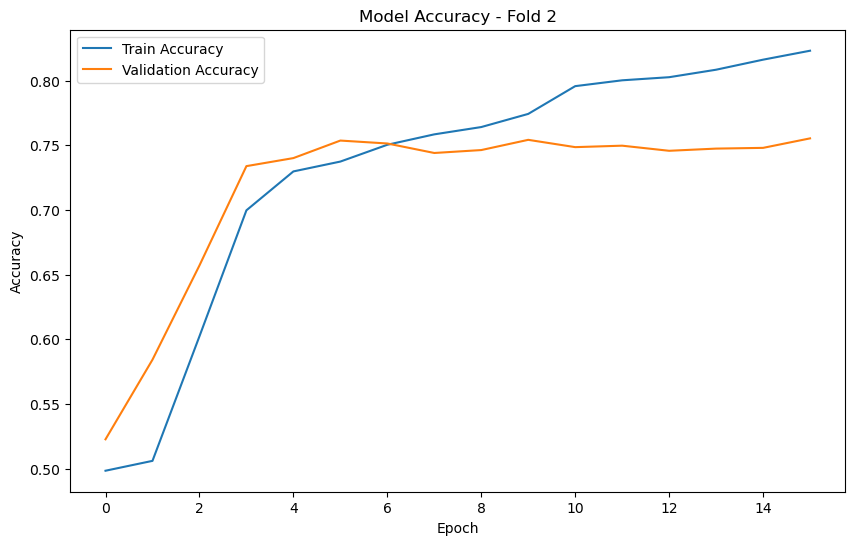

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7486
Balanced Accuracy: 0.7466
MCC: 0.4947
Sensitivity: 0.7810
Specificity: 0.7122

Learned track weights for fold 2:
Sequence weight: 0.5449
Structure weight: 0.4551

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.5121 - loss: 0.7091 - val_accuracy: 0.6124 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6112 - loss: 0.6582 - val_accuracy: 0.6797 - val_loss: 0.5988 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.6936 - loss: 0.5812 - val_accuracy: 0.7181 - val_loss: 0.5702 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7232 - loss: 0.5485 - val_accuracy: 0.7102 - val_loss: 0.5762 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7417 - loss: 0.5325 - val_accuracy: 0.7130 - val_loss: 0.5739 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7580 - loss: 0.5130 - val_accuracy: 0.7311 - val_loss: 0.5623 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7693 - loss: 0.4898 - val

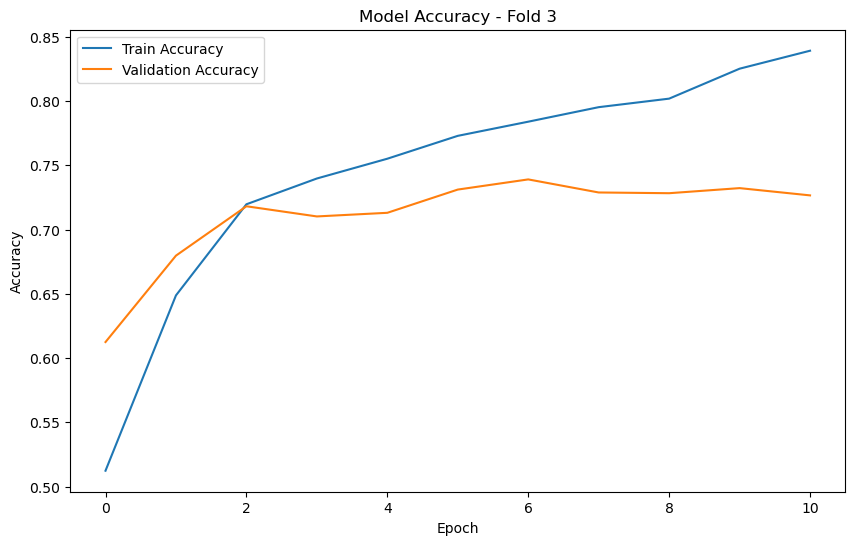

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

Fold 3 Results:
Accuracy: 0.7311
Balanced Accuracy: 0.7324
MCC: 0.4656
Sensitivity: 0.6911
Specificity: 0.7736

Learned track weights for fold 3:
Sequence weight: 0.5506
Structure weight: 0.4494

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.5324 - loss: 0.7049 - val_accuracy: 0.5695 - val_loss: 0.6856 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5987 - loss: 0.6642 - val_accuracy: 0.6475 - val_loss: 0.6349 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6786 - loss: 0.6088 - val_accuracy: 0.6932 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7295 - loss: 0.5477 - val_accuracy: 0.7141 - val_loss: 0.5741 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7440 - loss: 0.5233 - val_accuracy: 0.7113 - val_loss: 0.5928 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7671 - loss: 0.5008 - val_accuracy: 0.7158 - val_loss: 0.5691 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7856 - loss: 0.4810 - val

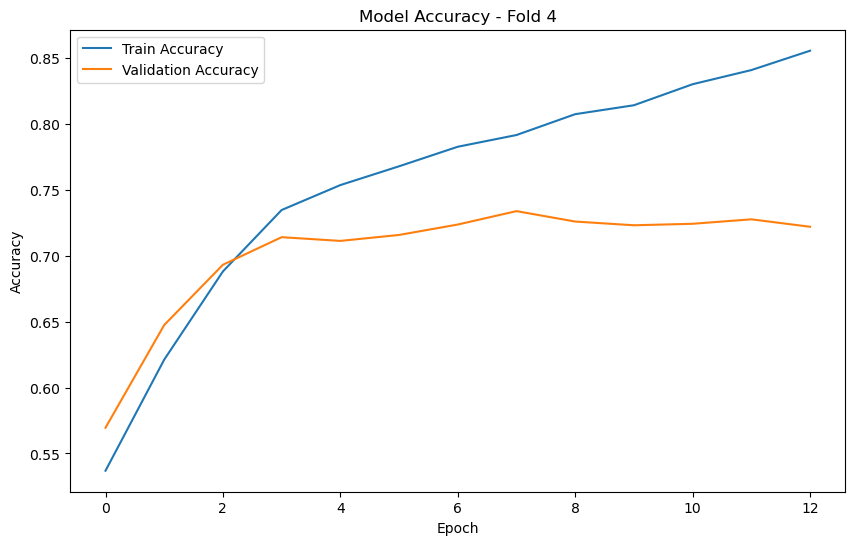

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 4 Results:
Accuracy: 0.7339
Balanced Accuracy: 0.7330
MCC: 0.4670
Sensitivity: 0.7612
Specificity: 0.7048

Learned track weights for fold 4:
Sequence weight: 0.5245
Structure weight: 0.4755

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.4993 - loss: 0.7081 - val_accuracy: 0.5588 - val_loss: 0.6828 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6257 - loss: 0.6460 - val_accuracy: 0.7147 - val_loss: 0.5674 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7224 - loss: 0.5632 - val_accuracy: 0.7226 - val_loss: 0.5486 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7428 - loss: 0.5338 - val_accuracy: 0.7294 - val_loss: 0.5362 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.7524 - loss: 0.5264 - val_accuracy: 0.7328 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.7615 - loss: 0.5088 - val_accuracy: 0.7345 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7783 - loss: 0.4904 - val

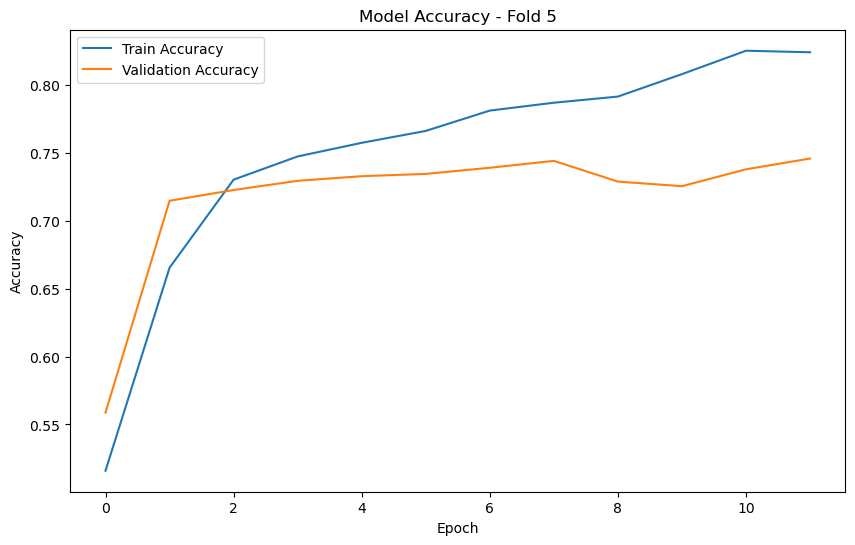

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7390
Balanced Accuracy: 0.7378
MCC: 0.4769
Sensitivity: 0.7699
Specificity: 0.7057

Learned track weights for fold 5:
Sequence weight: 0.5501
Structure weight: 0.4499

Average track weights across folds:
Sequence weight: 0.5449 ± 0.0106
Structure weight: 0.4551 ± 0.0106

Average Cross-validation Results:
ACC: 0.7394 ± 0.0065
BALANCED_ACC: 0.7384 ± 0.0054
MCC: 0.4791 ± 0.0120
SN: 0.7643 ± 0.0414
SP: 0.7125 ± 0.0346

Final Test Set Results:
Accuracy: 0.7165
Balanced Accuracy: 0.7335
MCC: 0.2813
Sensitivity: 0.7542
Specificity: 0.7129
Confusion Matrix:
[[1780  717]
 [  59  181]]
Loading data...

Training set distribution:
label
1    4592
0    4258
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8850, 33)
X_train_struct: (8850, 33, 12)
X_test_seq: (2737, 33)
X_test_struct: (2737, 33, 12)
y_train: (8850,)

/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.5196 - loss: 0.7050 - val_accuracy: 0.5463 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5928 - loss: 0.6747 - val_accuracy: 0.6469 - val_loss: 0.6393 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.6689 - loss: 0.6133 - val_accuracy: 0.7073 - val_loss: 0.5799 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7180 - loss: 0.5662 - val_accuracy: 0.7345 - val_loss: 0.5417 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7420 - loss: 0.5475 - val_accuracy: 0.7441 - val_loss: 0.5272 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7520 - loss: 0.5321 - val_accuracy: 0.7469 - val_loss: 0.5237 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7533 - loss: 0.5194 - val

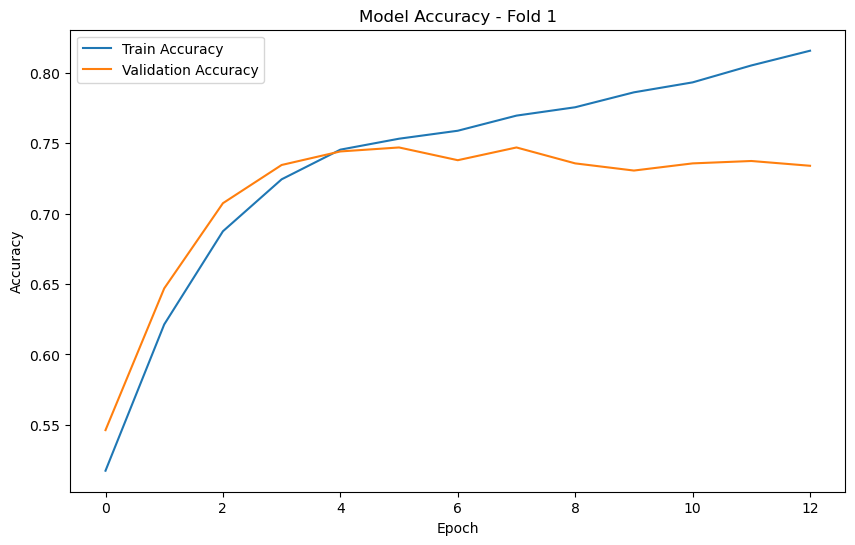

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 1 Results:
Accuracy: 0.7469
Balanced Accuracy: 0.7448
MCC: 0.4947
Sensitivity: 0.8105
Specificity: 0.6791

Learned track weights for fold 1:
Sequence weight: 0.5622
Structure weight: 0.4378

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.5300 - loss: 0.7142 - val_accuracy: 0.5525 - val_loss: 0.6847 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5786 - loss: 0.6776 - val_accuracy: 0.6492 - val_loss: 0.6523 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6444 - loss: 0.6442 - val_accuracy: 0.6497 - val_loss: 0.6287 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6697 - loss: 0.6090 - val_accuracy: 0.7011 - val_loss: 0.5920 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7045 - loss: 0.5689 - val_accuracy: 0.7090 - val_loss: 0.5778 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7349 - loss: 0.5382 - val_accuracy: 0.7373 - val_loss: 0.5488 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7575 - loss: 0.5057 - val

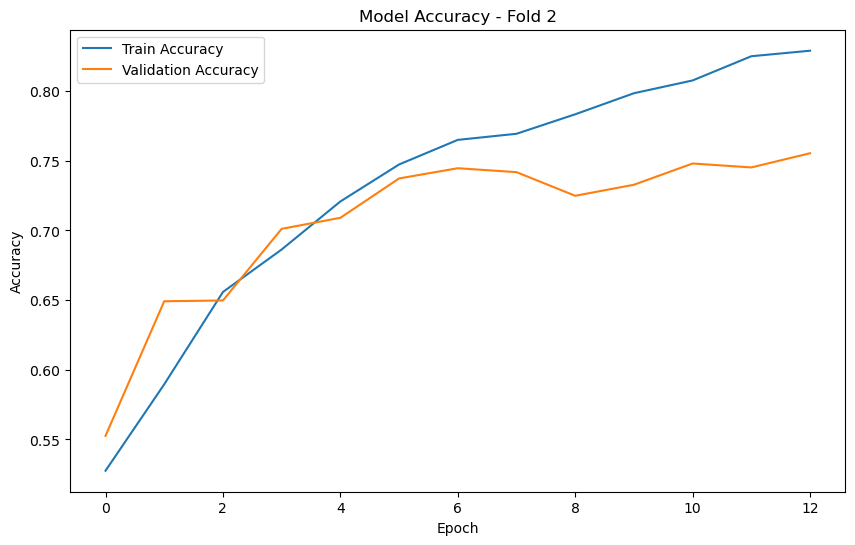

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 2 Results:
Accuracy: 0.7418
Balanced Accuracy: 0.7386
MCC: 0.4811
Sensitivity: 0.7938
Specificity: 0.6835

Learned track weights for fold 2:
Sequence weight: 0.5303
Structure weight: 0.4697

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.4904 - loss: 0.7011 - val_accuracy: 0.5819 - val_loss: 0.6786 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6296 - loss: 0.6516 - val_accuracy: 0.6757 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7041 - loss: 0.5748 - val_accuracy: 0.7169 - val_loss: 0.5583 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7294 - loss: 0.5466 - val_accuracy: 0.7237 - val_loss: 0.5547 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7504 - loss: 0.5144 - val_accuracy: 0.7299 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7626 - loss: 0.4980 - val_accuracy: 0.7266 - val_loss: 0.5625 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7809 - loss: 0.4742 - val

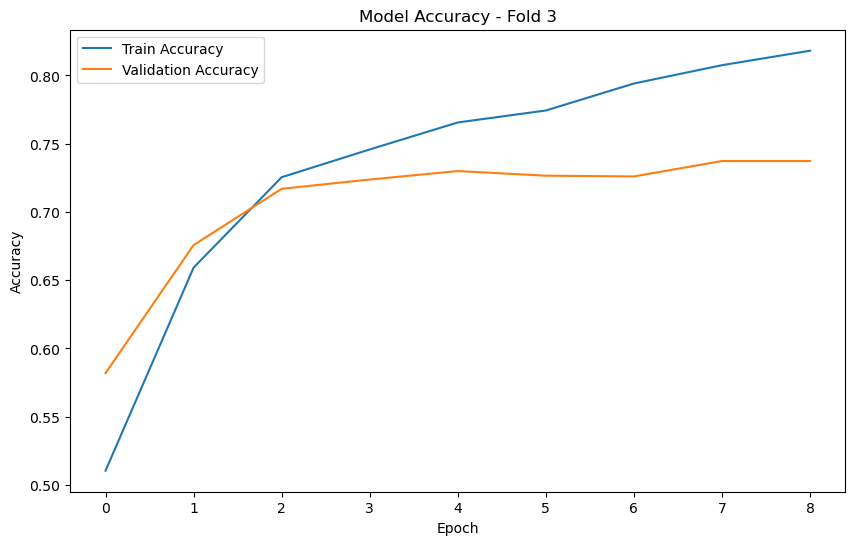

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 3 Results:
Accuracy: 0.7237
Balanced Accuracy: 0.7249
MCC: 0.4503
Sensitivity: 0.6889
Specificity: 0.7608

Learned track weights for fold 3:
Sequence weight: 0.5328
Structure weight: 0.4672

Fold 4/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.4867 - loss: 0.7000 - val_accuracy: 0.6113 - val_loss: 0.6756 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6211 - loss: 0.6516 - val_accuracy: 0.6966 - val_loss: 0.5935 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7062 - loss: 0.5737 - val_accuracy: 0.7277 - val_loss: 0.5525 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7377 - loss: 0.5370 - val_accuracy: 0.7288 - val_loss: 0.5449 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7583 - loss: 0.5183 - val_accuracy: 0.7294 - val_loss: 0.5398 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7585 - loss: 0.5029 - val_accuracy: 0.7362 - val_loss: 0.5301 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7771 - loss: 0.4843 - val

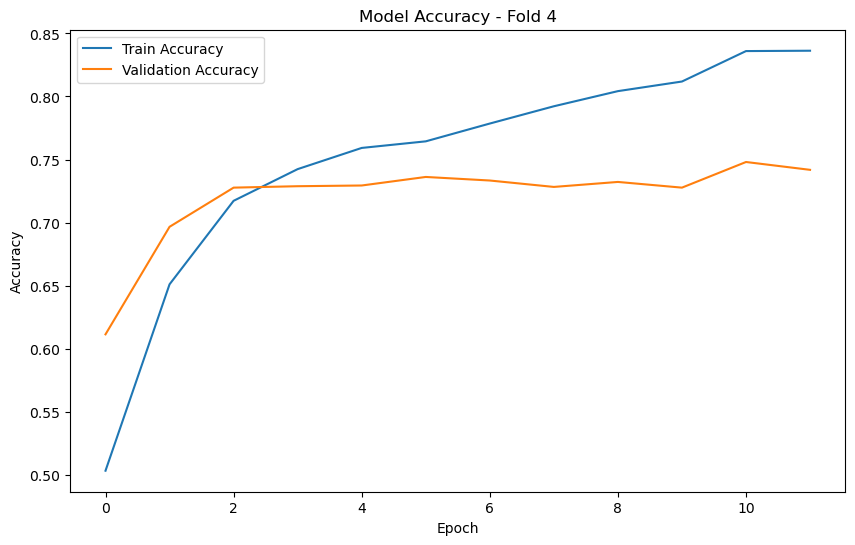

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 4 Results:
Accuracy: 0.7333
Balanced Accuracy: 0.7332
MCC: 0.4663
Sensitivity: 0.7371
Specificity: 0.7293

Learned track weights for fold 4:
Sequence weight: 0.5501
Structure weight: 0.4499

Fold 5/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.5244 - loss: 0.7089 - val_accuracy: 0.5379 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.5760 - loss: 0.6764 - val_accuracy: 0.6322 - val_loss: 0.6529 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.6420 - loss: 0.6346 - val_accuracy: 0.6588 - val_loss: 0.6276 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7059 - loss: 0.5806 - val_accuracy: 0.6870 - val_loss: 0.6057 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7410 - loss: 0.5368 - val_accuracy: 0.7107 - val_loss: 0.5962 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7628 - loss: 0.5095 - val_accuracy: 0.7181 - val_loss: 0.5893 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7878 - loss: 0.4738 - val

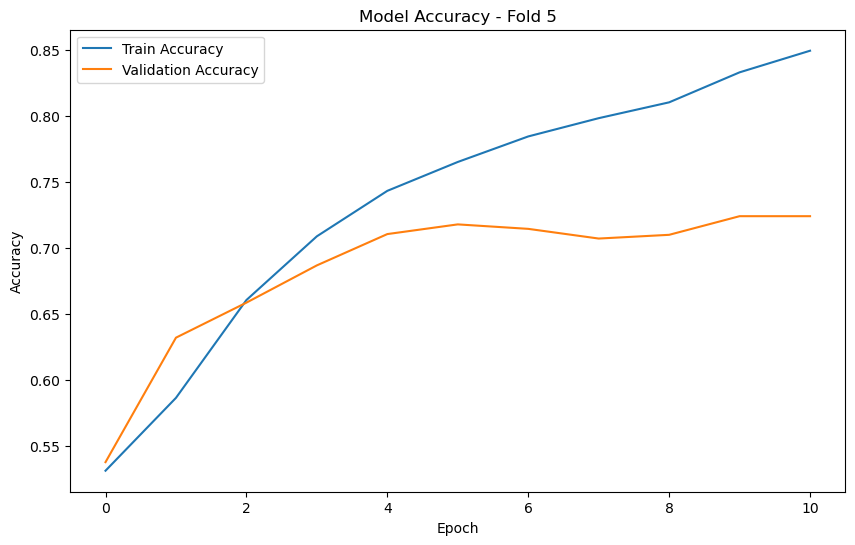

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 5 Results:
Accuracy: 0.7181
Balanced Accuracy: 0.7167
MCC: 0.4350
Sensitivity: 0.7546
Specificity: 0.6788

Learned track weights for fold 5:
Sequence weight: 0.5172
Structure weight: 0.4828

Average track weights across folds:
Sequence weight: 0.5385 ± 0.0158
Structure weight: 0.4615 ± 0.0158

Average Cross-validation Results:
ACC: 0.7328 ± 0.0108
BALANCED_ACC: 0.7316 ± 0.0099
MCC: 0.4655 ± 0.0213
SN: 0.7570 ± 0.0430
SP: 0.7063 ± 0.0332

Final Test Set Results:
Accuracy: 0.7231
Balanced Accuracy: 0.7258
MCC: 0.2745
Sensitivity: 0.7292
Specificity: 0.7225
Confusion Matrix:
[[1804  693]
 [  65  175]]


In [17]:
# window size 10 to 16
for struct_window in range(10, 17):
    model = train_and_evaluate(struct_window=struct_window)